In [4]:
!rm -rf data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/
!rm -rf data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/
!rm -rf ./data/raw/dataset1/numpy_splited/
!rm -rf ./data/preprocessed/dataset1/train/
!rm -rf ./data/preprocessed/dataset1/test/
!rm -rf first_break_picking/example/data/raw/dataset1/numpy_splited/

In [5]:
import sys
import os.path as osp
from pathlib import Path
import shutil
import os
import segyio
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def AGC(data, window_length):
    """
    Функция для автоматической регулировки усиления (AGC).
    
    Аргументы:
    - data: двумерный массив (сейсмическая сейсмограмма).
    - window_length: размер окна для вычисления среднего значения энергии.

    Возвращает:
    - data_agc: данные после применения AGC.
    """
    data = data.T
    # Длины данных
    n_traces, n_samples = data.shape
    data_agc = np.zeros_like(data)

    # Цикл по трассам
    for trace_idx in range(n_traces):        
        trace = data[trace_idx]
        # Вычисляем энергию в скользящем окне
        envelope = np.convolve(np.abs(trace), np.ones(window_length), mode='same') / window_length
        # Избегаем деления на 0, добавляем небольшой сдвиг
        envelope[envelope == 0] = 1e-10
        # Усиление сигнала (нормализация)
        data_agc[trace_idx] = trace / envelope
    
    return data_agc.T

In [7]:
def read_and_split_segy(file_path: str, header1: str, header2: str, output_dir: str, split_nt: int) -> dict:
    """Читает сейсмограмму из файла SEGY, разбивает её по указанным заголовкам (header1, header2)
    и экспортирует подсейсмограммы в .npy файлы.

    Parameters
    ----------
    file_path : str
        Путь к файлу SEGY.
    header1 : str
        Первый заголовок, по которому будет происходить разбивка.
    header2 : str
        Второй заголовок, по которому будет происходить разбивка.
    output_dir : str
        Папка, куда будут сохранены .npy файлы.

    Returns
    -------
    dict
        Словарь сейсмограмм, разбитых по значениям указанных заголовков.
    """
    split_seismograms = {}

    with segyio.open(file_path, ignore_geometry=True) as segy_file:
        # Получаем количество следов
        num_traces = segy_file.tracecount
        # Создаем массив для хранения данных
        data = np.zeros((num_traces, len(segy_file.samples)))

        # Чтение данных каждого следа
        for i in range(num_traces):
            data[i] = segy_file.trace[i]

        # Визуализируем оригинальную сейсмограмму
        plt.figure(figsize=(10, 6))
        plt.imshow(data.T, aspect='auto', cmap='gray')
        plt.title('Original Seismogram')
        plt.xlabel('Trace Number')
        plt.ylabel('Sample Number')
        plt.colorbar(label='Amplitude')
        plt.show()

        # Получаем значения атрибутов для двух заголовков
        try:
            field1 = getattr(segyio.TraceField, header1)
            field2 = getattr(segyio.TraceField, header2)
        except AttributeError as e:
            raise ValueError(f"Указанный заголовок '{e.args[0]}' отсутствует в TraceField.")

        attributes1 = segy_file.attributes(field1)[:]
        attributes2 = segy_file.attributes(field2)[:]

        # Группируем сейсмограммы по значениям двух заголовков
        for i in range(num_traces):
            header1_value = int(attributes1[i])  # Преобразуем значение первого заголовка в int
            header2_value = int(attributes2[i])  # Преобразуем значение второго заголовка в int
            key = (header1_value, header2_value)  # Используем кортеж в качестве ключа

            if key not in split_seismograms:
                split_seismograms[key] = []

            split_seismograms[key].append(data[i])  # Добавляем трассы без транспонирования

    # Транспонируем уже собранные подсейсмограммы
    transposed_seismograms = {key: np.array(value).T for key, value in split_seismograms.items() if np.array(value).T.shape[1] > split_nt}
    #transposed_seismograms = {key: np.array(value).T for key, value in split_seismograms.items()}
    
    # Сохраняем в формате .npy
    os.makedirs(output_dir, exist_ok=True)

    for (header1_value, header2_value), value in transposed_seismograms.items():
        #file_name = os.path.join(output_dir, f"seismogram_{header1}_{header1_value}_{header2}_{header2_value}.npy")
        file_name = os.path.join(output_dir, f"{header1_value*1000+header2_value}.npy")
        print(value.shape)
        # if value.shape[1] != 128:
        #     continue
        np.save(file_name, value)
        print(f"Сохранено: {file_name}")

    return transposed_seismograms



def save_seismograms_with_headers(seismograms: dict, output_dir: str, header1: str, header2: str):
    """Сохраняет сейсмограммы в формате .npy с указанием значений двух заголовков в названии файла.

    Parameters
    ----------
    seismograms : dict
        Словарь сейсмограмм, где ключами являются кортежи (header1_value, header2_value),
        а значениями — NumPy массивы сейсмограмм.
    output_dir : str
        Путь к выходной директории для сохранения файлов.
    header1 : str
        Название первого заголовка.
    header2 : str
        Название второго заголовка.
    """
    os.makedirs(output_dir, exist_ok=True)  # Создаем директорию, если она не существует

    for (header1_value, header2_value), seismo_data in seismograms.items():
        # Формируем имя файла с учетом заголовков и их значений
        #file_name = f"seismogram_{header1}_{header1_value}_{header2}_{header2_value}.npy"
        file_name = f"{header1_value}{header2_value}.npy"
        file_path = os.path.join(output_dir, file_name)
        print(seismo_data.shape)
        # Сохраняем сейсмограмму в .npy
        np.save(file_path, seismo_data)
        print(f"Сохранено: {file_path}")





def data_normalize_and_limiting(data: np.ndarray) -> np.ndarray:
    """
    Trace based scale a shot

    Parameters
    ----------
    data : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    norma = np.max(np.abs(data), axis=0)
    norma[np.abs(norma) < 1e-9 * np.max(np.abs(norma))] = 1
    data = data / norma * 4
    data[data < -1] = -1
    data[data > 1] = 1
    return data


def trim_npy_files_normalize(input_directory, output_directory, num_samples):
    """
    Читает файлы .npy, обрезает их до заданного количества сэмплов и сохраняет с обновленным названием.
    
    :param input_directory: Папка с исходными .npy файлами
    :param output_directory: Папка, куда сохранять обрезанные файлы
    :param num_samples: Количество сэмплов, до которого необходимо обрезать
    """
    # Убедимся, что директория для сохранения существует
    os.makedirs(output_directory, exist_ok=True)

    # Проход по всем файлам в указанной директории
    for filename in os.listdir(input_directory):
        # Проверяем, является ли файл файлом .npy
        if filename.endswith(".npy"):
            file_path = os.path.join(input_directory, filename)  # Полный путь к файлу
            
            # Загрузка numpy массива
            data = np.load(file_path)
            print(f"Файл загружен. Исходный размер: {data.shape}")
            
            # Проверяем, что обрезка возможна
            if data.shape[0] < num_samples:
                print(f"Пропущен файл {filename}: недостаточно сэмплов ({data.shape[0]}).")
                continue
            
            # Обрезаем массив до заданного количества сэмплов
            trimmed_data = data[:num_samples, :]
            print(f"Размер обрезанного файла: {trimmed_data.shape}")
            
            # Генерируем новое имя файла, добавляя количество сэмплов в название
            base_name = os.path.splitext(filename)[0]
            #new_filename = f"{base_name}_trim_{num_samples}.npy"
            new_filename = f"{base_name}.npy"
            new_file_path = os.path.join(output_directory, new_filename)

            trimmed_data = data_normalize_and_limiting(trimmed_data)
            # Сохраняем обрезанный массив
            np.save(new_file_path, trimmed_data)
            print(f"Обработанный файл сохранён: {new_file_path}\n")

    print("Обрезка всех файлов завершена.")

In [8]:
from config import split_nt

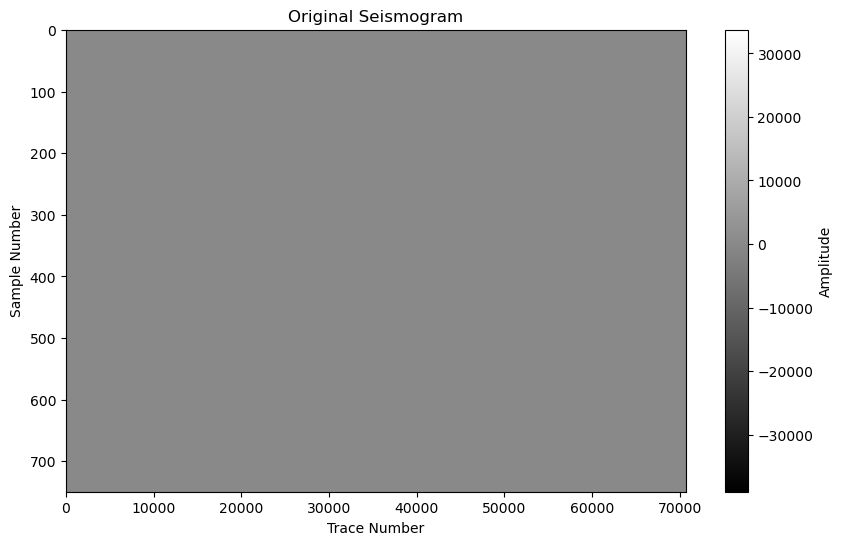

(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759021.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759022.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759023.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759024.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759025.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759026.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759027.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759028.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759029.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/dataset1/numpy_splited/15759030.npy
(750, 70)
Сохранено: first_break_picking/example/data/raw/da

In [9]:
file_path = r'83_shots_IEEE.sgy'
header1_to_split = 'EnergySourcePoint'  # Первый заголовок
header2_to_split = 'GroupStaticCorrection'  # Второй заголовок
output_directory = r'first_break_picking/example/data/raw/dataset1/numpy_splited'  # Папка для сохранения .npy файлов
seismograms = read_and_split_segy(file_path, header1_to_split, header2_to_split, output_directory, split_nt)

In [10]:
output_directory = r'./data/raw/dataset1/numpy_splited'  # Папка для сохранения файлов
header1_to_use = 'NPS'
header2_to_use = 'RLN'

# Сохранение данных:
save_seismograms_with_headers(seismograms, output_directory, header1_to_use, header2_to_use)

(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575921.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575922.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575923.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575924.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575925.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575926.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575927.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575928.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575929.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1575930.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1576021.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1576022.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1576023.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1576024.npy
(750, 70)
Сохранено: ./data/raw/dataset1/numpy_splited/1576025

In [11]:
# Директория с исходными .npy файлами
input_directory = r"./data/raw/dataset1/numpy_splited/"

# Директория для сохранения обрезанных файлов
output_directory = r"data/raw/dataset1/train_ovch_by_rln_4ms_trimmed"

# Задаём количество сэмплов для обрезки
num_samples = 750  # задайте нужное количество сэмплов

# Запускаем функцию
trim_npy_files_normalize(input_directory, output_directory, num_samples)

Файл загружен. Исходный размер: (750, 70)
Размер обрезанного файла: (750, 70)
Обработанный файл сохранён: data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/1576630.npy

Файл загружен. Исходный размер: (750, 66)
Размер обрезанного файла: (750, 66)
Обработанный файл сохранён: data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/6591018.npy

Файл загружен. Исходный размер: (750, 70)
Размер обрезанного файла: (750, 70)
Обработанный файл сохранён: data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/1576624.npy

Файл загружен. Исходный размер: (750, 128)
Размер обрезанного файла: (750, 128)
Обработанный файл сохранён: data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/10754219.npy

Файл загружен. Исходный размер: (750, 67)
Размер обрезанного файла: (750, 67)
Обработанный файл сохранён: data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/974603.npy

Файл загружен. Исходный размер: (750, 102)
Размер обрезанного файла: (750, 102)
Обработанный файл сохранён: data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/9745110

In [12]:
import pandas as pd
file_path = "test_fbpicking_83g.txt"

with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

with open(file_path, "w", encoding="utf-8") as file:
    file.writelines(line for line in lines if not line.lstrip().startswith("#"))

df = pd.read_csv('test_fbpicking_83g.txt', sep='\t', header = None)
df.columns = [x.strip() for x in "itrace  |   NSP |   NRP |   SLN |   RLN |   NTR |   FB_TIME".split("|")]



rln_list = sorted(df.RLN.value_counts().index.tolist())
nps_list = df.NSP.value_counts().index.tolist()
for nps in nps_list:
    for rln in rln_list:
        fb_time = df[(df.NSP == nps) & (df.RLN == rln)].set_index('itrace').FB_TIME
        if fb_time.shape[0]:
            npy_path = f'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/{nps}{rln}.npy'
            txt_path = f'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/{nps}{rln}.txt'
            # Если файл .npy отсутствует, создаём .txt
            if os.path.exists(npy_path):
                fb_time.rename('Time').to_csv(txt_path, index=False)

            

import os
import re
def keep_only_10_pairs(folder_path):
    """
    Функция находит все файлы вида XXXX.npy и XXXX.txt в папке folder_path,
    где XXXX – это некая числовая часть. Скрипт сохраняет только первые
    10 уникальных чисел (по возрастанию), а остальные файлы удаляет.
    """
    # Получаем список всех файлов в папке
    all_files = os.listdir(folder_path)
    
    # Словарь для группировки:
    # Ключ   -> число (int)
    # Значение -> список имён файлов с этим числом
    base_dict = {}
    
    # Регулярное выражение, чтобы извлечь число и расширение
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    
    # 1. Проходим по всем файлам в папке
    for filename in all_files:
        match = pattern.match(filename)
        if match:
            # match.group(1) – это сама числовая основа в виде строки
            # match.group(2) – расширение (npy или txt)
            base_num_str = match.group(1)
            base_num = int(base_num_str)
            
            # Сохраняем файл в словарь по ключу base_num
            if base_num not in base_dict:
                base_dict[base_num] = []
            base_dict[base_num].append(filename)
    
    # 2. Сортируем ключи (числа) по возрастанию
    sorted_numbers = sorted(base_dict.keys())
    
    # 3. Берём первые 10 чисел, которые хотим оставить
    numbers_to_keep = sorted_numbers[:30]
    
    # 4. Все остальные числа идут "за пределами" первых 10
    numbers_to_delete = sorted_numbers[30:]
    
    # 5. Удаляем файлы для чисел, которые не вошли в первые 10
    for base_num in numbers_to_delete:
        file_list = base_dict[base_num]
        for file_to_remove in file_list:
            full_path = os.path.join(folder_path, file_to_remove)
            print(f"Удаляю файл: {full_path}")
            os.remove(full_path)

keep_only_10_pairs("data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/")

In [13]:
import re
def move_pairs_by_percentage(source_folder, destination_folder, percentage=0.2):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    files = os.listdir(source_folder)
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    groups = {}
    
    for f in files:
        match = pattern.match(f)
        if match:
            num = int(match.group(1))
            if num not in groups:
                groups[num] = []
            groups[num].append(f)
    
    sorted_nums = sorted(groups.keys())
    total_pairs = len(sorted_nums)
    pairs_to_move = int(total_pairs * percentage)
    
    for num in sorted_nums[:pairs_to_move]:
        for fname in groups[num]:
            shutil.move(os.path.join(source_folder, fname),
                        os.path.join(destination_folder, fname))
    
    print(f"Перемещено {pairs_to_move} из {total_pairs} пар.")

move_pairs_by_percentage("data/raw/dataset1/train_ovch_by_rln_4ms_trimmed", "data/raw/dataset1/test_ovch_by_rln_4ms_trimmed")


Перемещено 118 из 590 пар.


In [14]:
!mv data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/9744512* data/raw/dataset1/test_ovch_by_rln_4ms_trimmed

In [15]:
! rm ./data/preprocessed/dataset1/train/*

zsh:1: no matches found: ./data/preprocessed/dataset1/train/*


In [16]:
#%% ========== Loading required packages 
import sys
import os.path as osp
from pathlib import Path
import shutil


from first_break_picking.data import save_shots_fb
from first_break_picking import predict



from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )
#%% ============ Define paths ===============
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/train_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/train"

# Path(path_to_save).mkdir(exist_ok=True, parents=True)
Path(preprocessed_path).mkdir(exist_ok=True, parents=True)
#%% =================== Prepare data =============
data_info = save_shots_fb(
        dataset_dir=raw_data_path,
        dir_to_save=preprocessed_path,
        split_nt= split_nt,
        overlap = overlap,
        time_window=[0, n_time_sampels],
        fbt_file_header=1,
        fbt_time_column=0,
        scale=True,
        grayscale=True,
        dt=dt,
        shot_ext=".npy",
        fb_ext=".txt"
        )
    
# %% ======== Show results ===========
checkpoint_path = project_path + f"/checkpoints/chp_fb_{num_epcohs}.tar"
print(f"checkpoint is loaded: {checkpoint_path}")



sub_fbs [array([496., 491., 486., 481., 477., 472., 467., 461., 458., 452., 447.,
       444., 440., 434., 429., 423., 420., 415., 410., 406., 401., 397.,
       392., 387., 382., 378., 371., 367., 363., 359., 356., 351., 346.,
       342., 338., 335., 331., 326., 324., 321., 316., 312., 310., 307.,
       303., 301., 297., 294., 291., 289., 286., 287., 284., 279., 277.,
       275., 274., 271., 270., 269., 269., 268., 268., 268.]), array([452., 447., 444., 440., 434., 429., 423., 420., 415., 410., 406.,
       401., 397., 392., 387., 382., 378., 371., 367., 363., 359., 356.,
       351., 346., 342., 338., 335., 331., 326., 324., 321., 316., 312.,
       310., 307., 303., 301., 297., 294., 291., 289., 286., 287., 284.,
       279., 277., 275., 274., 271., 270., 269., 269., 268., 268., 268.,
       268., 268., 269., 270., 270., 272., 273., 274., 275.]), array([410., 406., 401., 397., 392., 387., 382., 378., 371., 367., 363.,
       359., 356., 351., 346., 342., 338., 335., 331., 326., 3

In [16]:
!rm -rf ./data//preprocessed/dataset1/train/.ipynb_checkpoints

In [17]:
%matplotlib widget

In [18]:
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/train_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/train"

In [19]:
#%% ========== Loading required packages 
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from time import time
from pathlib import Path
import shutil
from matplotlib.ticker import MaxNLocator
# import sys
# sys.path.append(osp.abspath(osp.join(__file__, "../../")))
from first_break_picking import train
from first_break_picking.tools import seed_everything
from first_break_picking.data import save_shots_fb

from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     batch_size,
                     val_percentage,
                     num_epcohs,
                     step_size_milestone
                     )

/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/train_eval/parameter_tools.py:280: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/envs/first_pick_showcase_test/lib/python3.8/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/opt/anaconda3/envs/first_pick_showcase_test/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


base_dir ['./data//preprocessed/dataset1/train']


  0%|                                                                                                                                                          | 0/148 [00:00<?, ?it/s]/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/train_eval/train.py:248: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/first_pick_showcase_test/lib/python3.8/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:14<00:00,  2.00it/s, loss=0.0384]


Got 64493720/64749568 with accuracy 99.60
Dice score: 0.9960370063781738


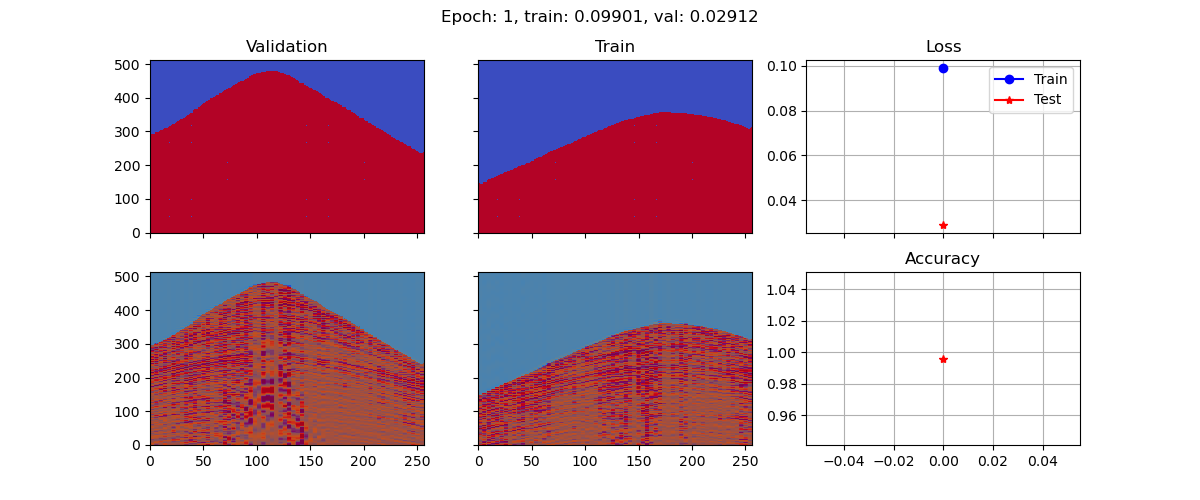

Epoch 1: 
train loss: 0.09900787212206302 
validation loss: 0.02912130020558834



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:08<00:00,  2.17it/s, loss=0.0153]


Got 64537920/64749568 with accuracy 99.67
Dice score: 0.9967234134674072


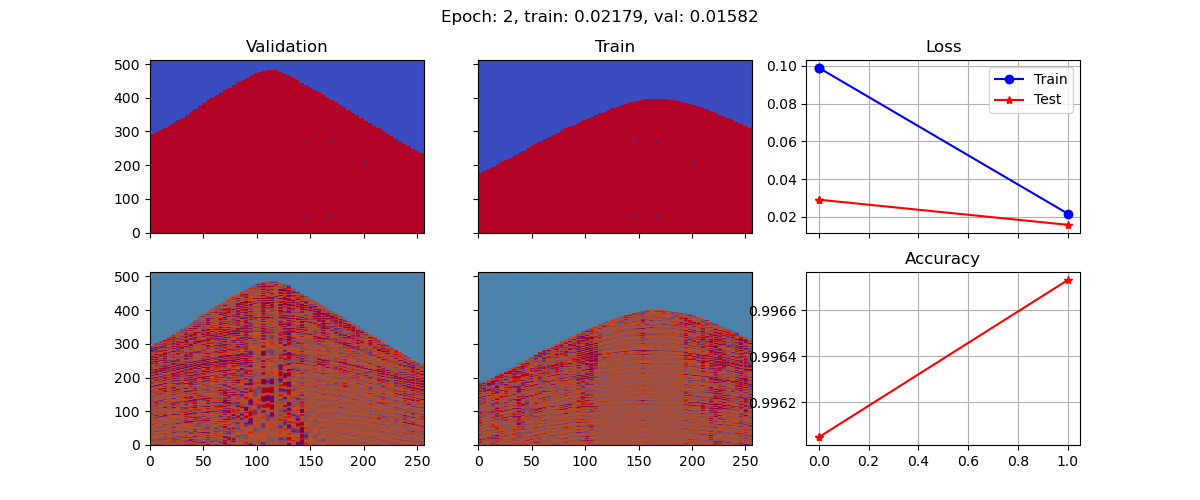

Epoch 2: 
train loss: 0.021785125539109513 
validation loss: 0.015819504857063293



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:08<00:00,  2.15it/s, loss=0.0122]


Got 64565554/64749568 with accuracy 99.72
Dice score: 0.99715256690979


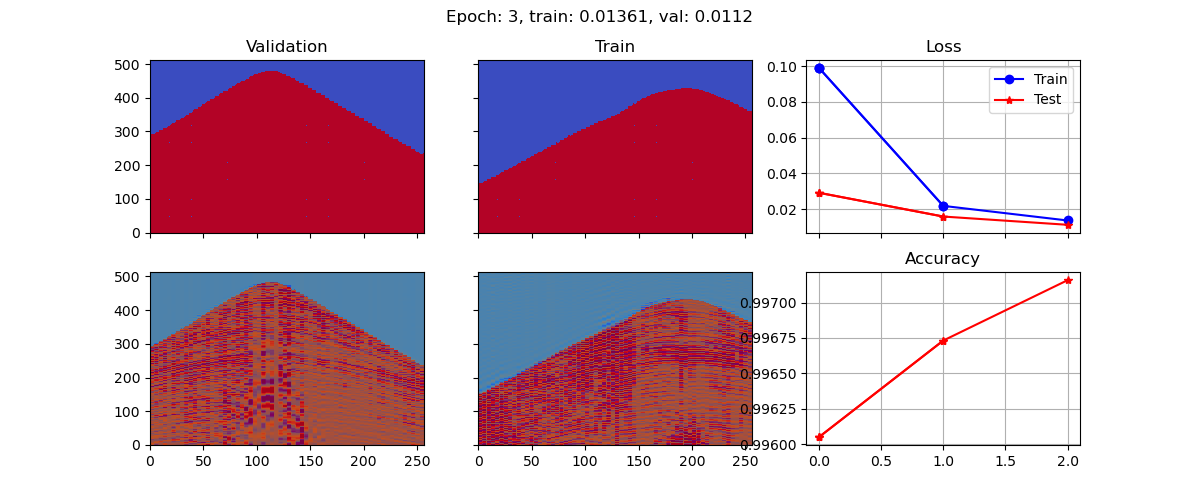

Epoch 3: 
train loss: 0.013612669131189987 
validation loss: 0.011199685744941235



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:09<00:00,  2.14it/s, loss=0.00914]


Got 64579310/64749568 with accuracy 99.74
Dice score: 0.9973729252815247


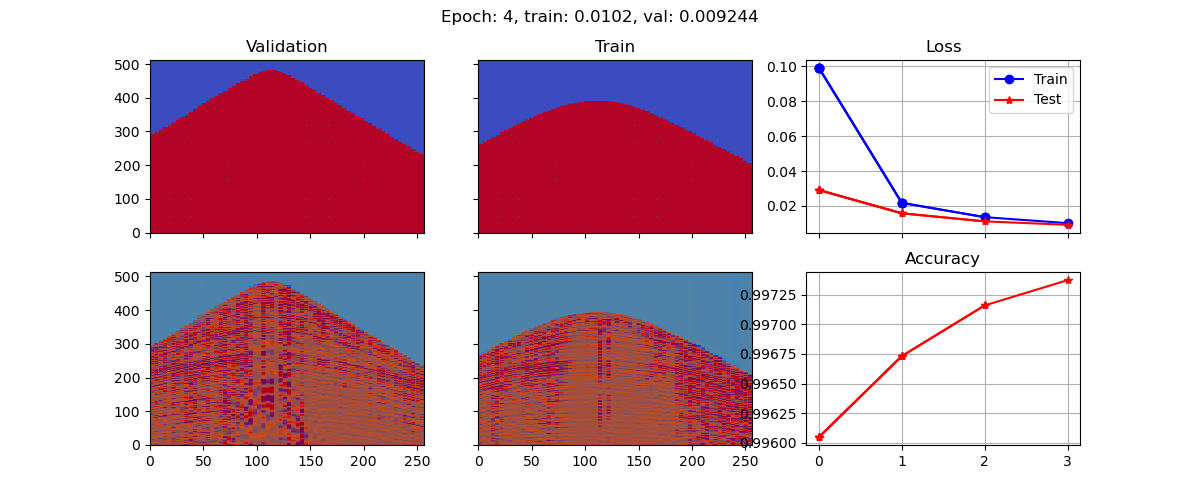

Epoch 4: 
train loss: 0.010197652271017432 
validation loss: 0.009244028478860855



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:15<00:00,  1.97it/s, loss=0.009]


Got 64585904/64749568 with accuracy 99.75
Dice score: 0.9974710941314697


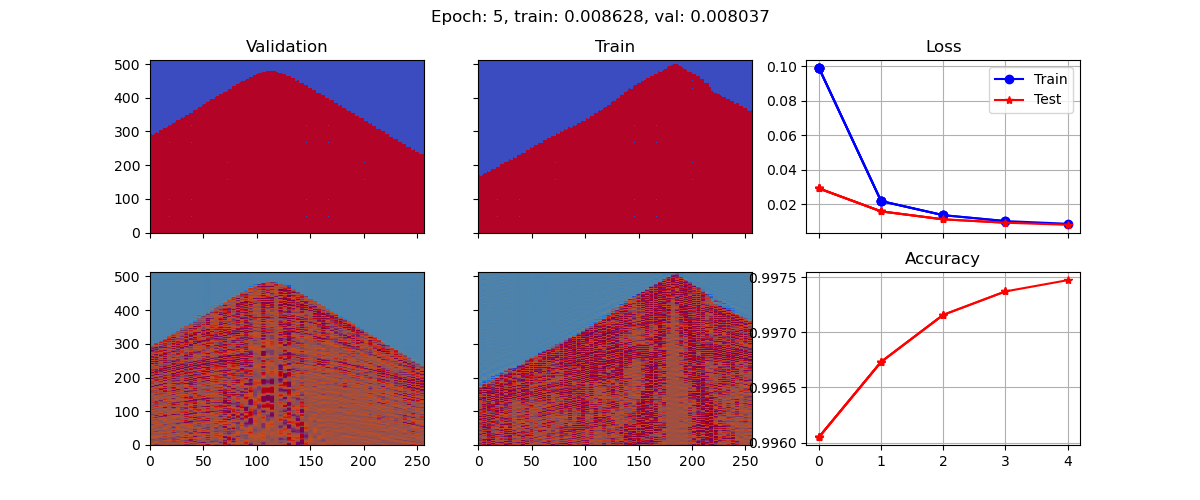

Epoch 5: 
train loss: 0.008627567861883624 
validation loss: 0.008036624640226364



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:13<00:00,  2.01it/s, loss=0.00576]


Got 64598138/64749568 with accuracy 99.77
Dice score: 0.997665286064148


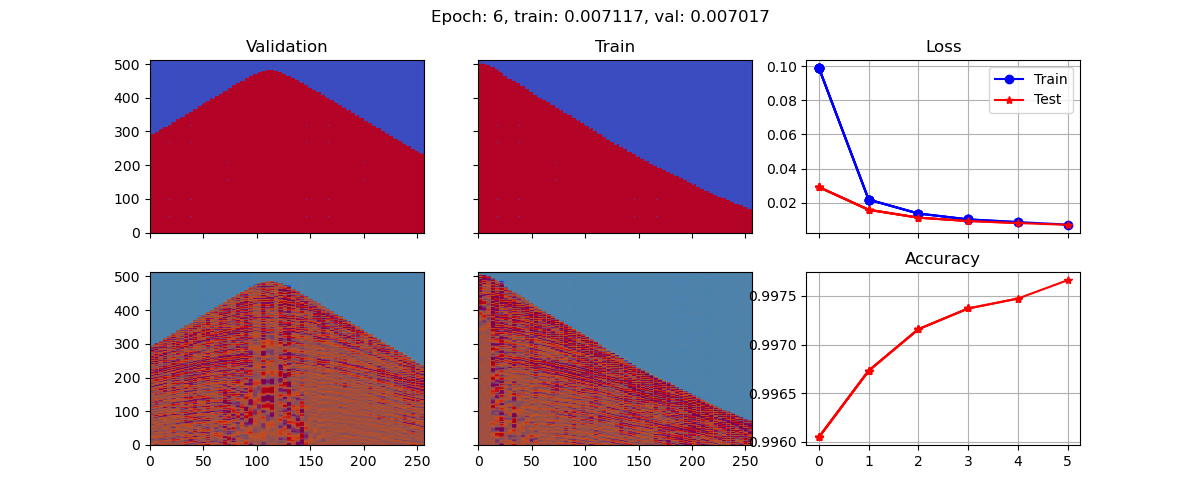

Epoch 6: 
train loss: 0.007117230655952684 
validation loss: 0.007017490919679403



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:23<00:00,  1.78it/s, loss=0.00519]


Got 64608044/64749568 with accuracy 99.78
Dice score: 0.9978163242340088


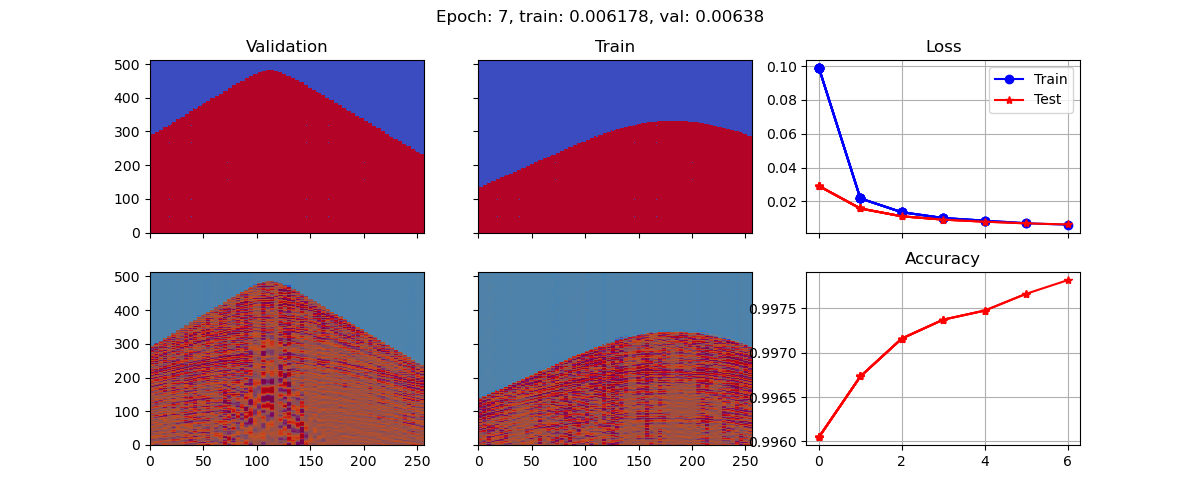

Epoch 7: 
train loss: 0.006177802123381077 
validation loss: 0.006380290258675814



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:10<00:00,  2.09it/s, loss=0.00633]


== Checkpoint is saved! ==
Got 64622740/64749568 with accuracy 99.80
Dice score: 0.9980372190475464


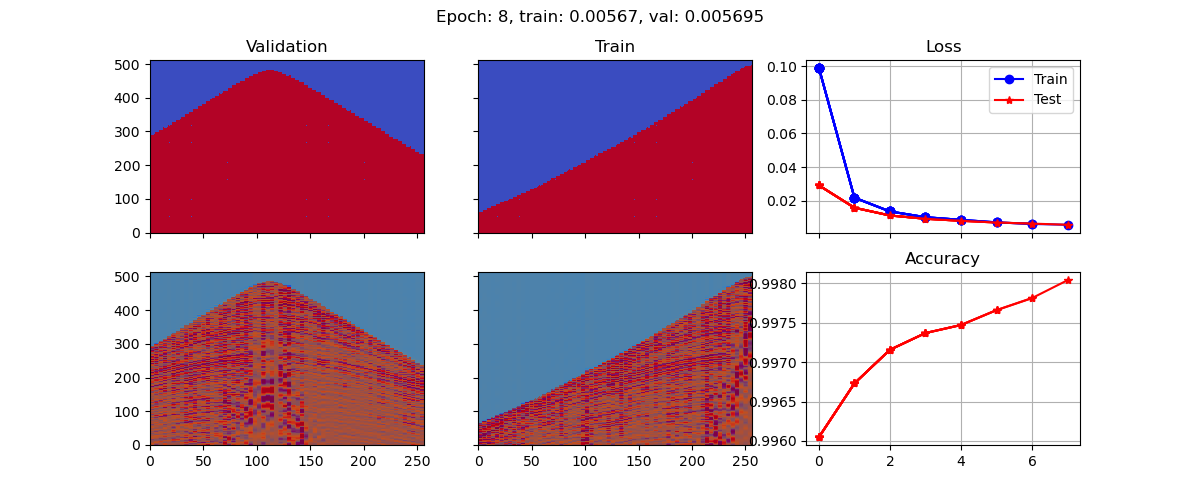

Epoch 8: 
train loss: 0.005669648375211132 
validation loss: 0.005695153493434191

It took 612.2319090366364 s for 8 epochs


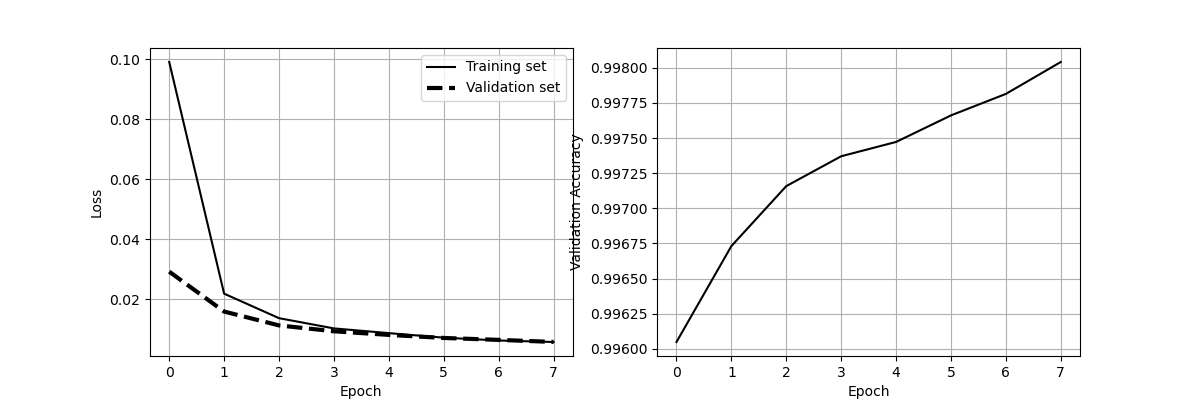

In [20]:
#%% =================== Training =================
tic = time()
train(preprocessed_path, 
    upsampled_size_row=n_time_sampels,
    upsampled_size_col=upsampled_size,
    batch_size=batch_size, 
    val_percentage=val_percentage,
    epochs=num_epcohs, 
    learning_rate=1e-4, 
    type_of_problem="fb",
    device="mps",
    checkpoint_path=None,
    path_to_save= project_path,
    save_frequency=num_epcohs,
    show=True,
    step_size_milestone=step_size_milestone
    )
toc = time()
print(f"It took {toc - tic} s for {num_epcohs} epochs")

# %% ============= plot metrics =================
metrics_path = f"{project_path}/checkpoints/metrics_fb.csv"
metrics = pd.read_csv(metrics_path)
    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
ax.plot(metrics.train_loss, label="Training set", 
    color="k")
ax.plot(metrics.valid_loss, linestyle="--",
     color="k", label="Validation set", linewidth=3
     )
ax.grid()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()

ax = fig.add_subplot(122)
ax.plot(metrics.pixel_accuracy, label="Pixel",
    color="k")
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

#shutil.rmtree(f"{data_base_train}/preprocessed")
plt.show()


In [21]:
import os
import shutil

if os.path.exists("./data/picked_fb_test_data"):
    shutil.rmtree("./data/picked_fb_test_data")


#%% ========== Loading required packages 
import sys
import os.path as osp
from pathlib import Path



from first_break_picking.data import save_shots_fb
from first_break_picking import predict


from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )
#%% ============ Define paths ===============
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/test_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/test"

# Path(path_to_save).mkdir(exist_ok=True, parents=True)
Path(preprocessed_path).mkdir(exist_ok=True, parents=True)
#%% =================== Prepare data =============
data_info = save_shots_fb(
        dataset_dir=raw_data_path,
        dir_to_save=preprocessed_path,
        split_nt= split_nt,
        overlap = overlap,
        time_window=[0, n_time_sampels],
        fbt_file_header=1,
        fbt_time_column=0,
        scale=True,
        grayscale=True,
        dt=dt,
        shot_ext=".npy",
        fb_ext=None
        )
    
# %% ======== Show results ===========
checkpoint_path = project_path + f"/checkpoints/chp_fb_{num_epcohs}.tar"
print(f"checkpoint is loaded: {checkpoint_path}")

predict(base_dir=preprocessed_path, 
        path_to_save=data_base_train,
        checkpoint_path=checkpoint_path,
        split_nt=split_nt, 
        overlap=overlap, 
        upsampled_size_row=n_time_sampels, 
        upsampled_size_col=upsampled_size,
        dt=dt, 
        smoothing_threshold=50,
        data_info=data_info, 
        model_name="unet_resnet",
        validation=False,
        save_list=None,
        out_channels=2,
        save_segmentation=False
        )

#shutil.rmtree(f"{data_base_train}/preprocessed")


shot [[126.98258778 128.2127127  127.34535133 ... 127.50543497 127.66339683
  128.44149737]
 [125.7325158  129.91129208 127.44959434 ... 128.65259279 127.41767258
  130.17641487]
 [125.03284476 129.27240467 126.88086706 ... 128.12481404 127.56903536
  130.74420025]
 ...
 [190.96652865  63.89732071 142.04468003 ...  63.77025746 191.42153061
   64.1747035 ]
 [190.96652865  63.89732071 191.02713378 ... 191.27025746 191.42153061
   64.1747035 ]
 [190.96652865  63.89732071 191.02713378 ... 191.27025746  69.99072514
  128.09597367]]
shot_name 974451.npy
shot [[127.24257552 127.19672803 127.77240312 ... 127.87913181 127.48665824
  127.99641774]
 [126.67088778 126.49631497 127.76700246 ... 128.34361197 127.43530378
  127.64831592]
 [126.70473897 126.69777772 128.34666936 ... 128.09133075 127.33291421
  128.3240603 ]
 ...
 [191.07352473 191.06875579 106.31828126 ...  63.89842764 191.29544672
   64.17387744]
 [ 63.57352473 191.06875579  91.79331642 ...  63.89842764 191.29544672
   92.89565643]
 

/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/train_eval/ai_tools.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_

=== Checkpoint is loaded! ===
['974451', '9744512', '974452', '974453', '974454', '974455', '974456', '974457', '974458', '974459', '974461', '974462', '974463', '974464', '974465', '974466', '974467', '974468', '974469', '974471', '974472', '974473', '974474', '974475', '974476', '974477', '974478', '974479', '974481', '974482', '974483', '974484', '974485', '974486', '974487', '974488', '974489', '974491', '974492', '974493', '974494', '974495', '974496', '974497', '974498', '974499', '974501', '974502', '974503', '974504', '974505', '974506', '974507', '974508', '974509', '974511', '974512', '974513', '974514', '974515', '974516', '974517', '974518', '974519', '974521', '974522', '974523', '974524', '974525', '974526', '974527', '974528', '974529', '974531', '974532', '974533', '974534', '974535', '974536', '974537', '974538', '974539', '974541', '974542', '974543', '974544', '974545', '974546', '974547', '974548', '974549', '974551', '974552', '974553', '974554', '974555', '974556'

  0%|                                                                                                                                                          | 0/119 [00:00<?, ?it/s]

predict::batch::before upsampler tensor([[[[[252.9652, 255.4254, 253.6907,  ..., 253.7027, 253.6186,
            254.2059],
           [250.4650, 258.8226, 253.8992,  ..., 253.8189, 251.9005,
            257.3153],
           [249.0657, 257.5448, 252.7617,  ..., 253.8740, 251.8722,
            257.3953],
           ...,
           [380.9330, 126.7946, 283.0894,  ..., 292.2830, 270.0593,
            263.0345],
           [380.9330, 126.7946, 381.0543,  ..., 294.6594, 291.4668,
            275.9464],
           [380.9330, 126.7946, 381.0543,  ..., 277.1879, 286.6887,
            279.7511]]],


         [[[253.9944, 255.4880, 251.8022,  ..., 256.1544, 253.2720,
            251.9787],
           [254.6672, 254.2756, 249.8666,  ..., 260.6906, 253.4512,
            250.6877],
           [254.8084, 255.7107, 250.3362,  ..., 259.6795, 252.3750,
            253.7529],
           ...,
           [381.2609, 128.2270, 379.6283,  ..., 176.9409, 234.6081,
            344.3578],
           [381.2609,

  1%|█▏                                                                                                                                                | 1/119 [00:01<03:52,  1.97s/it]

predict::batch::before upsampler tensor([[[[[253.4852, 253.3935, 254.5448,  ..., 252.9006, 254.3673,
            253.1201],
           [252.3418, 251.9926, 254.5340,  ..., 252.0257, 254.9905,
            251.7048],
           [252.4095, 252.3956, 255.6933,  ..., 251.4204, 255.3332,
            251.7694],
           ...,
           [381.1471, 381.1375, 211.6366,  ..., 180.0837, 145.4351,
            186.1224],
           [126.1470, 381.1375, 182.5866,  ..., 367.8663, 328.8902,
            274.8534],
           [126.1470, 182.6587, 171.9696,  ..., 380.5249, 381.9335,
            340.2503]]],


         [[[254.6986, 253.9767, 253.5476,  ..., 252.8759, 253.6104,
            253.4684],
           [254.6998, 253.7963, 252.2389,  ..., 253.0578, 254.0959,
            253.9089],
           [254.6491, 253.5203, 253.9232,  ..., 252.8159, 254.0527,
            254.0401],
           ...,
           [127.1310, 184.1186, 160.2689,  ..., 177.6629, 165.4985,
            266.6020],
           [263.8835,

  2%|██▍                                                                                                                                               | 2/119 [00:03<03:07,  1.60s/it]

predict::batch::before upsampler tensor([[[[[254.1685, 254.2401, 256.3098,  ..., 252.4558, 253.0876,
            253.5294],
           [254.1958, 253.2503, 263.2749,  ..., 246.3489, 252.9262,
            253.7221],
           [252.7189, 253.6343, 262.8440,  ..., 248.8609, 254.5518,
            253.8023],
           ...,
           [126.6624, 126.7567, 255.9510,  ..., 343.9429, 239.9326,
            251.3628],
           [126.6624, 381.7567, 258.3495,  ..., 306.7928, 235.7590,
            230.8050],
           [152.3513, 381.7567, 306.2469,  ..., 231.5414, 244.0907,
            224.6969]]],


         [[[254.7574, 254.2544, 255.0173,  ..., 254.6931, 253.9970,
            254.3000],
           [253.3043, 257.6320, 252.8755,  ..., 256.2866, 254.7912,
            254.8421],
           [251.4017, 258.0896, 253.5703,  ..., 256.5198, 255.1003,
            253.9332],
           ...,
           [128.1562, 381.1552, 271.0185,  ..., 244.9170, 240.2798,
            286.0225],
           [128.1562,

  3%|███▋                                                                                                                                              | 3/119 [00:04<02:49,  1.46s/it]

predict::batch::before upsampler tensor([[[[[255.1825, 254.2596, 252.1678,  ..., 253.2750, 254.9996,
            254.7460],
           [259.8802, 252.1337, 247.7011,  ..., 253.0378, 255.5836,
            251.8440],
           [258.0759, 250.0937, 250.2380,  ..., 253.0473, 255.4235,
            252.4498],
           ...,
           [381.2151, 127.2162, 381.5238,  ..., 244.1508, 159.0332,
            262.6011],
           [381.2151, 127.2162, 381.5238,  ..., 271.4911, 167.5015,
            212.6247],
           [381.2151, 127.2162, 381.5238,  ..., 281.3380, 255.0965,
            168.5950]]],


         [[[253.9064, 253.8613, 253.8428,  ..., 248.9872, 254.3535,
            252.3641],
           [254.3030, 250.3843, 255.9940,  ..., 246.7404, 257.1623,
            250.3385],
           [251.8872, 251.6214, 256.4750,  ..., 245.6287, 254.9779,
            250.1987],
           ...,
           [252.3634, 322.8611, 243.9452,  ..., 156.6926, 351.9251,
            280.9173],
           [340.6951,

  3%|████▉                                                                                                                                             | 4/119 [00:05<02:34,  1.34s/it]

predict::batch::before upsampler tensor([[[[[250.1591, 256.4789, 252.1005,  ..., 255.4040, 255.2473,
            254.8717],
           [250.0319, 258.5185, 247.0457,  ..., 255.3123, 256.7794,
            255.7277],
           [254.7030, 258.1266, 251.7402,  ..., 255.3258, 256.4835,
            255.3180],
           ...,
           [379.1254, 210.2566, 126.5464,  ..., 255.4848, 311.3441,
            382.1343],
           [235.1230, 128.4143, 381.5464,  ..., 240.4169, 294.0723,
            382.1343],
           [124.1254, 128.4143, 381.5464,  ..., 227.0565, 266.2747,
            339.2094]]],


         [[[254.0634, 256.3800, 256.0038,  ..., 250.5508, 252.2972,
            257.8582],
           [252.9734, 254.7550, 255.6839,  ..., 249.2250, 251.8081,
            256.3310],
           [254.9021, 254.7441, 255.9266,  ..., 250.5265, 251.9392,
            256.7909],
           ...,
           [334.6418, 164.8544, 292.2167,  ..., 270.0454, 184.1177,
            244.5543],
           [382.2597,

  4%|██████▏                                                                                                                                           | 5/119 [00:06<02:26,  1.28s/it]

predict::batch::before upsampler tensor([[[[[253.6251, 255.1665, 255.0043,  ..., 254.5160, 254.5296,
            254.3012],
           [252.7311, 252.5351, 257.0868,  ..., 254.6660, 254.6193,
            254.2385],
           [253.0873, 252.8476, 255.8267,  ..., 254.6230, 254.5792,
            254.2469],
           ...,
           [244.2819, 317.2243, 187.0989,  ..., 234.0738, 220.1446,
            236.7600],
           [126.2914, 383.7629, 126.6900,  ..., 251.6070, 225.7773,
            228.5043],
           [126.2914, 383.7629, 126.6900,  ..., 266.5272, 235.4190,
            231.6402]]],


         [[[255.8067, 252.3313, 254.3293,  ..., 254.4057, 251.9371,
            254.3975],
           [259.7185, 250.9230, 253.5633,  ..., 254.5109, 251.7222,
            254.4059],
           [258.7668, 251.3645, 253.8953,  ..., 254.3402, 251.7926,
            254.5523],
           ...,
           [381.7772, 296.4518, 282.7331,  ..., 253.0225, 214.7384,
            253.0458],
           [289.1772,

  5%|███████▎                                                                                                                                          | 6/119 [00:08<02:23,  1.27s/it]

predict::batch::before upsampler tensor([[[[[255.2186, 253.4570, 254.4822,  ..., 255.2079, 254.8387,
            254.6326],
           [256.2031, 251.9430, 255.1490,  ..., 255.1631, 254.8195,
            254.5708],
           [256.2596, 251.9920, 254.3609,  ..., 255.0863, 254.8010,
            254.6664],
           ...,
           [127.5548, 197.4302, 154.7733,  ..., 239.4382, 254.5806,
            263.3183],
           [270.8834, 381.3143, 126.7023,  ..., 247.7185, 258.5551,
            258.8037],
           [382.5548, 381.3143, 178.8636,  ..., 243.7946, 259.8120,
            253.3899]]],


         [[[253.1326, 253.5150, 253.7424,  ..., 256.3627, 254.0663,
            253.2851],
           [253.4359, 253.5531, 252.8744,  ..., 256.3913, 254.1443,
            252.9964],
           [252.5137, 253.5948, 253.1807,  ..., 256.4458, 254.2173,
            253.4261],
           ...,
           [305.3574, 146.7250, 381.0902,  ..., 268.8193, 234.5385,
            262.2020],
           [281.1146,

  6%|████████▌                                                                                                                                         | 7/119 [00:09<02:21,  1.26s/it]

predict::batch::before upsampler tensor([[[[[256.7951, 255.8825, 254.4725,  ..., 255.0443, 255.8726,
            255.1565],
           [259.8252, 255.8692, 252.8089,  ..., 254.9985, 255.5911,
            255.1113],
           [257.9195, 255.0851, 254.5490,  ..., 254.9806, 255.4149,
            255.0020],
           ...,
           [128.4670, 343.7589, 127.0343,  ..., 236.8997, 243.7308,
            255.4064],
           [128.4670, 354.2437, 230.9226,  ..., 227.4773, 243.2900,
            255.7721],
           [259.1402, 352.2929, 338.3107,  ..., 225.6451, 246.5032,
            255.0958]]],


         [[[254.8206, 254.3883, 257.0325,  ..., 255.0220, 253.0894,
            256.0202],
           [253.7193, 254.4591, 262.8225,  ..., 254.9173, 253.2568,
            256.0976],
           [253.8983, 255.0548, 261.1329,  ..., 254.9454, 253.2140,
            256.1100],
           ...,
           [188.8536, 135.2043, 296.6260,  ..., 208.9563, 241.4777,
            239.5773],
           [177.7844,

  7%|█████████▊                                                                                                                                        | 8/119 [00:10<02:19,  1.26s/it]

predict::batch::before upsampler tensor([[[[[254.2495, 254.2686, 253.8649,  ..., 254.1910, 254.3907,
            254.5380],
           [253.3349, 255.9274, 254.9996,  ..., 254.0890, 254.3881,
            254.5720],
           [253.9086, 254.0979, 254.9640,  ..., 254.1250, 254.3954,
            254.5912],
           ...,
           [287.1068, 126.5888, 353.6682,  ..., 261.7182, 247.9273,
            261.0492],
           [381.8331, 169.6789, 381.3202,  ..., 258.2061, 246.9544,
            255.1582],
           [369.6743, 255.9692, 343.4242,  ..., 259.0869, 250.4305,
            252.3923]]],


         [[[253.5411, 253.8349, 252.9648,  ..., 255.3473, 254.1308,
            253.0788],
           [253.0078, 254.0150, 253.2336,  ..., 255.4185, 254.3727,
            252.7950],
           [252.9637, 253.7637, 253.2227,  ..., 255.5877, 254.3037,
            252.8112],
           ...,
           [275.4043, 126.2520, 298.9832,  ..., 229.8112, 241.5585,
            293.5567],
           [260.4571,

  8%|███████████                                                                                                                                       | 9/119 [00:11<02:16,  1.24s/it]

predict::batch::before upsampler tensor([[[[[253.7672, 253.8675, 254.7269,  ..., 254.2238, 253.1364,
            253.3984],
           [252.8063, 250.3010, 255.0896,  ..., 254.1954, 252.9796,
            253.8322],
           [253.3587, 251.2271, 254.6421,  ..., 254.1352, 252.9998,
            253.6408],
           ...,
           [381.7079, 126.8278, 127.2263,  ..., 239.8441, 296.8622,
            240.2464],
           [126.7079, 232.6474, 127.2263,  ..., 247.9796, 280.6776,
            240.1843],
           [126.7079, 381.8278, 279.9533,  ..., 271.3779, 270.4318,
            274.1569]]],


         [[[253.4373, 253.8437, 253.6552,  ..., 254.0955, 256.1337,
            254.1705],
           [252.9920, 254.4489, 252.3710,  ..., 253.9915, 256.4978,
            254.3770],
           [253.1383, 254.4852, 252.3289,  ..., 253.8279, 256.4732,
            254.6905],
           ...,
           [246.5758, 255.2577, 266.8693,  ..., 381.2708, 267.8077,
            256.0423],
           [263.2231,

  8%|████████████▏                                                                                                                                    | 10/119 [00:13<02:13,  1.22s/it]

predict::batch::before upsampler tensor([[[[[252.8007, 254.0747, 254.8474,  ..., 253.6238, 253.9162,
            254.1768],
           [253.5281, 254.1897, 254.6116,  ..., 255.5151, 254.8134,
            254.1111],
           [254.4137, 254.1885, 255.0597,  ..., 255.6600, 254.5114,
            254.3730],
           ...,
           [380.7742, 126.6712, 381.5025,  ..., 238.7305, 234.0818,
            240.1642],
           [380.7742, 160.4816, 209.7546,  ..., 225.2547, 240.2901,
            210.4945],
           [235.2651, 301.9373, 126.5025,  ..., 227.5639, 247.1552,
            206.5254]]],


         [[[253.9957, 253.3279, 254.4892,  ..., 254.0220, 252.4565,
            254.0887],
           [254.1371, 251.4006, 254.8121,  ..., 254.1811, 252.1737,
            254.4041],
           [254.3958, 251.7611, 255.6564,  ..., 254.1460, 252.2383,
            254.3296],
           ...,
           [321.0669, 210.6311, 382.0031,  ..., 261.0941, 245.9173,
            257.1060],
           [126.5343,

  9%|█████████████▍                                                                                                                                   | 11/119 [00:14<02:11,  1.22s/it]

predict::batch::before upsampler tensor([[[[[254.2989, 254.8070, 255.9083,  ..., 253.3723, 253.6004,
            254.7542],
           [257.6860, 256.6960, 257.1491,  ..., 253.2270, 253.9508,
            254.2142],
           [257.2518, 257.4979, 248.4061,  ..., 253.2678, 253.9235,
            252.8178],
           ...,
           [382.4869, 286.6155, 126.8274,  ..., 257.8454, 251.7706,
            185.9967],
           [127.4869, 382.1644, 130.5743,  ..., 267.2146, 266.1277,
            186.6182],
           [127.4869, 382.1644, 381.8274,  ..., 265.7976, 272.1584,
            200.2626]]],


         [[[255.4535, 256.2497, 254.8639,  ..., 254.4353, 253.7885,
            253.4842],
           [255.1015, 260.5335, 254.8181,  ..., 254.8887, 253.4410,
            253.8102],
           [254.6880, 258.8528, 253.9897,  ..., 254.0058, 253.5725,
            253.6616],
           ...,
           [296.3726, 127.6549, 254.3113,  ..., 254.9440, 248.1856,
            264.0695],
           [267.6671,

 10%|██████████████▌                                                                                                                                  | 12/119 [00:15<02:11,  1.22s/it]

predict::batch::before upsampler tensor([[[[[251.6989, 258.1270, 255.0113,  ..., 254.0721, 254.5345,
            253.5179],
           [239.7604, 259.0978, 253.5729,  ..., 254.0775, 254.7709,
            253.4456],
           [239.2434, 257.9444, 254.6601,  ..., 254.1620, 254.8960,
            253.4622],
           ...,
           [190.6763, 130.5447, 127.4263,  ..., 248.0408, 269.5435,
            247.0996],
           [126.0605, 130.5447, 127.4263,  ..., 248.8705, 273.3156,
            252.5049],
           [126.0605, 385.5447, 265.9009,  ..., 257.9837, 255.6797,
            258.6902]]],


         [[[253.5544, 254.9052, 252.7687,  ..., 254.0816, 256.5412,
            251.3163],
           [251.5395, 253.9568, 253.2990,  ..., 254.2278, 255.6306,
            244.1381],
           [251.9916, 254.2738, 253.1217,  ..., 254.2750, 256.1281,
            249.0704],
           ...,
           [272.1386, 211.5984, 258.0213,  ..., 228.2793, 243.0487,
            381.8200],
           [214.9175,

 11%|███████████████▊                                                                                                                                 | 13/119 [00:16<02:09,  1.22s/it]

predict::batch::before upsampler tensor([[[[[255.2753, 252.8426, 253.4079,  ..., 253.8620, 254.8208,
            253.1796],
           [256.2010, 252.2714, 254.4835,  ..., 253.9031, 254.7425,
            253.1780],
           [256.9268, 251.8742, 252.3549,  ..., 253.9068, 254.7540,
            253.1792],
           ...,
           [329.7609, 294.1428, 232.6432,  ..., 260.6107, 253.0496,
            310.0954],
           [311.9914, 380.6341, 215.2131,  ..., 264.2307, 257.7430,
            305.7314],
           [244.7318, 380.6341, 241.5002,  ..., 265.3711, 260.9069,
            295.5357]]],


         [[[254.5651, 251.8760, 253.5258,  ..., 255.8205, 254.1775,
            254.3100],
           [255.8472, 248.9395, 254.3068,  ..., 256.0042, 253.7240,
            254.3011],
           [255.1560, 248.5119, 255.1076,  ..., 255.8537, 253.3408,
            254.2938],
           ...,
           [225.3470, 151.4268, 269.5808,  ..., 272.2827, 283.0995,
            256.6798],
           [225.6476,

 12%|█████████████████                                                                                                                                | 14/119 [00:17<02:08,  1.22s/it]

predict::batch::before upsampler tensor([[[[[255.5221, 255.3261, 254.0267,  ..., 254.5776, 254.0893,
            253.8552],
           [254.9111, 256.3381, 254.6541,  ..., 254.5958, 254.0313,
            253.7392],
           [254.0469, 257.1979, 254.7615,  ..., 254.6332, 254.0694,
            253.8277],
           ...,
           [128.2430, 382.7930, 126.3946,  ..., 279.8351, 265.2431,
            261.6470],
           [239.2712, 382.7930, 136.1885,  ..., 272.1057, 269.1442,
            267.3210],
           [383.2430, 223.9568, 260.2008,  ..., 265.1855, 277.4231,
            275.4419]]],


         [[[253.4444, 254.0413, 254.6429,  ..., 254.3660, 254.7207,
            254.3938],
           [254.0444, 253.9578, 254.2414,  ..., 254.4681, 254.8647,
            254.5074],
           [254.2838, 253.8631, 254.1472,  ..., 254.5127, 254.8027,
            254.5150],
           ...,
           [161.7688, 253.7401, 265.9479,  ..., 229.1003, 304.6150,
            275.6643],
           [208.4733,

 13%|██████████████████▎                                                                                                                              | 15/119 [00:19<02:06,  1.22s/it]

predict::batch::before upsampler tensor([[[[[254.3549, 254.8767, 255.7567,  ..., 254.7383, 254.4943,
            257.4488],
           [254.1228, 255.8000, 254.8328,  ..., 254.7672, 252.5993,
            250.1113],
           [253.6531, 255.4982, 255.2884,  ..., 254.5541, 254.8429,
            257.9519],
           ...,
           [270.7867, 382.0589, 231.4825,  ..., 234.4014, 251.8373,
            254.5756],
           [381.9156, 378.3019, 128.4556,  ..., 236.9905, 251.3077,
            254.4722],
           [381.9156, 259.9406, 128.4556,  ..., 246.9378, 251.2184,
            254.5296]]],


         [[[254.1144, 255.0775, 254.0334,  ..., 253.5163, 253.4988,
            254.7027],
           [253.2646, 256.0048, 252.9471,  ..., 253.4031, 253.4363,
            254.7208],
           [253.4958, 255.3366, 253.1730,  ..., 253.4605, 253.4775,
            254.7932],
           ...,
           [242.0048, 238.1375, 291.1131,  ..., 250.4039, 303.3146,
            218.9169],
           [211.4147,

 13%|███████████████████▍                                                                                                                             | 16/119 [00:20<02:03,  1.20s/it]

predict::batch::before upsampler tensor([[[[[255.8015, 254.5408, 252.4853,  ..., 253.1544, 254.2679,
            256.7703],
           [256.7950, 251.9207, 251.9773,  ..., 253.3112, 254.1682,
            256.8834],
           [255.8194, 251.6586, 251.9766,  ..., 253.3108, 254.2150,
            256.7976],
           ...,
           [264.1406, 381.8518, 125.1774,  ..., 233.8069, 263.1018,
            214.7567],
           [127.6510, 381.8518, 125.1774,  ..., 238.6889, 250.9647,
            204.3994],
           [127.6510, 369.3127, 318.6324,  ..., 249.3067, 241.2180,
            199.0453]]],


         [[[253.7246, 254.5306, 254.6215,  ..., 253.6805, 255.2519,
            253.3179],
           [253.8645, 255.7435, 254.3586,  ..., 253.5057, 254.7769,
            253.5463],
           [253.7865, 255.9287, 254.1781,  ..., 253.4081, 254.8650,
            253.6408],
           ...,
           [168.1333, 278.1626, 228.3850,  ..., 254.9285, 260.4256,
            302.1234],
           [185.0225,

 14%|████████████████████▋                                                                                                                            | 17/119 [00:21<02:01,  1.19s/it]

predict::batch::before upsampler tensor([[[[[255.7682, 256.2797, 254.9217,  ..., 253.4790, 253.8889,
            253.3207],
           [255.8524, 260.7032, 254.5578,  ..., 253.5931, 254.0533,
            253.1569],
           [255.3611, 260.2688, 254.8749,  ..., 253.6453, 253.5204,
            253.2309],
           ...,
           [128.2055, 341.2294, 382.4303,  ..., 199.7743, 321.5792,
            263.9647],
           [128.2055, 127.5113, 329.2670,  ..., 193.8153, 248.8693,
            244.4746],
           [180.4716, 127.5113, 290.0456,  ..., 211.3909, 189.6187,
            236.0599]]],


         [[[253.4716, 253.5888, 253.5683,  ..., 254.5444, 254.2229,
            253.5644],
           [253.7517, 253.0644, 253.5471,  ..., 254.5106, 254.2740,
            253.5806],
           [253.9868, 253.1141, 253.4385,  ..., 254.5050, 254.3021,
            253.6461],
           ...,
           [175.7654, 304.7764, 234.0714,  ..., 226.1011, 260.7242,
            293.8245],
           [211.1677,

 15%|█████████████████████▉                                                                                                                           | 18/119 [00:22<02:00,  1.19s/it]

predict::batch::before upsampler tensor([[[[[254.6395, 255.1025, 254.5403,  ..., 254.4467, 254.7489,
            254.0745],
           [254.9569, 257.3502, 253.4800,  ..., 253.2295, 254.6394,
            254.2123],
           [254.7797, 257.5106, 253.6087,  ..., 253.3859, 254.6082,
            254.1541],
           ...,
           [126.8719, 382.1363, 382.3597,  ..., 253.8175, 272.5422,
            263.4623],
           [126.8719, 127.1362, 382.3597,  ..., 227.5274, 274.6436,
            269.4840],
           [381.8719, 127.1362, 382.3597,  ..., 228.6428, 261.1423,
            262.0318]]],


         [[[252.0432, 252.5804, 255.5230,  ..., 253.6577, 254.1186,
            253.9238],
           [250.0653, 251.6955, 256.5989,  ..., 253.6959, 254.1015,
            254.0218],
           [250.0670, 251.7761, 255.7149,  ..., 253.6169, 254.1587,
            253.8808],
           ...,
           [362.7972, 331.5999, 167.5273,  ..., 240.0451, 249.0670,
            261.9050],
           [348.4837,

 16%|███████████████████████▏                                                                                                                         | 19/119 [00:23<01:59,  1.19s/it]

predict::batch::before upsampler tensor([[[[[253.9406, 253.1595, 255.7780,  ..., 252.7410, 253.6979,
            247.6738],
           [253.3985, 249.6163, 259.7508,  ..., 249.8585, 251.7906,
            250.8819],
           [259.0282, 250.9429, 260.2448,  ..., 250.6681, 251.1768,
            253.3220],
           ...,
           [381.1478, 126.3696, 127.2110,  ..., 126.5685, 126.6143,
            349.2379],
           [381.1478, 126.3696, 218.3381,  ..., 126.5685, 126.6143,
            378.3370],
           [381.1478, 126.3696, 382.2110,  ..., 158.1423, 156.0800,
            378.3370]]],


         [[[254.5848, 254.0187, 254.3150,  ..., 256.1851, 251.8728,
            257.5586],
           [253.3282, 259.1786, 253.6597,  ..., 255.6296, 246.6547,
            263.4975],
           [252.1657, 261.6162, 242.9028,  ..., 254.9166, 249.4338,
            263.3159],
           ...,
           [184.4442, 126.5560, 125.9256,  ..., 164.8686, 280.2052,
            163.7715],
           [127.3941,

 17%|████████████████████████▎                                                                                                                        | 20/119 [00:25<01:59,  1.20s/it]

predict::batch::before upsampler tensor([[[[[255.4953, 254.1559, 251.1399,  ..., 256.4578, 254.2095,
            253.9555],
           [255.3663, 253.7391, 241.7469,  ..., 255.8809, 255.0148,
            253.3155],
           [253.7019, 254.8344, 237.5887,  ..., 255.6429, 254.4041,
            253.4984],
           ...,
           [127.1439, 327.3431, 126.1490,  ..., 232.0056, 237.9024,
            249.3098],
           [127.1439, 239.7271, 381.1490,  ..., 222.6232, 203.8932,
            241.1581],
           [127.1439, 155.3590, 381.1490,  ..., 206.0224, 182.6627,
            215.1055]]],


         [[[255.5035, 245.4215, 250.7873,  ..., 254.6421, 254.4884,
            252.9487],
           [255.6384, 231.4746, 242.1473,  ..., 254.5825, 254.5323,
            252.9423],
           [253.2753, 236.6553, 246.8854,  ..., 254.5958, 254.6068,
            252.9593],
           ...,
           [127.7560, 290.1894, 214.0884,  ..., 259.0503, 255.6066,
            243.1883],
           [127.7560,

 18%|█████████████████████████▌                                                                                                                       | 21/119 [00:26<01:57,  1.20s/it]

predict::batch::before upsampler tensor([[[[[253.3087, 252.7434, 254.2827,  ..., 253.1643, 253.6759,
            253.1662],
           [254.0234, 254.9886, 251.3707,  ..., 253.0375, 253.5938,
            253.2985],
           [253.2361, 258.4695, 248.4763,  ..., 252.9171, 253.6953,
            253.6045],
           ...,
           [381.7000, 125.4789, 333.7053,  ..., 291.6547, 254.8042,
            264.4999],
           [381.7000, 380.4789, 296.3505,  ..., 275.3715, 255.4436,
            250.8893],
           [126.6999, 380.4789, 207.7444,  ..., 236.0611, 264.5042,
            235.6852]]],


         [[[252.0899, 257.0248, 254.2119,  ..., 254.5612, 254.0408,
            254.0779],
           [248.3744, 263.0792, 253.3380,  ..., 254.3141, 254.0151,
            254.2769],
           [248.5467, 258.7262, 252.8701,  ..., 254.4170, 254.1732,
            254.2274],
           ...,
           [153.4934, 383.0078, 378.3066,  ..., 257.8385, 266.5587,
            244.4375],
           [242.8646,

 18%|██████████████████████████▊                                                                                                                      | 22/119 [00:27<01:59,  1.24s/it]

predict::batch::before upsampler tensor([[[[[248.6360, 255.3743, 258.1208,  ..., 254.4253, 254.7977,
            256.0038],
           [237.8165, 247.7155, 270.3697,  ..., 254.5757, 254.8780,
            255.9319],
           [247.6468, 256.4629, 270.4024,  ..., 254.4594, 254.8084,
            255.9776],
           ...,
           [127.2063, 381.7331, 382.0860,  ..., 256.9655, 282.0802,
            247.9179],
           [127.2063, 381.7331, 127.0860,  ..., 256.4717, 286.3500,
            227.9326],
           [127.2063, 381.7331, 127.0860,  ..., 262.7092, 289.5130,
            214.8632]]],


         [[[253.1098, 254.2763, 254.2908,  ..., 252.8988, 253.9743,
            254.2829],
           [252.4277, 257.5844, 259.3683,  ..., 253.0518, 253.8733,
            254.2234],
           [254.4682, 256.2809, 259.1197,  ..., 252.6317, 253.8911,
            254.2753],
           ...,
           [206.0169, 333.4561, 332.3372,  ..., 245.2608, 268.1813,
            269.4030],
           [202.1906,

 19%|████████████████████████████                                                                                                                     | 23/119 [00:28<01:57,  1.23s/it]

predict::batch::before upsampler tensor([[[[[254.9475, 254.7237, 252.0631,  ..., 254.2266, 254.1089,
            253.9177],
           [255.8531, 256.0522, 245.3702,  ..., 254.1175, 253.6883,
            255.9228],
           [257.3419, 255.7452, 245.3524,  ..., 254.1803, 254.2161,
            253.7470],
           ...,
           [127.5170, 207.8191, 126.8481,  ..., 250.5138, 254.7940,
            257.1333],
           [127.5170, 147.3836, 150.9498,  ..., 253.4227, 253.9630,
            255.3239],
           [168.9818, 126.9987, 126.8481,  ..., 253.6358, 254.0610,
            254.4244]]],


         [[[253.8546, 253.4083, 252.9392,  ..., 253.4740, 254.0848,
            255.2460],
           [252.4839, 253.6173, 251.3359,  ..., 253.5819, 254.0886,
            255.1795],
           [253.3430, 254.4481, 252.3643,  ..., 253.5244, 254.0717,
            255.1583],
           ...,
           [240.0110, 256.0080, 268.0233,  ..., 230.2006, 241.8206,
            255.1879],
           [249.5728,

 20%|█████████████████████████████▏                                                                                                                   | 24/119 [00:30<01:56,  1.22s/it]

predict::batch::before upsampler tensor([[[[[256.3911, 254.7766, 255.0858,  ..., 254.4393, 254.0467,
            253.9419],
           [257.2822, 256.8645, 257.7203,  ..., 254.4337, 254.0384,
            253.9498],
           [256.7568, 257.8900, 259.2966,  ..., 254.4367, 254.0387,
            253.9558],
           ...,
           [128.7166, 381.6008, 127.2714,  ..., 252.1471, 253.5138,
            253.1685],
           [154.2872, 381.6008, 127.2714,  ..., 253.4734, 254.0212,
            254.2786],
           [128.7166, 381.6008, 127.2714,  ..., 255.1555, 255.2195,
            255.3081]]],


         [[[256.7991, 253.2685, 253.8439,  ..., 254.4221, 255.4067,
            254.5640],
           [261.1404, 252.4949, 252.9077,  ..., 254.4873, 255.3041,
            254.6534],
           [260.8009, 252.2140, 253.5146,  ..., 254.4651, 255.3297,
            254.6878],
           ...,
           [299.8720, 212.0435, 260.0394,  ..., 267.1813, 252.0121,
            250.7572],
           [290.2388,

 21%|██████████████████████████████▍                                                                                                                  | 25/119 [00:31<01:53,  1.21s/it]

predict::batch::before upsampler tensor([[[[[252.8708, 254.8294, 254.4359,  ..., 253.8634, 254.0107,
            254.3909],
           [248.9659, 252.9337, 256.3352,  ..., 253.8553, 254.0070,
            254.3952],
           [250.5387, 253.8961, 257.0406,  ..., 253.8546, 254.0007,
            254.3926],
           ...,
           [381.8201, 266.5639, 126.6450,  ..., 287.3938, 253.1482,
            234.9613],
           [381.8201, 382.8810, 126.6450,  ..., 289.8996, 253.3745,
            235.5261],
           [381.8201, 382.8810, 282.1938,  ..., 286.1625, 249.4016,
            237.3938]]],


         [[[255.1780, 253.2017, 254.3612,  ..., 254.4940, 254.8312,
            254.3086],
           [250.7005, 255.2337, 253.4733,  ..., 254.5772, 254.8372,
            254.2658],
           [253.3408, 253.9047, 253.4281,  ..., 254.5159, 254.8219,
            254.2745],
           ...,
           [343.7556, 265.1242, 279.0697,  ..., 249.0332, 255.4897,
            255.6954],
           [271.1643,

 22%|███████████████████████████████▋                                                                                                                 | 26/119 [00:32<01:52,  1.21s/it]

predict::batch::before upsampler tensor([[[[[254.6911, 253.3398, 254.0603,  ..., 253.2092, 254.2824,
            254.4543],
           [255.4401, 252.9785, 254.3816,  ..., 253.1561, 254.2799,
            254.4487],
           [255.1289, 253.7669, 254.1872,  ..., 253.3429, 254.2686,
            254.5127],
           ...,
           [381.9937, 198.4154, 157.7897,  ..., 186.6057, 224.2196,
            246.7229],
           [381.9937, 373.3220, 126.5434,  ..., 222.3385, 243.7172,
            255.1185],
           [126.9937, 381.0352, 126.5434,  ..., 267.6410, 272.4140,
            263.0181]]],


         [[[255.1051, 254.7343, 255.5442,  ..., 254.7421, 254.2901,
            253.7502],
           [256.7965, 255.2572, 258.4155,  ..., 254.5653, 254.4485,
            253.6756],
           [257.2849, 254.4497, 257.6681,  ..., 254.6140, 254.4336,
            253.6198],
           ...,
           [154.5854, 184.8349, 237.5327,  ..., 257.1837, 248.8088,
            239.7874],
           [127.0978,

 23%|████████████████████████████████▉                                                                                                                | 27/119 [00:33<01:50,  1.20s/it]

predict::batch::before upsampler tensor([[[[[254.5182, 257.8529, 256.0845,  ..., 254.5048, 253.6497,
            254.7469],
           [252.6037, 264.9467, 257.8317,  ..., 254.5690, 253.6070,
            254.7244],
           [250.9359, 263.5098, 257.1735,  ..., 254.5881, 253.6418,
            254.8056],
           ...,
           [195.5778, 127.9943, 127.9947,  ..., 261.3951, 250.0805,
            260.4050],
           [191.1859, 195.5282, 127.9947,  ..., 263.1484, 246.8609,
            227.8885],
           [135.0796, 382.9943, 127.9947,  ..., 255.5203, 245.2607,
            218.4417]]],


         [[[253.5385, 255.2767, 254.2406,  ..., 253.8435, 253.8111,
            253.9451],
           [251.3268, 255.4859, 254.2124,  ..., 253.8886, 253.7125,
            253.9283],
           [251.4406, 255.9767, 254.1964,  ..., 253.8866, 253.7360,
            253.9741],
           ...,
           [254.6075, 229.5120, 302.4867,  ..., 229.0392, 260.6333,
            257.7896],
           [341.6992,

 24%|██████████████████████████████████                                                                                                               | 28/119 [00:34<01:51,  1.22s/it]

predict::batch::before upsampler tensor([[[[[254.8142, 252.9642, 257.4339,  ..., 253.3973, 255.6813,
            254.1677],
           [253.3602, 255.2504, 261.3109,  ..., 253.4155, 255.8942,
            254.3365],
           [254.1152, 255.5134, 261.0831,  ..., 253.3760, 255.6479,
            254.3727],
           ...,
           [162.0063, 256.1294, 298.8167,  ..., 262.1093, 270.1675,
            262.1532],
           [146.3801, 175.2730, 375.2743,  ..., 237.9213, 235.9802,
            201.7947],
           [127.7857, 124.9102, 383.8032,  ..., 219.0864, 188.9999,
            152.7231]]],


         [[[255.3837, 253.3317, 253.7152,  ..., 253.8194, 251.1857,
            253.1246],
           [255.5616, 253.4765, 253.4620,  ..., 253.8508, 251.0409,
            253.1484],
           [255.9291, 253.3993, 253.4332,  ..., 253.9385, 251.6959,
            253.1751],
           ...,
           [332.5103, 231.4254, 205.4991,  ..., 318.0461, 271.9387,
            241.1505],
           [301.9076,

 24%|███████████████████████████████████▎                                                                                                             | 29/119 [00:35<01:44,  1.17s/it]

predict::batch::before upsampler tensor([[[[[253.8238, 252.7090, 253.7807,  ..., 254.5005, 255.9177,
            252.7692],
           [252.3551, 252.1296, 253.6702,  ..., 254.5107, 255.8184,
            252.6426],
           [252.0604, 252.7538, 254.6836,  ..., 254.4220, 255.8858,
            252.8613],
           ...,
           [205.3934, 380.4670, 138.2017,  ..., 189.8301, 149.3942,
            125.3013],
           [262.3262, 380.4670, 141.9032,  ..., 258.4899, 148.4562,
            263.0873],
           [318.1193, 380.4670, 168.9811,  ..., 350.0954, 175.8617,
            380.3013]]],


         [[[252.2218, 250.3633, 251.8848,  ..., 253.8175, 253.8263,
            254.3528],
           [252.3217, 249.6843, 252.2118,  ..., 253.7890, 253.5979,
            254.2588],
           [252.1209, 249.6400, 252.4324,  ..., 253.8952, 253.9200,
            254.2173],
           ...,
           [224.6712, 222.8542, 161.4301,  ..., 249.9650, 304.0822,
            192.2604],
           [273.5503,

 25%|████████████████████████████████████▌                                                                                                            | 30/119 [00:36<01:40,  1.13s/it]

predict::batch::before upsampler tensor([[[[[253.5301, 254.6369, 255.5242,  ..., 253.5378, 255.4034,
            255.7752],
           [253.7046, 256.5351, 258.6946,  ..., 253.5186, 255.5245,
            255.7322],
           [253.6987, 255.7454, 258.6574,  ..., 253.5480, 255.4337,
            255.7939],
           ...,
           [236.8587, 250.3128, 137.8577,  ..., 260.3857, 245.1151,
            236.8534],
           [301.1137, 276.9549, 164.0693,  ..., 242.5420, 281.7066,
            235.8419],
           [337.1490, 270.7659, 212.8706,  ..., 248.1673, 317.4754,
            250.9211]]],


         [[[253.6741, 254.9965, 253.2972,  ..., 253.6845, 252.7427,
            253.1691],
           [252.9238, 255.0998, 253.9005,  ..., 253.7161, 252.7316,
            253.1362],
           [253.5667, 254.7545, 253.6952,  ..., 253.6832, 252.7170,
            253.1024],
           ...,
           [291.3711, 288.5979, 176.4144,  ..., 281.0405, 279.1684,
            233.7695],
           [279.2288,

 26%|█████████████████████████████████████▊                                                                                                           | 31/119 [00:37<01:33,  1.06s/it]

predict::batch::before upsampler tensor([[[[[250.1176, 250.5239, 252.8483,  ..., 254.0556, 255.3735,
            254.7320],
           [245.8244, 251.0504, 251.3676,  ..., 254.3053, 255.5123,
            254.7219],
           [246.1205, 251.7783, 251.5745,  ..., 254.3013, 255.4987,
            254.7496],
           ...,
           [378.6791, 128.0669, 159.7222,  ..., 208.1007, 158.6880,
            173.8188],
           [347.3257, 176.9891, 186.3151,  ..., 215.7724, 148.3558,
            198.6180],
           [246.4268, 270.8316, 239.5909,  ..., 228.4681, 174.7014,
            220.1232]]],


         [[[254.6448, 251.9123, 251.0899,  ..., 254.0998, 254.0658,
            254.8345],
           [254.3738, 253.7170, 254.8946,  ..., 254.1069, 254.1847,
            254.7313],
           [255.6646, 251.1554, 250.3364,  ..., 254.1552, 254.1574,
            254.7384],
           ...,
           [142.0311, 298.7826, 214.4656,  ..., 289.1770, 204.1747,
            240.6916],
           [256.9624,

 27%|██████████████████████████████████████▉                                                                                                          | 32/119 [00:38<01:33,  1.07s/it]

predict::batch::before upsampler tensor([[[[[252.4561, 253.1780, 253.5018,  ..., 252.6200, 252.9026,
            251.2976],
           [253.2659, 253.5038, 253.2541,  ..., 252.7879, 253.0135,
            251.5102],
           [252.4062, 253.5403, 253.3239,  ..., 252.7573, 252.9725,
            251.7267],
           ...,
           [246.1874, 276.9438, 381.0446,  ..., 347.0844, 179.6777,
            339.1139],
           [323.7704, 243.5724, 356.3635,  ..., 374.8494, 170.7588,
            356.3673],
           [379.7154, 181.9027, 222.3198,  ..., 380.0851, 182.6200,
            346.9123]]],


         [[[253.5882, 254.1125, 252.5830,  ..., 254.4504, 253.4101,
            254.7701],
           [253.9471, 253.0704, 252.4266,  ..., 254.3559, 253.3791,
            254.7068],
           [254.0035, 252.2816, 252.4690,  ..., 254.6922, 253.3898,
            254.8162],
           ...,
           [231.3291, 274.5903, 231.3389,  ..., 320.0429, 373.8314,
            382.3129],
           [172.6249,

 28%|████████████████████████████████████████▏                                                                                                        | 33/119 [00:39<01:30,  1.05s/it]

predict::batch::before upsampler tensor([[[[[252.9613, 253.8281, 252.4630,  ..., 255.7065, 250.3441,
            255.9779],
           [253.0374, 254.3306, 252.3690,  ..., 255.6053, 250.6436,
            255.9543],
           [253.0928, 253.4946, 252.2546,  ..., 255.5827, 250.5560,
            255.9690],
           ...,
           [272.2442, 228.5217, 218.9399,  ..., 367.7517, 268.3108,
            231.6576],
           [238.8594, 370.8514, 239.6410,  ..., 383.1924, 235.9282,
            225.8677],
           [226.1875, 381.0681, 228.9933,  ..., 383.1924, 219.2765,
            233.0399]]],


         [[[256.3914, 252.9425, 251.5247,  ..., 253.0670, 253.7828,
            254.5687],
           [255.6698, 253.5301, 251.8595,  ..., 253.1127, 253.7775,
            254.5660],
           [255.8392, 252.8279, 251.7118,  ..., 253.0645, 253.7800,
            254.5549],
           ...,
           [195.3012, 179.7850, 225.6752,  ..., 248.7081, 274.8205,
            260.9980],
           [183.2875,

 29%|█████████████████████████████████████████▍                                                                                                       | 34/119 [00:40<01:27,  1.03s/it]

predict::batch::before upsampler tensor([[[[[254.2307, 252.3449, 252.2740,  ..., 253.4314, 257.1175,
            254.7961],
           [253.7391, 252.4243, 250.8713,  ..., 253.4748, 256.9868,
            254.9692],
           [253.4386, 252.3795, 251.4300,  ..., 253.3890, 256.8826,
            254.7567],
           ...,
           [234.2267, 233.8260, 380.2133,  ..., 277.2862, 236.4640,
            137.8809],
           [126.6863, 265.2314, 380.2133,  ..., 238.1601, 201.8648,
            170.2220],
           [149.4674, 333.2975, 380.2133,  ..., 228.5545, 195.5510,
            212.3985]]],


         [[[251.4828, 250.7929, 253.9091,  ..., 254.1891, 254.7459,
            256.4964],
           [251.6957, 251.1727, 255.2203,  ..., 254.1620, 254.6971,
            256.5345],
           [251.6016, 251.3569, 255.3804,  ..., 254.1743, 254.7277,
            256.5909],
           ...,
           [243.2407, 123.3325, 243.1242,  ..., 286.1969, 278.7050,
            243.8586],
           [256.6483,

 29%|██████████████████████████████████████████▋                                                                                                      | 35/119 [00:42<01:26,  1.03s/it]

predict::batch::before upsampler tensor([[[[[254.4544, 254.8567, 254.4631,  ..., 255.1593, 256.0049,
            254.3790],
           [254.5153, 254.6486, 254.3605,  ..., 255.0286, 256.0349,
            254.3802],
           [254.4530, 254.3808, 254.3753,  ..., 255.0527, 255.9780,
            254.4151],
           ...,
           [382.0587, 382.4013, 126.9978,  ..., 259.1205, 186.0262,
            249.8732],
           [382.0587, 345.6201, 126.9978,  ..., 294.8232, 215.3917,
            245.8157],
           [382.0587, 295.5107, 126.9978,  ..., 312.6118, 262.5439,
            242.9191]]],


         [[[250.6168, 251.7244, 252.2023,  ..., 256.2924, 254.4126,
            254.7418],
           [252.3619, 251.1411, 252.6427,  ..., 256.2925, 254.3954,
            254.8057],
           [251.6852, 251.3072, 252.6951,  ..., 256.2260, 254.4567,
            254.7798],
           ...,
           [317.6262, 379.4485, 124.7422,  ..., 128.8075, 258.1936,
            259.6959],
           [354.3017,

 30%|███████████████████████████████████████████▊                                                                                                     | 36/119 [00:42<01:24,  1.02s/it]

predict::batch::before upsampler tensor([[[[[254.7439, 255.9992, 254.1574,  ..., 254.5889, 254.1885,
            254.6554],
           [255.2466, 256.4095, 254.1465,  ..., 254.5633, 254.1769,
            254.6579],
           [254.6483, 256.2603, 254.0654,  ..., 254.5778, 254.2232,
            254.6624],
           ...,
           [236.4788, 221.9888, 243.0862,  ..., 247.3757, 293.8539,
            335.9051],
           [218.2737, 305.1370, 235.9697,  ..., 255.1535, 263.1432,
            317.9142],
           [193.2406, 366.8096, 262.0389,  ..., 256.9560, 219.3172,
            297.3360]]],


         [[[252.3422, 251.6693, 253.1993,  ..., 253.6994, 254.4906,
            254.3392],
           [252.6613, 251.0074, 253.6886,  ..., 253.7399, 254.5662,
            254.3288],
           [252.5856, 250.8171, 253.6961,  ..., 253.7286, 254.5336,
            254.3430],
           ...,
           [287.8297, 379.3400, 125.6000,  ..., 270.2573, 244.8574,
            268.1272],
           [274.3017,

 31%|█████████████████████████████████████████████                                                                                                    | 37/119 [00:44<01:23,  1.02s/it]

predict::batch::before upsampler tensor([[[[[253.0350, 253.5240, 255.7460,  ..., 253.9245, 253.3599,
            254.2543],
           [252.8261, 254.0297, 256.9713,  ..., 253.8871, 253.1875,
            254.2928],
           [252.8811, 254.4794, 256.3277,  ..., 253.7838, 252.7865,
            254.2715],
           ...,
           [280.7355, 308.6903, 180.4380,  ..., 312.4596, 257.6371,
            381.7629],
           [293.3558, 303.6096, 150.3141,  ..., 273.9650, 278.2102,
            369.9959],
           [259.9872, 306.9806, 145.3825,  ..., 239.0197, 288.3777,
            371.5573]]],


         [[[255.4514, 254.5693, 254.0611,  ..., 254.0345, 251.3854,
            254.1435],
           [255.7119, 254.5805, 253.9689,  ..., 254.2859, 252.1264,
            254.3814],
           [255.4672, 254.5269, 254.0517,  ..., 254.2260, 251.9498,
            254.3609],
           ...,
           [263.6279, 303.9187, 305.2208,  ..., 381.4002, 331.6282,
            204.0701],
           [320.5467,

 32%|██████████████████████████████████████████████▎                                                                                                  | 38/119 [00:45<01:22,  1.02s/it]

predict::batch::before upsampler tensor([[[[[254.1526, 254.9496, 255.0466,  ..., 253.5755, 255.5812,
            257.1305],
           [254.8024, 254.5995, 254.2818,  ..., 253.4829, 255.4520,
            256.8661],
           [254.2494, 254.4588, 254.8739,  ..., 253.5232, 255.4235,
            256.9851],
           ...,
           [230.0811, 241.7369, 244.3822,  ..., 270.5722, 128.1231,
            145.7143],
           [246.0556, 280.2985, 277.8464,  ..., 255.0397, 128.1231,
            129.5921],
           [236.5171, 329.0555, 273.5973,  ..., 240.0761, 128.1231,
            129.5921]]],


         [[[253.9304, 253.8169, 252.6396,  ..., 253.9547, 252.8837,
            254.4819],
           [254.1008, 252.9922, 252.2343,  ..., 253.9620, 252.9081,
            254.6970],
           [253.9922, 252.8731, 252.5333,  ..., 253.8691, 253.3652,
            254.5681],
           ...,
           [152.2045, 126.4203, 206.8036,  ..., 378.1848, 350.3558,
            126.8949],
           [149.4804,

 33%|███████████████████████████████████████████████▌                                                                                                 | 39/119 [00:46<01:20,  1.01s/it]

predict::batch::before upsampler tensor([[[[[256.4637, 255.0132, 253.2886,  ..., 254.4424, 255.6932,
            255.2980],
           [256.2356, 256.1921, 254.0674,  ..., 254.4103, 255.8093,
            255.3150],
           [256.2791, 254.1117, 253.9602,  ..., 254.3941, 255.7727,
            255.2102],
           ...,
           [292.9637, 223.9987, 198.7359,  ..., 309.3058, 259.9331,
            285.6068],
           [329.3039, 217.5934, 256.4319,  ..., 249.6069, 281.2750,
            263.2777],
           [309.9581, 218.9921, 258.3651,  ..., 204.0021, 276.5068,
            233.1308]]],


         [[[252.2992, 254.1533, 254.9494,  ..., 254.0576, 253.7229,
            252.9202],
           [252.1517, 253.9186, 255.4397,  ..., 254.0482, 253.6931,
            252.8552],
           [252.2407, 253.9995, 255.4660,  ..., 254.0144, 253.5422,
            252.9275],
           ...,
           [222.6028, 298.6054, 127.4883,  ..., 256.1885, 224.0615,
            215.6479],
           [225.2489,

 34%|████████████████████████████████████████████████▋                                                                                                | 40/119 [00:46<01:16,  1.03it/s]

predict::batch::before upsampler tensor([[[[[253.4259, 253.2494, 253.1469,  ..., 256.5212, 254.1671,
            254.6336],
           [252.9324, 253.2040, 253.5152,  ..., 256.5316, 254.0547,
            254.6030],
           [254.2696, 253.4275, 253.1602,  ..., 256.4221, 254.0866,
            254.6224],
           ...,
           [305.7236, 262.1147, 152.4084,  ..., 129.5137, 183.5836,
            223.9267],
           [320.3292, 237.3761, 185.5785,  ..., 195.2231, 136.6318,
            262.7035],
           [308.5118, 234.2834, 251.3144,  ..., 293.0158, 148.3799,
            302.0490]]],


         [[[254.8783, 254.0110, 252.6229,  ..., 254.8987, 253.9251,
            254.2199],
           [255.9284, 253.6254, 252.6467,  ..., 254.8757, 253.9397,
            254.2643],
           [255.4127, 252.9628, 253.1418,  ..., 254.8421, 253.9388,
            254.2798],
           ...,
           [148.5165, 303.3695, 377.0545,  ..., 237.9766, 297.5439,
            276.2847],
           [127.2234,

 34%|█████████████████████████████████████████████████▉                                                                                               | 41/119 [00:47<01:16,  1.02it/s]

predict::batch::before upsampler tensor([[[[[252.9646, 253.7006, 254.9564,  ..., 253.7332, 253.9756,
            254.8678],
           [252.7162, 253.6877, 254.5409,  ..., 253.7555, 253.9386,
            254.7527],
           [252.3878, 253.9068, 254.7551,  ..., 253.7227, 253.9676,
            254.7652],
           ...,
           [239.0641, 148.6245, 382.5896,  ..., 236.7594, 281.8143,
            284.8279],
           [240.4687, 203.4175, 379.3303,  ..., 203.4303, 236.6164,
            276.3117],
           [254.3639, 258.6083, 341.3664,  ..., 200.3553, 226.2127,
            262.2159]]],


         [[[253.3630, 253.2882, 254.0342,  ..., 254.2129, 255.4029,
            255.7303],
           [253.3992, 252.9195, 254.1009,  ..., 254.2854, 255.4463,
            255.6891],
           [253.4252, 253.1049, 253.9848,  ..., 254.3307, 255.3645,
            255.5616],
           ...,
           [254.6239, 185.4149, 195.5348,  ..., 290.3299, 328.4328,
            379.0251],
           [229.5408,

 35%|███████████████████████████████████████████████████▏                                                                                             | 42/119 [00:48<01:16,  1.01it/s]

predict::batch::before upsampler tensor([[[[[254.3407, 254.8271, 253.3186,  ..., 255.6785, 253.8931,
            254.9574],
           [254.3003, 254.4784, 253.3927,  ..., 255.6683, 254.1124,
            254.9189],
           [254.2332, 254.7404, 253.3564,  ..., 255.6689, 254.0705,
            255.0023],
           ...,
           [258.4287, 309.5087, 284.2304,  ..., 291.0583, 126.3729,
            306.9619],
           [160.7736, 382.4542, 253.6918,  ..., 374.7734, 126.3729,
            285.6828],
           [139.9452, 382.4542, 227.4635,  ..., 383.1609, 126.3729,
            284.0333]]],


         [[[254.5390, 253.9325, 253.6505,  ..., 254.1918, 253.6412,
            254.8805],
           [254.5400, 253.9822, 253.6586,  ..., 254.1386, 253.5749,
            254.8795],
           [254.5833, 253.9344, 253.6834,  ..., 254.1202, 253.5544,
            254.9239],
           ...,
           [234.5408, 270.7351, 218.4763,  ..., 267.3109, 321.7603,
            311.0425],
           [231.5522,

 36%|████████████████████████████████████████████████████▍                                                                                            | 43/119 [00:49<01:15,  1.00it/s]

predict::batch::before upsampler tensor([[[[[254.7757, 254.7035, 254.1646,  ..., 251.1869, 256.3651,
            253.3533],
           [254.7865, 254.7570, 254.3651,  ..., 251.1510, 256.1033,
            253.2089],
           [254.8525, 254.8407, 254.2446,  ..., 251.1624, 256.0992,
            253.1586],
           ...,
           [222.6115, 296.4264, 314.2262,  ..., 204.7171, 234.2705,
            277.5799],
           [215.9188, 273.6582, 288.7898,  ..., 162.7153, 201.5147,
            254.3405],
           [244.3042, 231.1476, 245.9771,  ..., 172.6059, 250.4933,
            211.7353]]],


         [[[253.5287, 255.1276, 254.5983,  ..., 255.0330, 256.4887,
            255.0168],
           [253.6125, 255.1551, 253.9767,  ..., 254.9569, 256.5403,
            255.0777],
           [253.5974, 255.1645, 254.1394,  ..., 254.9401, 256.5309,
            255.1262],
           ...,
           [246.8035, 220.5554, 210.8819,  ..., 276.8326, 269.3107,
            295.5485],
           [261.9668,

 37%|█████████████████████████████████████████████████████▌                                                                                           | 44/119 [00:50<01:14,  1.00it/s]

predict::batch::before upsampler tensor([[[[[253.4506, 252.0327, 254.0617,  ..., 253.9582, 254.8529,
            254.9004],
           [253.5837, 252.1388, 253.9734,  ..., 253.7794, 254.9310,
            254.8778],
           [253.4564, 252.2629, 254.0341,  ..., 253.8854, 254.8867,
            254.8887],
           ...,
           [324.0903, 213.6047, 221.6324,  ..., 239.2607, 242.7711,
            206.6969],
           [306.0848, 236.7251, 242.5831,  ..., 204.9119, 227.2991,
            209.3669],
           [256.5820, 271.8761, 259.6697,  ..., 224.7229, 208.5857,
            254.2367]]],


         [[[253.4302, 253.3905, 253.9737,  ..., 252.1216, 255.1741,
            254.8333],
           [253.7430, 253.3595, 254.0660,  ..., 252.0097, 255.1325,
            254.8317],
           [253.5791, 253.4032, 254.0876,  ..., 252.0134, 255.1389,
            254.9195],
           ...,
           [290.1888, 250.8320, 163.0888,  ..., 309.1341, 175.3138,
            213.8758],
           [248.5543,

 38%|██████████████████████████████████████████████████████▊                                                                                          | 45/119 [00:51<01:13,  1.00it/s]

predict::batch::before upsampler tensor([[[[[254.8108, 253.8100, 254.1763,  ..., 254.6582, 254.6321,
            254.7040],
           [254.7573, 253.6921, 254.2187,  ..., 254.6321, 254.5753,
            254.7222],
           [254.7974, 253.6594, 254.1949,  ..., 254.6441, 254.5936,
            254.7038],
           ...,
           [289.8048, 297.2355, 235.0646,  ..., 272.0484, 309.9694,
            236.3619],
           [276.0127, 274.0031, 317.0674,  ..., 259.9529, 291.2022,
            274.6432],
           [270.3714, 246.7443, 355.2209,  ..., 239.4441, 259.9096,
            307.6689]]],


         [[[254.0174, 252.9298, 253.7853,  ..., 254.6858, 253.7236,
            253.9431],
           [254.0780, 253.0594, 253.9191,  ..., 254.6690, 253.6840,
            253.9387],
           [254.0524, 253.0204, 253.8413,  ..., 254.6954, 253.6797,
            253.9451],
           ...,
           [228.7117, 125.4039, 374.3480,  ..., 258.8746, 298.9035,
            252.9403],
           [239.2628,

 39%|████████████████████████████████████████████████████████                                                                                         | 46/119 [00:52<01:13,  1.01s/it]

predict::batch::before upsampler tensor([[[[[252.5417, 253.5740, 253.3948,  ..., 254.5404, 253.9901,
            256.5086],
           [252.4024, 253.9792, 253.4513,  ..., 254.4843, 253.4906,
            256.7289],
           [252.5105, 254.0244, 253.5478,  ..., 254.5581, 253.6572,
            256.5919],
           ...,
           [300.7472, 222.8694, 304.4339,  ..., 213.5184, 274.9666,
            157.4981],
           [211.2878, 177.6886, 380.8817,  ..., 233.4049, 298.4461,
            189.6749],
           [132.1054, 149.1144, 380.8817,  ..., 270.0424, 327.3403,
            226.5260]]],


         [[[254.4257, 254.3793, 253.6614,  ..., 255.8042, 254.5489,
            252.4739],
           [254.4400, 254.3438, 253.5778,  ..., 255.8601, 254.5887,
            252.3767],
           [254.4857, 254.2848, 253.5519,  ..., 255.9346, 254.6435,
            252.6019],
           ...,
           [187.2513, 212.0747, 289.7455,  ..., 128.2885, 185.8157,
            245.4924],
           [174.0767,

 39%|█████████████████████████████████████████████████████████▎                                                                                       | 47/119 [00:53<01:13,  1.02s/it]

predict::batch::before upsampler tensor([[[[[253.6140, 254.5903, 255.2963,  ..., 254.4718, 252.2768,
            252.2895],
           [253.4422, 253.8375, 255.5794,  ..., 254.4979, 252.2230,
            252.5556],
           [253.5009, 254.0026, 255.6725,  ..., 254.4961, 252.1705,
            252.2282],
           ...,
           [194.8078, 229.6413, 301.9984,  ..., 174.2852, 345.2499,
            130.5661],
           [219.9369, 254.1196, 305.8995,  ..., 176.9084, 270.7080,
            135.9643],
           [234.7170, 291.8588, 276.0098,  ..., 187.3511, 200.2535,
            138.0972]]],


         [[[253.6484, 251.9149, 251.6565,  ..., 253.5156, 252.2857,
            255.0867],
           [253.3847, 251.9360, 251.6326,  ..., 253.5538, 252.2474,
            255.5144],
           [253.3000, 252.0051, 251.5264,  ..., 253.6374, 252.5176,
            255.3586],
           ...,
           [257.7220, 379.3530, 248.0712,  ..., 264.4623, 198.5229,
            304.8117],
           [213.5390,

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 48/119 [00:55<01:12,  1.02s/it]

predict::batch::before upsampler tensor([[[[[255.3872, 255.4892, 253.8970,  ..., 254.7557, 254.5014,
            254.3141],
           [255.8013, 255.5925, 253.6656,  ..., 254.7224, 254.4447,
            254.1243],
           [255.4442, 255.5344, 254.0056,  ..., 254.7202, 254.4988,
            254.1817],
           ...,
           [231.6266, 267.0896, 277.7265,  ..., 256.7352, 227.5222,
            205.3955],
           [213.8686, 246.1701, 298.9316,  ..., 269.9411, 213.7251,
            213.3565],
           [183.8476, 218.2196, 287.1894,  ..., 271.5109, 197.3532,
            218.3654]]],


         [[[252.2056, 255.0831, 251.7207,  ..., 253.1758, 253.1918,
            254.1022],
           [252.5573, 254.7596, 251.7368,  ..., 253.3002, 253.0722,
            254.0251],
           [252.6378, 254.8325, 251.6729,  ..., 253.3381, 253.1787,
            253.9892],
           ...,
           [192.8608, 276.5686, 295.9919,  ..., 229.5969, 258.8340,
            214.2964],
           [228.1806,

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 49/119 [00:55<01:08,  1.02it/s]

predict::batch::before upsampler tensor([[[[[253.8045, 253.0940, 253.9457,  ..., 254.0358, 252.6731,
            253.2564],
           [253.4496, 252.7203, 253.9537,  ..., 253.9256, 252.5896,
            253.2524],
           [253.2157, 253.0074, 254.0310,  ..., 253.8878, 252.6406,
            253.2063],
           ...,
           [191.2383, 265.1790, 276.8260,  ..., 129.6239, 201.8748,
            221.5526],
           [169.2553, 286.8795, 239.7272,  ..., 126.5383, 168.6215,
            221.1453],
           [212.4949, 291.7969, 211.3262,  ..., 126.5383, 159.6812,
            209.9538]]],


         [[[253.8234, 253.5991, 254.8704,  ..., 255.4094, 254.0411,
            255.9837],
           [253.4308, 254.2679, 254.5113,  ..., 255.4086, 254.1054,
            255.9069],
           [254.1203, 253.0990, 255.0957,  ..., 255.4330, 254.1002,
            255.8896],
           ...,
           [127.8819, 208.5061, 203.2087,  ..., 231.4244, 242.8125,
            207.8765],
           [127.8819,

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 50/119 [00:56<01:09,  1.00s/it]

predict::batch::before upsampler tensor([[[[[252.7967, 253.7075, 254.7914,  ..., 252.9633, 253.8217,
            255.5454],
           [252.8220, 253.7860, 254.8192,  ..., 252.9775, 253.8527,
            255.3735],
           [253.0792, 253.6817, 254.6520,  ..., 252.9662, 253.8217,
            255.3356],
           ...,
           [201.5742, 166.5500, 382.2766,  ..., 239.6529, 248.5852,
            195.0825],
           [248.0776, 126.1174, 382.2766,  ..., 246.4411, 262.3825,
            218.6050],
           [292.5227, 126.1174, 382.2766,  ..., 253.6078, 269.9434,
            263.8543]]],


         [[[253.6740, 253.9537, 255.9038,  ..., 255.3222, 255.5234,
            254.5588],
           [253.7432, 252.8098, 256.0892,  ..., 255.1728, 255.6403,
            254.6318],
           [253.7592, 252.8743, 256.0662,  ..., 255.1133, 255.4041,
            254.5135],
           ...,
           [317.1563, 126.6904, 137.1176,  ..., 369.7082, 356.7402,
            382.1192],
           [306.8754,

 43%|██████████████████████████████████████████████████████████████▏                                                                                  | 51/119 [00:57<01:08,  1.00s/it]

predict::batch::before upsampler tensor([[[[[253.6147, 254.7390, 253.0754,  ..., 255.9852, 254.2288,
            254.2202],
           [253.5841, 254.5383, 253.0242,  ..., 255.9211, 253.9851,
            254.2200],
           [253.5683, 254.5780, 253.0509,  ..., 255.9178, 253.9865,
            254.2103],
           ...,
           [246.2391, 247.6832, 252.4333,  ..., 261.7416, 126.7918,
            259.5680],
           [207.4123, 315.3913, 258.3390,  ..., 290.7037, 126.7918,
            277.4231],
           [193.0478, 382.3127, 233.7973,  ..., 287.1756, 126.7918,
            290.0499]]],


         [[[253.5692, 254.1980, 253.9789,  ..., 254.1468, 253.4312,
            255.0384],
           [253.5438, 254.7654, 254.2469,  ..., 254.1570, 253.3240,
            255.0543],
           [253.4958, 254.5999, 254.2100,  ..., 254.1591, 253.3611,
            255.0229],
           ...,
           [241.3858, 235.5742, 257.9295,  ..., 235.8576, 296.6897,
            290.7739],
           [223.6384,

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 52/119 [00:58<01:06,  1.00it/s]

predict::batch::before upsampler tensor([[[[[255.6214, 255.9934, 253.4950,  ..., 252.8056, 253.6434,
            254.5132],
           [256.0211, 256.0995, 253.2612,  ..., 252.8009, 253.7270,
            254.4407],
           [255.8261, 256.0534, 253.2740,  ..., 252.7618, 253.7206,
            254.3904],
           ...,
           [247.8987, 264.5370, 272.0631,  ..., 191.0103, 225.0359,
            294.5619],
           [194.2216, 222.8191, 260.3341,  ..., 198.5390, 273.2854,
            303.2325],
           [166.9871, 254.0055, 207.1611,  ..., 212.1160, 351.6194,
            314.8768]]],


         [[[254.5475, 253.5689, 254.9936,  ..., 254.5041, 255.7987,
            256.7070],
           [254.5263, 253.5815, 255.2540,  ..., 254.5560, 255.8022,
            256.7994],
           [254.4967, 253.4532, 255.0806,  ..., 254.5406, 255.7695,
            256.8197],
           ...,
           [162.5620, 214.4775, 241.7648,  ..., 293.2187, 316.0450,
            277.2631],
           [154.2962,

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 53/119 [00:59<01:06,  1.00s/it]

predict::batch::before upsampler tensor([[[[[253.0138, 251.9789, 253.9025,  ..., 252.3590, 254.1917,
            253.6467],
           [253.2600, 252.1986, 253.7751,  ..., 252.3759, 254.2355,
            253.6947],
           [253.2451, 251.9929, 253.8805,  ..., 252.3962, 254.2037,
            253.6948],
           ...,
           [287.4754, 221.7455, 230.7611,  ..., 273.3576, 271.7808,
            244.7464],
           [271.9920, 206.4600, 239.5069,  ..., 270.7881, 279.8474,
            235.8246],
           [244.7421, 169.7050, 251.9975,  ..., 264.5765, 273.8767,
            247.8256]]],


         [[[255.2639, 255.2116, 253.0301,  ..., 254.1672, 255.4843,
            254.4554],
           [255.5473, 255.2476, 252.9742,  ..., 254.1665, 255.4718,
            254.4969],
           [255.5074, 255.2558, 252.9376,  ..., 254.1866, 255.3866,
            254.4953],
           ...,
           [215.9466, 178.0070, 174.6543,  ..., 381.6737, 271.2196,
            224.6501],
           [177.7928,

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 54/119 [01:00<01:05,  1.01s/it]

predict::batch::before upsampler tensor([[[[[255.0031, 252.5836, 255.3984,  ..., 254.2548, 253.5698,
            254.4103],
           [255.1432, 252.4192, 255.7921,  ..., 254.2422, 253.6568,
            254.4053],
           [255.0231, 252.4109, 255.6888,  ..., 254.2458, 253.6969,
            254.3826],
           ...,
           [244.3163, 261.9697, 251.5526,  ..., 250.3898, 246.1940,
            308.7646],
           [214.0603, 258.2080, 277.2277,  ..., 245.3482, 225.0335,
            275.6328],
           [206.2905, 241.8266, 287.9148,  ..., 238.1456, 212.3880,
            248.6740]]],


         [[[252.7834, 253.9030, 253.1548,  ..., 254.2634, 253.8537,
            255.2104],
           [252.6230, 254.0918, 252.9939,  ..., 254.2756, 253.8383,
            255.2221],
           [252.7168, 253.9939, 252.8585,  ..., 254.2333, 253.8317,
            255.2241],
           ...,
           [272.5681, 281.9796, 284.6303,  ..., 232.8566, 247.2478,
            251.9414],
           [273.0180,

 46%|███████████████████████████████████████████████████████████████████                                                                              | 55/119 [01:01<01:04,  1.00s/it]

predict::batch::before upsampler tensor([[[[[253.5380, 252.9296, 254.6611,  ..., 254.3005, 254.2288,
            253.6825],
           [253.6931, 252.8781, 254.8528,  ..., 254.2650, 254.6401,
            253.9127],
           [253.4923, 252.9263, 255.1713,  ..., 254.2390, 254.8200,
            253.9418],
           ...,
           [159.2727, 264.1710, 194.7604,  ..., 204.4424, 126.6960,
            239.3459],
           [169.6270, 259.0762, 337.3225,  ..., 214.4626, 126.6960,
            233.8551],
           [217.6391, 261.6651, 382.2133,  ..., 235.7243, 143.7039,
            230.6307]]],


         [[[254.9395, 252.3354, 253.0441,  ..., 252.3988, 253.4702,
            252.1606],
           [254.6980, 252.4809, 252.8245,  ..., 253.2972, 252.6894,
            251.9237],
           [254.5444, 252.4655, 252.7492,  ..., 253.2401, 252.9869,
            252.0185],
           ...,
           [234.8177, 305.1767, 247.0323,  ..., 187.1320, 220.5174,
            226.8747],
           [215.6812,

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 56/119 [01:02<01:01,  1.03it/s]

predict::batch::before upsampler tensor([[[[[254.4187, 251.9845, 254.8392,  ..., 254.5164, 253.4396,
            256.2598],
           [254.4911, 251.8807, 254.0473,  ..., 254.5521, 252.7092,
            256.1336],
           [254.2231, 252.0096, 254.4516,  ..., 254.5537, 253.1546,
            256.5126],
           ...,
           [227.5896, 326.9031, 182.1436,  ..., 241.6278, 212.8313,
            383.7130],
           [233.5287, 322.5109, 171.6472,  ..., 240.9068, 186.2206,
            383.7130],
           [245.7219, 297.9333, 177.1028,  ..., 251.8874, 155.9688,
            383.7130]]],


         [[[252.6201, 253.0053, 254.1227,  ..., 254.3826, 255.2846,
            254.5753],
           [252.8300, 253.8265, 254.4348,  ..., 254.2422, 255.4424,
            254.5995],
           [252.7793, 254.2345, 254.5567,  ..., 254.2447, 255.3852,
            254.6339],
           ...,
           [267.8145, 380.4031, 299.9164,  ..., 313.4143, 284.2961,
            167.3089],
           [283.8284,

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 57/119 [01:03<00:58,  1.06it/s]

predict::batch::before upsampler tensor([[[[[253.1802, 253.6279, 255.4871,  ..., 253.6787, 253.5591,
            254.6212],
           [253.3728, 254.2615, 255.7381,  ..., 253.7402, 253.4234,
            254.6307],
           [254.0942, 253.5938, 255.5533,  ..., 253.7614, 253.4250,
            254.7495],
           ...,
           [292.4624, 141.4144, 264.7431,  ..., 279.3765, 258.8503,
            247.8528],
           [314.7957, 179.3125, 231.9212,  ..., 291.3328, 302.0964,
            244.8232],
           [329.4519, 231.5750, 209.9998,  ..., 284.6877, 344.6640,
            270.2349]]],


         [[[254.6444, 252.7168, 254.7904,  ..., 253.8918, 252.3282,
            251.9013],
           [254.6208, 252.7720, 254.8876,  ..., 253.8021, 252.0449,
            251.6366],
           [254.6528, 252.7455, 254.7731,  ..., 253.7929, 252.0677,
            251.7372],
           ...,
           [207.0711, 210.7100, 332.5348,  ..., 253.8240, 247.3749,
            327.0740],
           [223.1931,

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 58/119 [01:04<00:52,  1.15it/s]

predict::batch::before upsampler tensor([[[[[252.6372, 253.6358, 253.7329,  ..., 253.2505, 254.0945,
            255.2679],
           [251.4411, 254.7342, 253.7278,  ..., 253.2504, 254.1079,
            255.2853],
           [251.0868, 255.6420, 253.6527,  ..., 253.1879, 254.1092,
            255.3249],
           ...,
           [292.9430, 309.5202, 258.9991,  ..., 380.7968, 304.1379,
            311.6462],
           [217.0984, 291.2237, 265.1115,  ..., 380.7968, 330.1160,
            298.8739],
           [125.1864, 238.0772, 270.2963,  ..., 306.0368, 352.4777,
            309.5848]]],


         [[[254.8864, 253.5204, 253.6614,  ..., 250.8715, 253.3931,
            254.0365],
           [254.9403, 252.5955, 252.8851,  ..., 250.9282, 253.5217,
            254.1695],
           [254.1221, 256.0190, 253.5021,  ..., 250.9969, 253.4254,
            254.2216],
           ...,
           [318.7239, 237.2698, 302.9294,  ..., 243.6103, 282.0063,
            302.7137],
           [319.3650,

 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 59/119 [01:05<00:52,  1.15it/s]

predict::batch::before upsampler tensor([[[[[253.7772, 253.2155, 255.9942,  ..., 255.5477, 254.0677,
            254.8120],
           [252.8773, 253.4610, 256.1502,  ..., 255.4663, 254.0235,
            254.7805],
           [253.6778, 253.7401, 257.0080,  ..., 255.6146, 254.0667,
            254.8818],
           ...,
           [229.5219, 368.4268, 128.6668,  ..., 294.0175, 238.5570,
            325.1520],
           [133.2221, 337.7304, 128.6668,  ..., 236.7310, 224.8271,
            280.2826],
           [126.4660, 261.6710, 128.6668,  ..., 183.6185, 222.0558,
            240.9544]]],


         [[[255.3760, 253.6308, 252.1841,  ..., 251.4284, 251.7045,
            255.6438],
           [255.4348, 253.7095, 252.4495,  ..., 251.3200, 251.5368,
            255.9913],
           [255.4350, 253.5552, 252.3819,  ..., 251.5208, 251.3566,
            255.4521],
           ...,
           [271.6713, 230.5576, 268.5968,  ..., 263.6384, 335.7084,
            309.0797],
           [272.2652,

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 60/119 [01:06<00:51,  1.15it/s]

predict::batch::before upsampler tensor([[[[[253.1978, 254.9272, 255.0678,  ..., 255.0254, 254.9298,
            254.7587],
           [253.2097, 254.3643, 255.1703,  ..., 255.3879, 254.9122,
            254.7942],
           [253.2098, 254.7201, 254.9966,  ..., 255.3921, 255.1913,
            254.6881],
           ...,
           [245.3386, 170.7986, 206.7656,  ..., 127.4192, 253.8837,
            298.9326],
           [269.6234, 161.0285, 228.9942,  ..., 162.4804, 188.3858,
            279.2441],
           [261.8153, 173.5307, 259.9149,  ..., 263.7411, 132.4249,
            255.4545]]],


         [[[254.1307, 254.3601, 252.7580,  ..., 252.2029, 252.4776,
            251.8933],
           [253.8154, 254.5310, 252.6087,  ..., 252.3204, 252.2960,
            252.1039],
           [253.9133, 254.5984, 252.7345,  ..., 252.1757, 252.3090,
            251.9477],
           ...,
           [253.8891, 239.4808, 234.2777,  ..., 318.0332, 311.2596,
            210.3408],
           [276.4944,

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 61/119 [01:07<00:50,  1.14it/s]

predict::batch::before upsampler tensor([[[[[253.9939, 252.9832, 253.5656,  ..., 254.0130, 254.2838,
            253.8577],
           [254.3966, 252.4876, 253.6130,  ..., 254.1195, 253.9474,
            253.7620],
           [254.0947, 252.6574, 253.4945,  ..., 254.1003, 253.9055,
            253.6264],
           ...,
           [240.0014, 280.9912, 299.0492,  ..., 246.6242, 363.2656,
            346.8526],
           [236.4102, 244.7890, 262.5845,  ..., 279.5935, 381.5899,
            372.1287],
           [227.7103, 277.1460, 215.2388,  ..., 274.7787, 361.0767,
            376.3207]]],


         [[[253.2283, 254.1368, 254.4698,  ..., 252.9183, 252.3802,
            252.6891],
           [253.1429, 254.4445, 254.4341,  ..., 252.8472, 252.4871,
            252.4113],
           [253.1757, 254.3965, 254.4576,  ..., 252.9212, 252.3535,
            252.3740],
           ...,
           [213.9069, 295.1124, 209.3274,  ..., 264.5065, 226.9512,
            208.1670],
           [241.2764,

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 62/119 [01:07<00:50,  1.14it/s]

predict::batch::before upsampler tensor([[[[[252.8078, 253.7534, 254.2826,  ..., 253.9128, 254.9107,
            255.6738],
           [252.9287, 253.4247, 254.3776,  ..., 254.0399, 254.7809,
            255.6886],
           [252.9837, 253.5468, 254.2754,  ..., 254.0202, 254.8074,
            255.6297],
           ...,
           [327.5934, 169.5370, 209.9297,  ..., 279.4008, 236.2994,
            213.9140],
           [264.1460, 126.1531, 175.6854,  ..., 277.1651, 261.8743,
            237.9606],
           [170.2917, 126.1531, 182.4390,  ..., 277.8289, 288.6892,
            267.7063]]],


         [[[253.3300, 253.6780, 253.7387,  ..., 253.9945, 254.0166,
            253.4159],
           [253.3326, 253.6476, 253.9837,  ..., 253.7573, 253.9387,
            253.3058],
           [253.3973, 253.5875, 253.8410,  ..., 253.6871, 253.5770,
            253.3904],
           ...,
           [285.8711, 285.6684, 177.5865,  ..., 208.1635, 157.9991,
            185.5200],
           [282.4295,

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 63/119 [01:08<00:49,  1.14it/s]

predict::batch::before upsampler tensor([[[[[255.4885, 253.6239, 253.5202,  ..., 252.6488, 254.1901,
            252.0946],
           [255.4384, 253.9074, 253.5416,  ..., 252.5108, 254.0420,
            252.1488],
           [255.5845, 253.9026, 253.7050,  ..., 252.5255, 254.1068,
            252.0804],
           ...,
           [330.2328, 249.7393, 216.8693,  ..., 239.9848, 192.2919,
            316.7735],
           [327.9697, 244.8307, 255.3171,  ..., 196.9924, 221.9360,
            317.7016],
           [290.7358, 234.6310, 309.8159,  ..., 174.7911, 260.3004,
            299.6634]]],


         [[[254.1760, 255.0654, 254.8245,  ..., 255.3751, 253.7309,
            253.5754],
           [254.2914, 254.6450, 254.5346,  ..., 255.3384, 253.5544,
            253.4576],
           [254.2317, 254.8458, 254.6613,  ..., 255.3334, 253.5486,
            253.4402],
           ...,
           [305.0442, 228.9213, 257.8791,  ..., 310.5601, 275.6170,
            238.0451],
           [279.8274,

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                   | 64/119 [01:09<00:48,  1.14it/s]

predict::batch::before upsampler tensor([[[[[253.5291, 254.5168, 253.7024,  ..., 254.5659, 254.1795,
            254.3162],
           [253.1854, 256.4961, 255.1636,  ..., 254.8744, 254.5498,
            253.2387],
           [253.7567, 256.1877, 253.1242,  ..., 255.2823, 254.3844,
            254.4292],
           ...,
           [322.1527, 193.3981, 289.6920,  ..., 284.0085, 272.6674,
            382.0158],
           [358.8222, 261.4396, 335.6311,  ..., 199.5665, 343.6501,
            382.0158],
           [381.1798, 322.2531, 380.3511,  ..., 131.0973, 368.3094,
            304.7285]]],


         [[[254.0504, 254.6270, 254.2345,  ..., 256.6183, 255.8536,
            254.6345],
           [253.8701, 254.6318, 254.2227,  ..., 257.3860, 255.2023,
            254.7417],
           [253.9652, 254.5951, 254.3717,  ..., 257.1636, 254.4315,
            254.8912],
           ...,
           [241.7466, 232.3846, 262.5583,  ..., 383.9208, 382.9303,
            382.3125],
           [241.7741,

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                 | 65/119 [01:10<00:40,  1.32it/s]

predict::batch::before upsampler tensor([[[[[256.0581, 254.3332, 255.1858,  ..., 256.0804, 252.9374,
            255.9323],
           [255.2146, 254.2423, 255.1825,  ..., 255.8431, 251.0664,
            256.0082],
           [255.4053, 253.8395, 255.2872,  ..., 256.4897, 251.9810,
            256.2584],
           ...,
           [310.4836, 251.0710, 291.8112,  ..., 199.0125, 365.6826,
            216.7893],
           [336.0064, 239.0262, 283.1677,  ..., 150.3731, 381.1089,
            229.3184],
           [346.1656, 219.9057, 269.3874,  ..., 128.6193, 381.1089,
            232.8678]]],


         [[[253.0037, 254.4222, 253.5388,  ..., 254.6756, 251.9727,
            254.7285],
           [253.1496, 254.6981, 253.5056,  ..., 253.4173, 251.4469,
            256.4844],
           [253.0859, 254.6143, 253.3802,  ..., 253.1668, 252.3473,
            256.6215],
           ...,
           [296.4612, 274.3735, 279.4593,  ..., 127.3787, 379.6250,
            126.5273],
           [271.9219,

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 66/119 [01:10<00:35,  1.49it/s]

predict::batch::before upsampler tensor([[[[[253.2575, 254.6831, 254.5445,  ..., 255.8035, 253.4227,
            254.2784],
           [252.9465, 254.3016, 254.8040,  ..., 255.6463, 253.1066,
            253.6036],
           [252.8544, 254.4652, 254.9075,  ..., 255.6146, 253.0735,
            253.9136],
           ...,
           [299.2820, 255.3680, 292.4143,  ..., 128.3176, 380.9919,
            382.0130],
           [296.4545, 262.1707, 284.1845,  ..., 128.4306, 335.1668,
            360.2683],
           [277.1399, 264.8694, 276.1736,  ..., 244.4655, 149.9886,
            296.2774]]],


         [[[253.1070, 254.4545, 254.9375,  ..., 253.4084, 254.5322,
            255.2998],
           [253.0191, 254.5997, 254.3561,  ..., 253.7619, 254.1290,
            255.5240],
           [252.8283, 254.8559, 254.9185,  ..., 253.7422, 254.1384,
            255.4611],
           ...,
           [226.6502, 315.0528, 190.6720,  ..., 380.9645, 280.7376,
            127.7474],
           [223.9496,

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 67/119 [01:11<00:31,  1.64it/s]

predict::batch::before upsampler tensor([[[[[254.6885, 253.5679, 254.6552,  ..., 253.7732, 254.0271,
            252.4585],
           [254.1787, 254.0018, 255.0155,  ..., 254.0375, 254.0314,
            252.3566],
           [253.8001, 253.3509, 254.9492,  ..., 253.6967, 254.0052,
            252.3759],
           ...,
           [225.8229, 243.6773, 263.9466,  ..., 256.0821, 308.1879,
            192.5955],
           [212.7135, 266.9895, 268.9351,  ..., 224.1450, 283.4305,
            253.9367],
           [202.0389, 295.2011, 268.9531,  ..., 203.2852, 260.2119,
            316.7406]]],


         [[[255.7123, 254.7487, 250.7692,  ..., 256.0447, 254.5654,
            253.5379],
           [256.7935, 255.4496, 250.7791,  ..., 256.7560, 254.6839,
            253.4895],
           [258.1783, 254.5769, 250.7486,  ..., 256.7638, 254.7861,
            253.7231],
           ...,
           [315.3048, 306.0862, 308.5518,  ..., 342.7491, 186.5467,
            364.2050],
           [231.4548,

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 68/119 [01:11<00:28,  1.78it/s]

predict::batch::before upsampler tensor([[[[[254.4274, 253.3258, 252.5198,  ..., 253.8945, 253.5797,
            253.1786],
           [253.8651, 253.1242, 252.8317,  ..., 253.9521, 253.3256,
            253.1495],
           [253.6678, 252.9936, 252.9642,  ..., 254.1024, 253.3445,
            253.1720],
           ...,
           [244.9608, 235.0582, 247.3610,  ..., 246.7255, 194.8719,
            245.4462],
           [256.0725, 259.6231, 246.7419,  ..., 239.1090, 209.1548,
            247.8961],
           [260.7174, 275.3855, 247.5132,  ..., 215.1970, 245.3912,
            212.3048]]],


         [[[252.6286, 255.2278, 252.4044,  ..., 254.3037, 254.3000,
            250.6534],
           [252.5680, 255.3577, 252.3719,  ..., 253.8952, 254.3716,
            250.6501],
           [252.5689, 255.2016, 252.2404,  ..., 254.3885, 254.5464,
            250.3840],
           ...,
           [250.2747, 157.5937, 224.9353,  ..., 174.4667, 146.3737,
            295.1223],
           [264.8509,

 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 69/119 [01:12<00:26,  1.87it/s]

predict::batch::before upsampler tensor([[[[[253.3155, 255.9145, 253.8940,  ..., 253.2892, 252.5643,
            253.7495],
           [253.1321, 255.8303, 253.9237,  ..., 253.2676, 252.6639,
            254.0473],
           [253.1400, 255.9825, 253.9521,  ..., 253.3596, 252.5158,
            254.0031],
           ...,
           [271.0554, 374.7947, 256.9841,  ..., 238.9935, 380.0879,
            200.3674],
           [299.2616, 281.9753, 265.4635,  ..., 201.8157, 380.0879,
            243.5541],
           [308.6704, 219.7581, 293.9711,  ..., 212.4588, 380.0879,
            304.3678]]],


         [[[255.5332, 256.3355, 251.5153,  ..., 255.1213, 255.2001,
            253.7573],
           [255.5227, 256.4396, 251.5240,  ..., 255.4207, 254.9536,
            253.2996],
           [255.5347, 256.4299, 251.5264,  ..., 255.6571, 254.9468,
            253.2942],
           ...,
           [364.8885, 264.1497, 290.5017,  ..., 195.3264, 162.4218,
            316.1491],
           [365.2311,

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 70/119 [01:12<00:25,  1.95it/s]

predict::batch::before upsampler tensor([[[[[254.2133, 251.9644, 253.3933,  ..., 254.6479, 254.6847,
            251.3534],
           [254.3676, 252.0922, 253.2005,  ..., 254.7939, 254.5541,
            250.5122],
           [254.3934, 251.9801, 252.9666,  ..., 254.9010, 254.8093,
            251.0336],
           ...,
           [281.5652, 332.5038, 216.1253,  ..., 242.2456, 211.3227,
            275.8016],
           [279.9713, 256.1412, 172.3355,  ..., 157.2401, 186.3698,
            297.8219],
           [243.5518, 208.8633, 164.2820,  ..., 180.9799, 202.5970,
            299.9997]]],


         [[[257.4149, 255.4787, 256.5950,  ..., 254.8767, 255.9865,
            254.6044],
           [257.6178, 255.6881, 256.5111,  ..., 254.7465, 255.7062,
            254.5227],
           [257.5640, 255.6511, 256.5149,  ..., 254.7572, 255.6431,
            254.4047],
           ...,
           [167.8110, 382.9069, 129.0993,  ..., 209.7819, 154.1909,
            224.6948],
           [161.3082,

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                          | 71/119 [01:12<00:23,  2.01it/s]

predict::batch::before upsampler tensor([[[[[252.1274, 254.4809, 253.5388,  ..., 253.6611, 253.5772,
            253.1413],
           [251.7757, 254.9059, 253.6036,  ..., 253.9333, 253.2435,
            253.4903],
           [251.7458, 254.6100, 253.5358,  ..., 254.2239, 253.1440,
            253.3209],
           ...,
           [302.2992, 376.1400, 252.8553,  ..., 288.5783, 189.6346,
            280.9949],
           [274.5684, 354.1029, 253.9507,  ..., 273.3701, 211.2227,
            355.4930],
           [259.3504, 311.2019, 246.3087,  ..., 274.8967, 229.0401,
            350.6661]]],


         [[[257.7435, 254.7733, 254.6716,  ..., 253.2707, 254.8991,
            255.1287],
           [258.2709, 254.7361, 254.5948,  ..., 253.1431, 255.0237,
            255.0300],
           [258.2735, 254.6923, 254.7484,  ..., 253.0988, 254.9079,
            255.1018],
           ...,
           [180.5774, 168.6825, 248.2695,  ..., 147.0329, 207.9936,
            300.3080],
           [182.6253,

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                         | 72/119 [01:13<00:22,  2.05it/s]

predict::batch::before upsampler tensor([[[[[252.4541, 254.9011, 254.7508,  ..., 253.5465, 252.3108,
            254.4708],
           [251.9145, 254.2671, 255.2970,  ..., 254.2021, 252.3691,
            254.4817],
           [251.8944, 254.5834, 254.9376,  ..., 254.0594, 252.3511,
            254.1918],
           ...,
           [168.8061, 284.8928, 129.1778,  ..., 259.9425, 176.1544,
            238.3039],
           [208.8947, 276.6187, 166.6468,  ..., 210.4372, 182.6329,
            212.4696],
           [226.0372, 257.0230, 236.3744,  ..., 218.4244, 225.1015,
            232.4969]]],


         [[[253.6123, 254.5340, 254.3193,  ..., 254.7312, 253.9545,
            254.1595],
           [253.7030, 254.3168, 254.4113,  ..., 255.1169, 253.7499,
            254.3665],
           [253.7382, 254.2771, 254.3835,  ..., 255.1949, 253.6492,
            254.1924],
           ...,
           [311.4063, 253.4019, 236.1697,  ..., 155.2053, 231.1786,
            169.4806],
           [329.9741,

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 73/119 [01:13<00:22,  2.07it/s]

predict::batch::before upsampler tensor([[[[[259.6534, 251.0442, 245.0905,  ..., 252.0963, 252.5388,
            249.3315],
           [269.6260, 248.7173, 227.0320,  ..., 241.3897, 257.8225,
            230.9745],
           [267.2643, 252.3917, 237.5890,  ..., 248.1567, 258.0157,
            233.3630],
           ...,
           [290.6080, 125.1522, 155.3436,  ..., 382.2676, 170.7470,
            128.7822],
           [332.8331, 140.7340, 126.4485,  ..., 382.2676, 381.2578,
            128.7822],
           [369.5061, 184.1689, 126.4485,  ..., 296.5226, 381.2578,
            136.3031]]],


         [[[255.6075, 253.5005, 255.2528,  ..., 251.4771, 253.0426,
            257.7711],
           [261.6350, 249.8984, 254.8323,  ..., 241.9837, 250.4095,
            257.3164],
           [258.9637, 251.1871, 252.7132,  ..., 243.5677, 249.1515,
            251.5298],
           ...,
           [199.8717, 249.8365, 180.9317,  ..., 381.6536, 127.2252,
            125.7165],
           [195.4756,

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 74/119 [01:14<00:20,  2.24it/s]

predict::batch::before upsampler tensor([[[[[257.4849, 254.2612, 262.0377,  ..., 253.4815, 256.3531,
            252.2684],
           [270.0993, 258.2689, 292.7473,  ..., 248.7421, 264.0989,
            260.5263],
           [269.2594, 260.8861, 293.6013,  ..., 248.4246, 256.5221,
            268.8427],
           ...,
           [319.0246, 340.8863, 225.1350,  ..., 247.1252, 127.1138,
            381.5503],
           [339.4806, 326.6279, 213.9879,  ..., 130.5952, 127.1138,
            139.4535],
           [345.4371, 302.7873, 201.2160,  ..., 126.5579, 140.1336,
            126.5503]]],


         [[[249.1349, 253.6535, 254.6296,  ..., 258.7532, 250.7688,
            249.4421],
           [242.5953, 252.6148, 256.0482,  ..., 254.1280, 253.8386,
            236.8035],
           [243.2614, 253.1631, 254.3906,  ..., 255.0314, 258.6455,
            245.0074],
           ...,
           [236.7476, 251.2870, 128.7827,  ..., 381.8247, 139.7303,
            379.2590],
           [195.0059,

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 75/119 [01:14<00:18,  2.36it/s]

predict::batch::before upsampler tensor([[[[[242.6980, 255.8876, 255.7535,  ..., 254.3572, 256.7003,
            255.1609],
           [216.5811, 261.3760, 256.0909,  ..., 256.1486, 272.0116,
            256.8790],
           [237.9872, 262.7012, 255.0237,  ..., 256.5548, 272.6650,
            259.2722],
           ...,
           [204.6851, 218.3074, 383.3247,  ..., 165.6118, 380.3578,
            380.3380],
           [188.1927, 229.7552, 383.3247,  ..., 362.8848, 380.3578,
            380.3380],
           [169.2511, 250.7856, 383.3247,  ..., 381.3008, 125.3578,
            380.3380]]],


         [[[258.3583, 253.3721, 254.1495,  ..., 256.7251, 252.9540,
            258.8193],
           [267.1663, 249.9857, 254.4821,  ..., 260.1483, 250.7492,
            253.1998],
           [262.9078, 256.7967, 254.7018,  ..., 260.7241, 257.3315,
            248.1883],
           ...,
           [381.9435, 382.8427, 126.6927,  ..., 128.2659, 383.4669,
            199.4500],
           [381.9435,

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 76/119 [01:15<00:17,  2.43it/s]

predict::batch::before upsampler tensor([[[[[252.8409, 260.2271, 255.6293,  ..., 254.9580, 253.5483,
            257.9596],
           [249.4195, 260.2244, 268.0891,  ..., 255.6148, 251.8981,
            270.7282],
           [239.0831, 252.8871, 263.4451,  ..., 254.1175, 251.7411,
            271.8488],
           ...,
           [379.6982, 169.4491, 262.3005,  ..., 281.4111, 257.8827,
            126.9425],
           [330.9422, 340.2772, 235.5598,  ..., 261.8648, 290.1958,
            126.9425],
           [292.2337, 384.5903, 215.6689,  ..., 250.2275, 314.7220,
            126.9425]]],


         [[[253.3357, 254.4767, 257.5460,  ..., 256.0844, 250.1323,
            254.6646],
           [253.0181, 253.2411, 263.2030,  ..., 257.9981, 227.6812,
            249.1160],
           [254.1020, 258.3611, 249.6605,  ..., 260.4665, 233.6081,
            250.7734],
           ...,
           [330.3607, 128.1866, 153.5410,  ..., 382.2399, 127.0820,
            381.3858],
           [340.4037,

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 77/119 [01:15<00:16,  2.51it/s]

predict::batch::before upsampler tensor([[[[[250.8125, 256.5474, 251.8272,  ..., 253.8361, 253.7764,
            248.2605],
           [246.4761, 258.7694, 251.1538,  ..., 250.8323, 249.8894,
            257.8802],
           [243.9978, 259.0999, 251.6510,  ..., 251.7535, 250.7481,
            261.3446],
           ...,
           [312.6410, 383.6447, 236.8631,  ..., 311.8999, 383.0060,
            129.6035],
           [206.0006, 383.6447, 204.6683,  ..., 285.1476, 383.0060,
            153.8029],
           [124.4077, 370.6936, 178.3020,  ..., 247.5442, 383.0060,
            265.1028]]],


         [[[252.6889, 255.9466, 251.1637,  ..., 260.1313, 260.4222,
            253.1329],
           [251.0464, 255.4266, 251.2138,  ..., 275.7866, 259.8121,
            253.1965],
           [253.0236, 255.4475, 251.1889,  ..., 280.0563, 274.7751,
            252.1437],
           ...,
           [250.4232, 195.0464, 175.1496,  ..., 298.5448, 132.4264,
            127.8041],
           [245.9244,

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                  | 78/119 [01:15<00:16,  2.55it/s]

predict::batch::before upsampler tensor([[[[[251.6331, 254.2249, 252.6638,  ..., 250.9065, 256.4482,
            254.7529],
           [249.8820, 251.7723, 252.6251,  ..., 256.6586, 254.0321,
            257.5565],
           [249.1461, 250.8208, 252.4762,  ..., 253.6824, 257.3430,
            259.6347],
           ...,
           [124.3971, 126.9195, 267.2038,  ..., 299.4921, 315.4059,
            177.6404],
           [124.3971, 126.9195, 243.7969,  ..., 299.9611, 383.7455,
            201.4864],
           [124.3971, 126.9195, 218.6558,  ..., 300.7597, 383.7455,
            211.8726]]],


         [[[255.5401, 255.1149, 254.0425,  ..., 249.5011, 260.7366,
            259.9413],
           [255.3741, 254.9900, 253.9624,  ..., 223.7828, 272.9793,
            260.5220],
           [255.4846, 254.8942, 254.1249,  ..., 221.4589, 268.3900,
            244.7176],
           ...,
           [159.7355, 382.6221, 126.5902,  ..., 384.1683, 128.7847,
            170.5796],
           [154.5622,

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 79/119 [01:16<00:15,  2.59it/s]

predict::batch::before upsampler tensor([[[[[253.7025, 254.9877, 252.9700,  ..., 257.7238, 256.3928,
            251.3753],
           [256.9270, 255.8857, 253.1550,  ..., 272.3659, 273.7662,
            241.4212],
           [257.1839, 255.3084, 252.7711,  ..., 270.1581, 268.3144,
            245.5031],
           ...,
           [380.5667, 277.2313, 376.4526,  ..., 381.3427, 127.0980,
            227.6292],
           [380.5667, 334.1851, 360.6891,  ..., 381.3427, 173.1125,
            125.4212],
           [380.5667, 380.1746, 331.1335,  ..., 381.3427, 273.4553,
            125.4212]]],


         [[[255.0635, 255.0778, 253.4681,  ..., 256.5494, 252.2583,
            258.8695],
           [256.2286, 255.0259, 253.5813,  ..., 259.3807, 244.2032,
            267.2057],
           [255.9068, 255.0763, 254.0773,  ..., 263.9594, 246.5389,
            259.5038],
           ...,
           [149.3245, 225.7961, 126.1444,  ..., 382.7868, 127.7156,
            381.8308],
           [223.8160,

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 80/119 [01:16<00:14,  2.62it/s]

predict::batch::before upsampler tensor([[[[[252.5569, 254.1737, 252.4559,  ..., 257.6607, 253.2947,
            257.7031],
           [247.7932, 255.7662, 252.6001,  ..., 266.9099, 247.5918,
            261.7095],
           [247.5217, 256.8000, 255.0199,  ..., 263.8874, 247.0328,
            253.6625],
           ...,
           [232.4107, 277.1199, 226.1586,  ..., 160.7884, 381.0312,
            196.7090],
           [238.5101, 293.7871, 263.3976,  ..., 126.3352, 238.8356,
            201.7650],
           [244.3445, 294.5691, 294.3623,  ..., 126.3352, 126.0312,
            273.3409]]],


         [[[255.4060, 253.2891, 253.1305,  ..., 256.1906, 257.3431,
            253.9075],
           [255.6851, 256.0732, 252.5300,  ..., 256.2424, 259.9917,
            251.2596],
           [256.1885, 253.9344, 253.4141,  ..., 252.2382, 252.5335,
            256.6435],
           ...,
           [294.4106, 371.7005, 257.2021,  ..., 278.6245, 381.9064,
            127.9587],
           [316.7913,

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 81/119 [01:16<00:14,  2.63it/s]

predict::batch::before upsampler tensor([[[[[253.2614, 251.4711, 250.5594,  ..., 252.6482, 253.8441,
            252.0747],
           [253.3167, 250.2302, 244.6998,  ..., 247.1511, 251.4363,
            246.2662],
           [251.6906, 251.8566, 244.8876,  ..., 244.2933, 251.5891,
            248.1318],
           ...,
           [342.5186, 316.1098, 278.6505,  ..., 270.5315, 125.6951,
            311.3766],
           [334.5071, 254.3520, 209.6869,  ..., 234.1023, 212.0572,
            308.6644],
           [298.1645, 186.1458, 140.1513,  ..., 204.8958, 265.2004,
            370.2093]]],


         [[[254.0502, 255.2846, 254.6029,  ..., 266.7950, 251.9170,
            255.3320],
           [257.5110, 264.1678, 254.3712,  ..., 293.9757, 234.3584,
            252.7995],
           [257.3819, 262.8435, 252.2452,  ..., 289.3878, 224.5619,
            245.6281],
           ...,
           [195.1688, 313.8331, 189.9486,  ..., 127.9470, 382.1016,
            218.7295],
           [190.1279,

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 82/119 [01:17<00:13,  2.65it/s]

predict::batch::before upsampler tensor([[[[[254.1667, 255.2899, 256.6466,  ..., 254.0469, 253.8057,
            252.9653],
           [254.9425, 255.7234, 256.4919,  ..., 253.8752, 253.9619,
            253.1203],
           [254.6167, 255.2788, 255.9726,  ..., 253.6604, 254.0545,
            253.2386],
           ...,
           [266.6481, 254.5682, 229.6966,  ..., 245.9085, 287.9089,
            153.8793],
           [195.3209, 266.6369, 210.5997,  ..., 231.0295, 296.7121,
            173.1788],
           [154.5543, 272.5976, 194.0498,  ..., 224.0462, 293.7606,
            213.1775]]],


         [[[251.2122, 252.4814, 254.8331,  ..., 253.6483, 255.7580,
            256.1529],
           [251.3146, 252.7169, 254.8352,  ..., 254.4496, 255.7888,
            255.2336],
           [251.4139, 252.5284, 255.0443,  ..., 254.6514, 255.4493,
            255.7626],
           ...,
           [252.6222, 238.2895, 225.2399,  ..., 202.3492, 288.2666,
            383.7875],
           [229.7814,

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 83/119 [01:17<00:14,  2.50it/s]

predict::batch::before upsampler tensor([[[[[252.7910, 253.6280, 252.4425,  ..., 254.8297, 252.7017,
            255.4578],
           [252.0617, 253.8746, 252.9121,  ..., 254.8517, 252.7214,
            255.4594],
           [252.6206, 254.0751, 252.4408,  ..., 254.7874, 252.6872,
            255.7061],
           ...,
           [340.1020, 263.3042, 215.9549,  ..., 271.4700, 202.2254,
            220.0585],
           [320.4207, 245.9975, 216.6261,  ..., 309.2080, 223.1282,
            238.0054],
           [292.6145, 232.3642, 226.1068,  ..., 329.9000, 251.1701,
            258.3745]]],


         [[[248.0365, 256.6525, 252.0186,  ..., 255.6405, 255.7102,
            255.3691],
           [248.3690, 256.3517, 252.3147,  ..., 256.1785, 256.0724,
            253.4966],
           [248.2258, 256.5264, 252.1356,  ..., 256.6143, 255.6749,
            254.0441],
           ...,
           [300.8606, 129.2458, 379.5377,  ..., 127.9913, 224.9391,
            348.2180],
           [250.6121,

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 84/119 [01:18<00:14,  2.40it/s]

predict::batch::before upsampler tensor([[[[[255.9825, 257.3056, 252.2793,  ..., 253.7838, 254.1834,
            254.9061],
           [255.4547, 258.3418, 252.3370,  ..., 253.8755, 254.0753,
            254.9652],
           [255.5564, 258.9885, 252.4682,  ..., 253.8625, 254.0186,
            254.8293],
           ...,
           [128.5808, 129.6316, 256.1220,  ..., 265.2291, 347.3027,
            194.3685],
           [141.1043, 129.6316, 219.2258,  ..., 252.8704, 353.4466,
            192.2384],
           [208.5473, 129.6316, 203.5907,  ..., 245.3834, 324.2055,
            214.8960]]],


         [[[252.9256, 253.2165, 254.8898,  ..., 253.9236, 254.4184,
            253.9961],
           [252.8782, 253.2079, 254.9237,  ..., 254.4133, 255.0575,
            253.6583],
           [252.9010, 253.2110, 254.9179,  ..., 254.5540, 254.9500,
            253.8759],
           ...,
           [355.7287, 221.6131, 246.0552,  ..., 294.5051, 126.6872,
            381.5335],
           [334.0218,

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 85/119 [01:18<00:14,  2.34it/s]

predict::batch::before upsampler tensor([[[[[251.0399, 255.1039, 253.9108,  ..., 253.1249, 252.8783,
            252.9370],
           [251.5055, 255.0421, 254.3129,  ..., 253.5125, 252.8737,
            253.3574],
           [250.5146, 254.9411, 254.2025,  ..., 253.7361, 252.8409,
            253.4359],
           ...,
           [316.5260, 258.0663, 255.7234,  ..., 254.0045, 269.3432,
            303.0620],
           [286.0183, 279.7059, 255.8234,  ..., 279.6592, 266.6579,
            301.3806],
           [259.1878, 295.3964, 250.7629,  ..., 283.9959, 257.8788,
            288.3106]]],


         [[[255.8852, 253.5161, 254.6659,  ..., 254.4659, 254.1852,
            254.3253],
           [255.7140, 253.5787, 254.6671,  ..., 254.3171, 254.3561,
            253.3593],
           [255.7868, 253.5951, 254.6523,  ..., 254.4736, 254.4971,
            253.4905],
           ...,
           [327.0873, 238.8669, 251.1439,  ..., 253.8344, 188.3169,
            288.4539],
           [379.8786,

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 86/119 [01:19<00:14,  2.28it/s]

predict::batch::before upsampler tensor([[[[[253.4445, 252.1541, 253.5524,  ..., 253.2717, 253.3107,
            253.5224],
           [253.5942, 252.4983, 253.6693,  ..., 253.3535, 253.2581,
            254.0535],
           [253.5251, 252.5700, 253.7171,  ..., 253.5546, 253.4833,
            254.0500],
           ...,
           [292.4110, 322.0842, 264.6689,  ..., 362.2978, 260.0146,
            304.2689],
           [260.7806, 261.2969, 262.7943,  ..., 353.0081, 309.3838,
            295.3722],
           [224.8780, 213.4525, 256.7228,  ..., 344.1382, 300.9965,
            283.2837]]],


         [[[253.4895, 254.5188, 254.5027,  ..., 253.6290, 255.6993,
            253.1907],
           [253.5686, 254.2436, 254.5307,  ..., 253.9312, 255.5204,
            253.1551],
           [253.5662, 254.7529, 254.5390,  ..., 253.9397, 255.3375,
            252.8288],
           ...,
           [269.7491, 226.7916, 259.9669,  ..., 210.3976, 135.9722,
            206.3429],
           [284.5609,

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 87/119 [01:19<00:14,  2.23it/s]

predict::batch::before upsampler tensor([[[[[253.9672, 254.2381, 252.9249,  ..., 255.6833, 252.8157,
            254.6185],
           [254.1400, 254.3535, 253.0706,  ..., 255.8627, 253.0248,
            254.7241],
           [254.0589, 254.4462, 253.1411,  ..., 255.8343, 252.9270,
            254.6265],
           ...,
           [270.8380, 256.8958, 273.2003,  ..., 256.0888, 125.2105,
            370.2896],
           [287.3743, 275.0950, 264.7907,  ..., 312.2443, 125.2105,
            352.4222],
           [277.0375, 280.6684, 231.4223,  ..., 383.0841, 125.2105,
            286.6946]]],


         [[[255.2369, 255.4124, 253.5583,  ..., 254.4271, 253.5629,
            255.0000],
           [255.2417, 255.2948, 253.5481,  ..., 254.5349, 253.8324,
            255.6969],
           [255.2980, 255.2624, 253.5842,  ..., 254.4016, 253.6766,
            255.4326],
           ...,
           [200.8339, 347.6830, 126.0511,  ..., 126.9565, 381.0071,
            245.8901],
           [191.8196,

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 88/119 [01:20<00:14,  2.20it/s]

predict::batch::before upsampler tensor([[[[[254.2876, 253.7720, 253.9218,  ..., 252.3152, 254.0270,
            253.6462],
           [254.2769, 254.0790, 253.8486,  ..., 251.9323, 253.9013,
            253.7103],
           [254.2710, 254.1090, 253.8832,  ..., 251.9938, 253.9073,
            253.9741],
           ...,
           [248.4616, 265.6380, 249.6932,  ..., 124.9343, 126.5463,
            223.3949],
           [242.6358, 265.2809, 257.2481,  ..., 124.9343, 126.5463,
            147.2185],
           [244.2709, 246.6655, 271.7429,  ..., 124.9343, 153.7247,
            126.1095]]],


         [[[253.9496, 253.3189, 254.2577,  ..., 254.8197, 257.2490,
            254.1970],
           [253.8697, 253.2181, 254.4848,  ..., 254.5949, 257.2301,
            254.6395],
           [253.8490, 253.2797, 254.3094,  ..., 254.7273, 256.9926,
            254.3803],
           ...,
           [237.9527, 222.7812, 239.7036,  ..., 232.0548, 314.1593,
            182.1358],
           [239.6408,

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 89/119 [01:20<00:13,  2.17it/s]

predict::batch::before upsampler tensor([[[[[255.1451, 255.1973, 253.9490,  ..., 253.3884, 253.7382,
            254.0186],
           [254.6143, 255.5695, 253.9192,  ..., 253.2856, 253.6919,
            253.9661],
           [254.6858, 255.8915, 253.9955,  ..., 253.3485, 253.6953,
            254.1541],
           ...,
           [245.9146, 238.2672, 271.3467,  ..., 343.5485, 363.2081,
            261.2923],
           [246.0892, 260.3328, 283.8409,  ..., 351.9271, 353.5860,
            256.2549],
           [255.7882, 292.4195, 288.7693,  ..., 276.0920, 320.5070,
            260.9158]]],


         [[[252.8557, 253.5581, 254.6527,  ..., 253.2316, 254.9893,
            254.5430],
           [252.2801, 253.4790, 255.1500,  ..., 252.8674, 255.1217,
            254.5177],
           [252.3574, 253.4243, 255.0342,  ..., 253.2020, 255.2792,
            254.6024],
           ...,
           [271.8315, 220.3415, 313.9930,  ..., 194.3950, 315.1218,
            127.0810],
           [290.4759,

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 90/119 [01:20<00:13,  2.14it/s]

predict::batch::before upsampler tensor([[[[[253.8499, 254.7803, 253.0764,  ..., 254.9922, 255.0374,
            253.7008],
           [253.3936, 254.6273, 252.8492,  ..., 255.2289, 254.7978,
            253.3214],
           [253.4541, 254.4806, 253.0634,  ..., 255.2184, 254.9771,
            253.2673],
           ...,
           [273.1327, 298.4176, 284.2655,  ..., 190.1529, 130.9271,
            223.2458],
           [327.9315, 289.4510, 274.3432,  ..., 239.0941, 198.2875,
            135.5725],
           [329.9313, 240.5996, 245.3787,  ..., 262.9991, 282.5867,
            138.8653]]],


         [[[254.0956, 254.0526, 254.3521,  ..., 255.4166, 254.7906,
            254.6933],
           [254.4051, 253.9712, 254.5099,  ..., 255.5852, 255.6538,
            255.5900],
           [254.4436, 253.9134, 254.4648,  ..., 255.6688, 255.5271,
            254.9872],
           ...,
           [325.8413, 262.6957, 271.9911,  ..., 382.7601, 127.1146,
            381.7114],
           [331.3706,

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 91/119 [01:21<00:13,  2.10it/s]

predict::batch::before upsampler tensor([[[[[253.8627, 253.4840, 254.0605,  ..., 254.0361, 254.0646,
            253.8869],
           [253.7352, 253.4636, 256.3149,  ..., 254.0381, 253.0127,
            254.5961],
           [253.4431, 253.6611, 256.3527,  ..., 254.7382, 252.5744,
            254.2203],
           ...,
           [353.3101, 255.2776, 279.6904,  ..., 290.0964, 225.2281,
            356.0795],
           [291.0912, 256.9858, 303.9777,  ..., 346.4021, 182.6754,
            325.5089],
           [244.3759, 255.7601, 304.5290,  ..., 365.7348, 173.1199,
            270.6565]]],


         [[[256.6994, 252.7304, 254.3153,  ..., 255.7728, 252.7359,
            251.6894],
           [255.3374, 253.0177, 254.3514,  ..., 256.3433, 250.1677,
            251.5995],
           [256.1650, 252.6521, 254.5169,  ..., 255.3757, 253.4376,
            250.5871],
           ...,
           [245.3827, 209.1833, 218.8978,  ..., 382.9794, 379.9754,
            379.1542],
           [216.1714,

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 92/119 [01:21<00:12,  2.08it/s]

predict::batch::before upsampler tensor([[[[[251.4564, 255.7675, 253.9231,  ..., 252.5826, 254.5951,
            253.3156],
           [252.9074, 254.8880, 252.9695,  ..., 253.0996, 257.0493,
            254.5324],
           [251.6630, 253.5878, 253.4118,  ..., 253.1602, 254.8804,
            252.7578],
           ...,
           [222.1499, 278.1953, 229.9202,  ..., 329.2504, 264.9752,
            263.8865],
           [198.0757, 275.6183, 221.4734,  ..., 276.5988, 262.3166,
            281.8183],
           [204.6918, 256.2801, 233.9663,  ..., 223.2717, 253.2475,
            290.0004]]],


         [[[253.7810, 255.3880, 254.7343,  ..., 254.3076, 253.7078,
            251.3934],
           [253.8508, 255.4245, 254.9344,  ..., 254.6130, 252.1607,
            247.3713],
           [253.8280, 255.3609, 254.6054,  ..., 254.1950, 249.7903,
            246.5940],
           ...,
           [260.7642, 242.3876, 287.4979,  ..., 371.8889, 256.6666,
            306.3659],
           [274.0836,

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 93/119 [01:22<00:12,  2.10it/s]

predict::batch::before upsampler tensor([[[[[253.4390, 252.0613, 252.6536,  ..., 254.1175, 253.8521,
            253.8029],
           [253.4778, 250.7530, 252.2079,  ..., 254.1879, 254.1732,
            253.9135],
           [253.2556, 251.5725, 252.3877,  ..., 254.1889, 254.5146,
            254.2312],
           ...,
           [251.6745, 377.6818, 261.4494,  ..., 287.3120, 307.5554,
            192.1177],
           [233.5385, 380.0327, 295.4850,  ..., 304.4513, 282.5317,
            173.5382],
           [214.9821, 369.4123, 311.8816,  ..., 281.4331, 263.9601,
            262.8677]]],


         [[[254.0540, 249.0119, 253.8228,  ..., 253.8909, 254.1567,
            254.0872],
           [256.1986, 260.5397, 252.4357,  ..., 253.5611, 254.1525,
            255.1070],
           [252.7034, 245.2842, 254.0528,  ..., 253.6556, 254.8273,
            255.1534],
           ...,
           [253.3008, 254.1671, 254.5974,  ..., 253.8906, 340.2467,
            381.2169],
           [254.6437,

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 94/119 [01:22<00:11,  2.13it/s]

predict::batch::before upsampler tensor([[[[[256.0009, 253.8635, 253.6522,  ..., 253.6090, 253.4419,
            254.3196],
           [261.3839, 253.0142, 253.9316,  ..., 253.9551, 253.3365,
            253.7161],
           [261.4195, 252.8921, 253.7770,  ..., 253.9489, 253.4015,
            253.8340],
           ...,
           [219.8680, 240.2687, 257.1981,  ..., 230.4471, 232.2227,
            181.0351],
           [242.8369, 235.1608, 254.0565,  ..., 214.2870, 220.9805,
            148.4232],
           [261.9442, 243.2742, 257.5241,  ..., 215.8763, 226.5040,
            208.8278]]],


         [[[254.9709, 252.6357, 252.6128,  ..., 255.0430, 253.5373,
            253.7651],
           [255.4317, 252.3561, 252.1710,  ..., 255.3091, 254.1393,
            253.1531],
           [254.1672, 252.6568, 252.4295,  ..., 254.6709, 254.5968,
            253.9486],
           ...,
           [235.6355, 243.3153, 268.1106,  ..., 127.4494, 199.7071,
            376.4940],
           [193.0114,

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 95/119 [01:23<00:11,  2.14it/s]

predict::batch::before upsampler tensor([[[[[253.8602, 253.3161, 253.1408,  ..., 253.7418, 254.4579,
            252.9612],
           [254.0787, 253.3316, 253.1410,  ..., 253.6370, 254.6715,
            253.1524],
           [253.3705, 253.4435, 253.0070,  ..., 253.6021, 254.4115,
            252.7886],
           ...,
           [297.7643, 323.2570, 298.3814,  ..., 151.2025, 283.4446,
            251.3045],
           [305.6999, 312.8125, 292.3625,  ..., 250.2336, 289.4776,
            265.1623],
           [286.4525, 264.9419, 256.1980,  ..., 356.6066, 259.6691,
            289.8392]]],


         [[[253.7459, 253.5143, 254.7796,  ..., 255.2301, 254.6680,
            253.9430],
           [253.5336, 252.3534, 254.9686,  ..., 255.3088, 255.5486,
            255.0637],
           [253.5582, 251.9386, 254.8724,  ..., 256.2696, 254.6292,
            253.0770],
           ...,
           [126.3326, 214.5576, 278.0006,  ..., 168.4682, 233.9588,
            273.5347],
           [222.9291,

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 96/119 [01:23<00:10,  2.15it/s]

predict::batch::before upsampler tensor([[[[[252.8133, 254.2197, 252.5922,  ..., 253.8716, 253.8609,
            254.1541],
           [252.5256, 253.8559, 252.4837,  ..., 253.0334, 254.4246,
            253.8768],
           [252.4301, 253.6303, 252.4886,  ..., 253.7834, 254.3694,
            254.0565],
           ...,
           [239.2378, 231.6576, 281.8881,  ..., 349.8457, 148.7143,
            206.4748],
           [236.3919, 234.3881, 265.6842,  ..., 311.6627, 142.8251,
            218.5782],
           [240.7717, 240.5444, 241.8389,  ..., 267.6252, 185.5489,
            260.7537]]],


         [[[253.7508, 253.3122, 253.2769,  ..., 255.0567, 253.4601,
            254.0335],
           [253.5480, 253.7680, 253.4506,  ..., 254.7684, 253.0936,
            253.0211],
           [253.6388, 253.8011, 253.3131,  ..., 255.3412, 253.0896,
            253.2155],
           ...,
           [264.7962, 279.8616, 238.3303,  ..., 382.5869, 255.1600,
            354.7031],
           [261.9777,

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 97/119 [01:24<00:10,  2.16it/s]

predict::batch::before upsampler tensor([[[[[254.3360, 253.4737, 253.7384,  ..., 252.5482, 253.9898,
            254.1973],
           [254.2987, 253.4014, 253.6644,  ..., 252.0218, 252.0279,
            254.3540],
           [254.3578, 253.4742, 253.7250,  ..., 251.8046, 253.1468,
            254.2101],
           ...,
           [235.9387, 244.8197, 273.1440,  ..., 376.0114, 356.2990,
            126.5000],
           [242.1346, 236.8376, 267.2649,  ..., 354.1079, 325.6545,
            126.5000],
           [265.4060, 242.5581, 253.2388,  ..., 336.1599, 300.3005,
            204.9240]]],


         [[[252.5272, 252.5325, 255.4754,  ..., 253.0007, 252.0441,
            253.6627],
           [252.2267, 252.6104, 256.6163,  ..., 252.4965, 252.2902,
            254.4828],
           [252.2171, 252.8717, 256.5662,  ..., 252.6521, 252.4577,
            254.1619],
           ...,
           [243.5502, 276.1761, 249.3663,  ..., 230.6429, 124.3393,
            202.9816],
           [236.6807,

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 98/119 [01:24<00:09,  2.17it/s]

predict::batch::before upsampler tensor([[[[[252.8057, 253.3145, 254.2511,  ..., 254.9336, 254.4514,
            254.1355],
           [252.5854, 253.5074, 254.2272,  ..., 254.9176, 254.4901,
            254.1358],
           [252.7375, 253.6741, 254.3064,  ..., 255.0408, 254.4860,
            254.0342],
           ...,
           [227.0727, 258.5170, 247.4450,  ..., 304.7361, 368.7084,
            204.9911],
           [217.7683, 248.1361, 255.0351,  ..., 278.8940, 342.0260,
            151.2359],
           [241.1855, 229.6703, 263.7114,  ..., 223.9754, 284.2846,
            207.0634]]],


         [[[253.1800, 254.2183, 254.4623,  ..., 253.2823, 254.7706,
            254.1980],
           [251.5065, 254.5262, 255.3307,  ..., 253.5411, 254.3039,
            254.3444],
           [251.7873, 254.4730, 255.0096,  ..., 253.4374, 253.9191,
            254.3019],
           ...,
           [230.6058, 248.7114, 226.7917,  ..., 380.4654, 127.3015,
            126.5554],
           [224.6530,

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 99/119 [01:25<00:09,  2.17it/s]

predict::batch::before upsampler tensor([[[[[254.3946, 253.9205, 253.9236,  ..., 254.1093, 255.0224,
            253.8517],
           [254.9839, 253.8222, 254.0061,  ..., 254.3597, 254.5940,
            254.1771],
           [254.6054, 253.9780, 254.1871,  ..., 254.2781, 254.3760,
            253.8272],
           ...,
           [293.4523, 271.2512, 234.5462,  ..., 186.5629, 382.5296,
            151.5851],
           [322.5302, 235.7323, 202.5124,  ..., 233.7141, 382.5296,
            268.2181],
           [290.6940, 216.5001, 206.5862,  ..., 306.9630, 337.4963,
            357.5833]]],


         [[[253.8231, 254.1332, 253.7994,  ..., 255.2044, 253.9594,
            253.7462],
           [253.8663, 254.6727, 253.8266,  ..., 255.2980, 253.9069,
            253.5618],
           [253.5690, 254.8007, 253.9292,  ..., 255.9920, 253.8940,
            253.1254],
           ...,
           [266.6720, 287.7103, 225.2285,  ..., 216.3106, 126.4833,
            381.0792],
           [212.2021,

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 100/119 [01:25<00:08,  2.17it/s]

predict::batch::before upsampler tensor([[[[[253.8300, 254.4954, 253.8616,  ..., 255.6496, 253.5196,
            254.8704],
           [253.5555, 254.1604, 253.9878,  ..., 255.5083, 252.3033,
            255.4827],
           [253.5171, 254.2877, 253.9091,  ..., 256.3174, 252.9844,
            255.2395],
           ...,
           [245.0489, 268.8313, 266.5400,  ..., 323.2461, 216.9772,
            126.8769],
           [229.4165, 245.3099, 235.8310,  ..., 246.7076, 263.7460,
            126.8769],
           [229.3929, 218.6810, 202.9054,  ..., 213.6349, 318.3035,
            126.8769]]],


         [[[216.1601, 232.0030, 253.1241,  ..., 253.8194, 253.9251,
            253.1000],
           [301.4019, 278.8271, 256.5082,  ..., 253.3827, 252.7686,
            256.1888],
           [197.1674, 220.9104, 252.5720,  ..., 252.1558, 252.5226,
            254.0459],
           ...,
           [255.1868, 251.8268, 253.9817,  ..., 126.2314, 126.8347,
            379.5779],
           [254.9540,

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 101/119 [01:26<00:08,  2.17it/s]

predict::batch::before upsampler tensor([[[[[252.7823, 252.6046, 255.8998,  ..., 253.1562, 252.5700,
            255.1239],
           [252.8854, 252.5181, 255.5011,  ..., 253.1987, 252.6419,
            254.5765],
           [252.7050, 252.6352, 255.3591,  ..., 253.4037, 252.3688,
            255.2582],
           ...,
           [161.3042, 300.8776, 184.3727,  ..., 291.1398, 179.1184,
            276.5811],
           [125.2967, 310.7685, 165.3379,  ..., 292.5128, 202.2425,
            142.8219],
           [125.2967, 308.9402, 186.5114,  ..., 272.6103, 242.5619,
            180.0925]]],


         [[[253.9004, 255.7611, 256.1092,  ..., 251.4154, 254.6662,
            253.7688],
           [253.9370, 255.7867, 256.0513,  ..., 251.5936, 253.0660,
            258.7562],
           [253.9685, 255.8307, 256.0138,  ..., 251.3706, 254.1754,
            260.2516],
           ...,
           [229.9925, 264.7990, 235.8618,  ..., 219.0840, 127.1619,
            380.8237],
           [232.0832,

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 102/119 [01:26<00:07,  2.19it/s]

predict::batch::before upsampler tensor([[[[[254.6069, 253.3445, 255.2287,  ..., 255.8757, 253.7601,
            254.0190],
           [254.8266, 253.0675, 255.2547,  ..., 255.4131, 253.6093,
            252.9514],
           [254.6961, 253.2743, 255.1703,  ..., 255.3820, 254.1584,
            253.0638],
           ...,
           [298.0462, 283.8628, 237.7814,  ..., 128.6462, 351.0964,
            288.4297],
           [294.2098, 273.7500, 244.1448,  ..., 128.6462, 313.7651,
            126.7632],
           [260.9131, 274.5456, 255.6387,  ..., 272.1358, 348.2174,
            126.7632]]],


         [[[252.8772, 253.9191, 253.5702,  ..., 254.6984, 253.8864,
            253.5065],
           [253.0660, 253.5982, 253.8018,  ..., 254.9477, 251.8670,
            253.9380],
           [253.0268, 253.5692, 253.7049,  ..., 255.6498, 253.2951,
            256.4259],
           ...,
           [165.7395, 241.3380, 198.7925,  ..., 381.7334, 381.5208,
            351.8820],
           [183.9219,

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 103/119 [01:26<00:06,  2.36it/s]

predict::batch::before upsampler tensor([[[[[252.4335, 254.6312, 253.9764,  ..., 254.1846, 254.4615,
            254.0101],
           [252.8599, 253.9388, 253.5731,  ..., 253.7756, 253.6267,
            253.8454],
           [253.4209, 253.3430, 253.6494,  ..., 253.6604, 253.6481,
            254.6591],
           ...,
           [261.2439, 253.2498, 238.3000,  ..., 206.6070, 277.1940,
            381.6887],
           [256.1670, 270.4895, 251.4942,  ..., 208.8920, 127.2827,
            253.4866],
           [276.7598, 280.1105, 268.0218,  ..., 211.8344, 127.2827,
            149.2530]]],


         [[[255.5777, 252.4405, 253.3447,  ..., 255.4205, 253.2982,
            255.0996],
           [255.6508, 252.4566, 253.3691,  ..., 257.1929, 253.0340,
            256.3046],
           [254.6947, 252.1279, 253.5635,  ..., 256.7088, 253.0416,
            255.4664],
           ...,
           [223.8556, 210.6949, 257.8401,  ..., 127.3447, 297.5877,
            127.8359],
           [275.7382,

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 104/119 [01:27<00:06,  2.28it/s]

predict::batch::before upsampler tensor([[[[[252.9505, 254.7413, 253.7789,  ..., 254.3551, 253.2333,
            255.1465],
           [252.3787, 255.2745, 253.4236,  ..., 254.7756, 251.9513,
            255.8084],
           [253.3377, 254.9668, 253.5679,  ..., 254.7974, 251.8750,
            255.6757],
           ...,
           [241.9629, 249.3002, 190.4353,  ..., 284.3937, 210.2106,
            347.0492],
           [262.3940, 259.7579, 253.0496,  ..., 324.4186, 301.3284,
            189.7237],
           [268.8311, 259.6405, 280.1212,  ..., 289.2397, 285.5280,
            133.5475]]],


         [[[251.6887, 254.1114, 252.5682,  ..., 254.7077, 254.9654,
            255.3034],
           [251.6665, 253.5242, 252.5964,  ..., 253.6627, 255.3909,
            254.7505],
           [251.5867, 253.6573, 252.5872,  ..., 253.2795, 256.1347,
            251.4991],
           ...,
           [294.3954, 274.9691, 275.2145,  ..., 381.1121, 127.6731,
            380.8964],
           [296.1527,

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 105/119 [01:27<00:06,  2.24it/s]

predict::batch::before upsampler tensor([[[[[253.9543, 252.8221, 254.8999,  ..., 253.5822, 251.8232,
            254.5398],
           [254.0535, 252.9470, 254.9337,  ..., 253.9931, 251.5102,
            254.5401],
           [254.0486, 252.8588, 254.9932,  ..., 254.3992, 251.1418,
            254.5557],
           ...,
           [256.3504, 218.5461, 256.7353,  ..., 278.2385, 345.5882,
            337.6129],
           [252.8772, 206.6730, 247.8822,  ..., 203.8127, 350.5271,
            267.9237],
           [246.5756, 214.9564, 240.5428,  ..., 125.8709, 352.7199,
            232.9605]]],


         [[[254.1470, 253.6594, 254.0079,  ..., 254.4399, 252.7482,
            254.1562],
           [254.1017, 253.6185, 254.0058,  ..., 252.8630, 252.2750,
            253.9969],
           [254.0887, 253.6628, 254.0479,  ..., 252.4627, 251.8376,
            253.4706],
           ...,
           [250.0383, 254.6508, 240.6850,  ..., 126.8224, 380.6795,
            126.8142],
           [250.5607,

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 106/119 [01:28<00:05,  2.19it/s]

predict::batch::before upsampler tensor([[[[[254.2939, 253.8463, 253.7512,  ..., 253.6834, 253.6116,
            251.3333],
           [254.2997, 253.8034, 253.7526,  ..., 254.1875, 251.2298,
            251.4106],
           [254.3063, 253.9124, 253.7153,  ..., 253.9496, 251.3117,
            252.4973],
           ...,
           [234.1672, 255.1629, 254.6636,  ..., 380.9485, 147.1761,
            379.2115],
           [227.8514, 267.3953, 260.9746,  ..., 166.7538, 381.1293,
            178.1814],
           [257.2661, 267.3982, 262.2267,  ..., 125.9485, 381.1293,
            124.2116]]],


         [[[253.6178, 253.4929, 251.0531,  ..., 252.8678, 253.3120,
            253.1492],
           [253.5166, 253.5782, 250.8347,  ..., 252.6697, 254.8421,
            253.0219],
           [253.5285, 253.4731, 251.2263,  ..., 252.0666, 254.9992,
            252.7121],
           ...,
           [259.5753, 257.3118, 191.0971,  ..., 188.8679, 380.4287,
            380.4371],
           [265.3309,

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 107/119 [01:28<00:05,  2.18it/s]

predict::batch::before upsampler tensor([[[[[253.1972, 256.0128, 252.5145,  ..., 255.5118, 255.7735,
            252.7673],
           [253.1704, 256.0604, 252.5294,  ..., 255.4353, 255.7229,
            252.9128],
           [253.1693, 256.0611, 252.5199,  ..., 255.3497, 255.7780,
            252.9053],
           ...,
           [207.6200, 375.8439, 274.3299,  ..., 331.7582, 355.0659,
            237.3569],
           [212.0132, 383.4929, 246.7912,  ..., 307.6449, 383.2756,
            252.3685],
           [222.4719, 382.2288, 220.5833,  ..., 280.0214, 383.2756,
            284.9524]]],


         [[[250.5783, 254.2249, 254.1696,  ..., 254.5422, 254.8608,
            253.6949],
           [253.9267, 255.7572, 254.1337,  ..., 254.5039, 254.2205,
            253.7458],
           [249.3831, 253.9257, 254.4345,  ..., 254.6841, 254.2702,
            253.9361],
           ...,
           [213.5509, 289.7723, 261.5119,  ..., 283.6645, 382.5734,
            217.2865],
           [216.4004,

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 108/119 [01:29<00:04,  2.39it/s]

predict::batch::before upsampler tensor([[[[[254.2863, 253.3391, 254.9225,  ..., 255.3648, 253.4751,
            257.4098],
           [254.1445, 253.4851, 254.7771,  ..., 255.4527, 253.5141,
            257.5750],
           [254.1941, 253.5024, 254.7992,  ..., 255.5495, 253.4941,
            257.5305],
           ...,
           [200.5503, 125.8045, 220.9840,  ..., 201.1359, 125.9481,
            240.7881],
           [168.5289, 125.8045, 231.9099,  ..., 128.3685, 125.9481,
            298.4032],
           [157.7507, 125.8045, 212.7001,  ..., 127.8955, 162.4991,
            359.2689]]],


         [[[253.7718, 253.6070, 253.4136,  ..., 254.5477, 252.0550,
            254.4058],
           [253.7528, 253.6157, 253.4428,  ..., 254.7457, 252.0972,
            254.4420],
           [253.7102, 253.6112, 253.4094,  ..., 254.7029, 252.0914,
            254.7081],
           ...,
           [237.3445, 226.5856, 237.8992,  ..., 159.9406, 327.6186,
            127.0509],
           [246.5294,

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 109/119 [01:29<00:04,  2.49it/s]

predict::batch::before upsampler tensor([[[[[252.7212, 251.8407, 253.2263,  ..., 254.4904, 254.1356,
            252.6325],
           [252.8110, 251.8457, 253.2279,  ..., 254.6206, 254.0107,
            252.6318],
           [252.8898, 251.6769, 253.2538,  ..., 254.5891, 253.9562,
            252.6529],
           ...,
           [342.9474, 222.2450, 370.7910,  ..., 126.9453, 126.6734,
            380.1427],
           [327.2650, 275.6337, 330.9709,  ..., 126.9453, 126.6734,
            318.7820],
           [305.0703, 359.6773, 319.0609,  ..., 126.9453, 126.6734,
            125.1427]]],


         [[[255.3926, 255.7241, 253.3427,  ..., 252.9656, 252.6934,
            253.4283],
           [255.4080, 255.7740, 253.3754,  ..., 252.8096, 252.7924,
            253.3581],
           [255.4235, 255.7772, 253.4065,  ..., 252.8880, 252.9082,
            252.8097],
           ...,
           [382.1836, 251.6852, 345.6701,  ..., 125.4686, 125.2499,
            125.8924],
           [366.4010,

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 110/119 [01:29<00:03,  2.55it/s]

predict::batch::before upsampler tensor([[[[[252.8842, 253.1423, 254.0217,  ..., 255.1033, 255.1866,
            255.2453],
           [252.2124, 253.4451, 254.2087,  ..., 255.2050, 255.0878,
            255.3134],
           [252.3895, 253.1198, 254.3063,  ..., 255.2569, 255.0440,
            255.3318],
           ...,
           [342.2057, 292.4111, 238.9263,  ..., 127.5447, 177.1733,
            233.6688],
           [362.1365, 284.6942, 239.1307,  ..., 127.5447, 197.5652,
            127.6962],
           [345.8982, 275.3051, 248.7405,  ..., 196.4552, 224.6992,
            127.6962]]],


         [[[253.8767, 252.7433, 253.6137,  ..., 253.1324, 252.6019,
            253.6046],
           [253.7628, 252.6168, 253.6019,  ..., 252.9629, 252.6537,
            253.6597],
           [254.1062, 252.8606, 253.5753,  ..., 253.0339, 252.7105,
            253.4659],
           ...,
           [193.8104, 136.2732, 303.5250,  ..., 380.6528, 125.1882,
            170.9815],
           [251.7323,

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 111/119 [01:30<00:03,  2.60it/s]

predict::batch::before upsampler tensor([[[[[252.6271, 253.8925, 256.2424,  ..., 253.9326, 254.8639,
            254.7781],
           [252.5951, 253.8274, 256.2521,  ..., 253.8863, 254.8968,
            254.7877],
           [252.5110, 253.8351, 256.2758,  ..., 253.8506, 254.8464,
            254.7107],
           ...,
           [292.3831, 223.8251, 237.2434,  ..., 347.2746, 292.5840,
            311.8183],
           [326.6674, 230.0215, 230.6350,  ..., 340.3023, 304.7128,
            367.9724],
           [338.5533, 239.8551, 243.5503,  ..., 244.8564, 355.5505,
            313.4846]]],


         [[[254.4577, 253.0637, 252.4959,  ..., 253.3995, 255.1005,
            254.3876],
           [254.4286, 253.0466, 252.5056,  ..., 253.4076, 255.0155,
            253.9895],
           [254.4647, 253.0513, 252.5121,  ..., 253.3950, 254.9195,
            254.2740],
           ...,
           [295.2242, 273.3946, 236.9040,  ..., 381.0012, 382.5094,
            127.1818],
           [287.2980,

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 112/119 [01:30<00:02,  2.63it/s]

predict::batch::before upsampler tensor([[[[[252.6998, 253.3570, 254.7605,  ..., 252.3609, 255.3128,
            253.6247],
           [252.6563, 253.3804, 254.7462,  ..., 252.6606, 254.8542,
            253.5758],
           [252.7057, 253.3333, 254.7581,  ..., 252.8291, 254.9510,
            253.6963],
           ...,
           [249.9305, 242.8423, 270.3124,  ..., 379.8226, 127.9676,
            305.7506],
           [227.6423, 236.8346, 258.6182,  ..., 379.8226, 127.9676,
            213.7848],
           [224.6305, 234.2133, 239.9477,  ..., 379.8226, 127.9676,
            126.1425]]],


         [[[253.3724, 253.7578, 254.0542,  ..., 254.1632, 253.1343,
            253.2293],
           [253.3302, 253.6645, 254.1530,  ..., 253.7109, 253.7715,
            253.3627],
           [253.2844, 253.6851, 254.1074,  ..., 254.1513, 253.8472,
            253.3022],
           ...,
           [212.1950, 239.8191, 230.8962,  ..., 381.6912, 125.3720,
            380.7917],
           [217.5389,

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 113/119 [01:30<00:02,  2.63it/s]

predict::batch::before upsampler tensor([[[[[253.2662, 253.8299, 253.5217,  ..., 254.2044, 255.2376,
            255.6276],
           [253.2449, 253.5858, 253.4603,  ..., 255.0591, 255.3529,
            255.4993],
           [253.2428, 253.6426, 253.4643,  ..., 255.0316, 255.1903,
            255.1968],
           ...,
           [189.0891, 271.1299, 194.5431,  ..., 218.1497, 382.5978,
            244.9744],
           [243.9715, 276.5548, 186.6254,  ..., 303.4265, 382.5978,
            383.2538],
           [264.0416, 258.7208, 178.4836,  ..., 126.3723, 382.5978,
            383.2538]]],


         [[[253.3227, 253.6531, 254.1152,  ..., 253.6946, 255.5301,
            254.1017],
           [252.9889, 253.6487, 254.2419,  ..., 253.7757, 256.3638,
            253.8528],
           [253.0120, 253.6253, 254.2558,  ..., 253.8646, 256.0678,
            253.7131],
           ...,
           [188.3193, 292.0882, 249.0019,  ..., 381.2534, 128.1973,
            126.7245],
           [210.4739,

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 114/119 [01:31<00:01,  2.64it/s]

predict::batch::before upsampler tensor([[[[[252.2220, 252.4435, 254.5224,  ..., 255.4035, 254.3692,
            254.4763],
           [251.5690, 251.9939, 254.3695,  ..., 256.1754, 253.1638,
            253.3225],
           [251.5115, 253.1969, 253.2558,  ..., 255.0211, 254.2486,
            255.8714],
           ...,
           [306.6400, 258.3335, 126.8369,  ..., 162.2397, 359.6853,
            238.6334],
           [312.9288, 260.4986, 126.8369,  ..., 169.6297, 325.8464,
            291.9878],
           [303.5778, 272.3474, 175.2096,  ..., 235.9805, 278.2973,
            312.0074]]],


         [[[254.1450, 253.9542, 254.9025,  ..., 255.3179, 256.4462,
            253.5230],
           [253.6255, 253.6695, 255.0787,  ..., 253.7768, 257.1682,
            252.3205],
           [254.5611, 253.8955, 255.1274,  ..., 254.6352, 256.3441,
            252.4943],
           ...,
           [253.8215, 251.2731, 277.5712,  ..., 128.8263, 128.9708,
            172.9552],
           [253.6699,

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 115/119 [01:31<00:01,  2.66it/s]

predict::batch::before upsampler tensor([[[[[254.3150, 256.0105, 256.2686,  ..., 254.7492, 253.6022,
            254.0693],
           [256.1713, 255.2330, 256.4591,  ..., 254.3313, 254.7297,
            257.3223],
           [256.0101, 255.0783, 256.6846,  ..., 255.5863, 254.6785,
            254.7182],
           ...,
           [221.4618, 277.8879, 282.4652,  ..., 168.0674, 373.6478,
            264.7986],
           [233.6800, 255.9305, 239.4439,  ..., 191.1677, 380.8764,
            268.0340],
           [218.2769, 249.1095, 196.7838,  ..., 239.2559, 380.8764,
            252.8936]]],


         [[[252.7750, 253.9679, 253.4730,  ..., 253.9550, 256.1515,
            256.9501],
           [252.5969, 253.9527, 253.5636,  ..., 254.0336, 252.7366,
            263.2263],
           [252.6514, 253.9583, 253.5503,  ..., 254.0151, 252.0970,
            259.7942],
           ...,
           [272.0029, 262.8667, 269.2368,  ..., 299.3679, 128.7009,
            383.9218],
           [265.8781,

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 116/119 [01:32<00:01,  2.66it/s]

predict::batch::before upsampler tensor([[[[[254.4873, 254.9609, 253.8118,  ..., 254.5849, 254.9161,
            252.8853],
           [254.2908, 254.7258, 253.8011,  ..., 254.2586, 256.7294,
            253.0667],
           [254.3328, 254.5256, 253.6937,  ..., 254.1025, 255.1259,
            252.8881],
           ...,
           [237.7875, 246.1150, 278.6563,  ..., 260.3733, 218.8664,
            125.3799],
           [238.1324, 242.8313, 287.1472,  ..., 382.3020, 240.6555,
            125.3799],
           [247.8234, 252.4559, 285.2716,  ..., 382.3020, 381.6739,
            174.7656]]],


         [[[254.2879, 252.8076, 254.1927,  ..., 254.5418, 252.3810,
            253.4190],
           [254.3335, 252.6872, 254.2623,  ..., 254.3382, 251.8968,
            250.0788],
           [254.2942, 252.8771, 254.1997,  ..., 254.8992, 254.2446,
            249.7943],
           ...,
           [270.3500, 233.0160, 280.6980,  ..., 382.3732, 380.3518,
            380.6814],
           [264.2655,

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 117/119 [01:32<00:00,  2.68it/s]

predict::batch::before upsampler tensor([[[[[253.4529, 253.8660, 254.8151,  ..., 252.4049, 254.6924,
            253.6169],
           [253.5050, 254.9455, 255.0669,  ..., 252.0271, 254.6329,
            253.3369],
           [254.2013, 254.9958, 254.7630,  ..., 252.0336, 254.4090,
            253.1756],
           ...,
           [250.5255, 258.6549, 257.6084,  ..., 380.1813, 316.0474,
            331.1294],
           [245.3543, 260.2961, 259.6606,  ..., 380.1813, 248.5669,
            381.1335],
           [232.7629, 245.6473, 257.0862,  ..., 380.1813, 188.0237,
            381.1335]]],


         [[[255.0675, 251.2275, 254.5137,  ..., 254.2438, 254.3482,
            253.8287],
           [254.9594, 250.9943, 254.1367,  ..., 254.2570, 252.6864,
            253.9688],
           [255.7597, 251.7164, 254.7070,  ..., 254.3948, 253.3886,
            254.5541],
           ...,
           [207.3227, 277.4261, 284.7534,  ..., 142.5428, 382.3622,
            277.8490],
           [219.8090,

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 118/119 [01:32<00:00,  2.67it/s]

predict::batch::before upsampler tensor([[[[[253.6267, 253.1199, 253.1016,  ..., 254.6624, 253.3162,
            253.6424],
           [252.6890, 253.2400, 253.1861,  ..., 254.9034, 253.0898,
            253.9857],
           [252.6015, 253.2853, 253.2876,  ..., 254.6158, 252.5976,
            253.9565],
           ...,
           [228.1391, 266.4368, 271.8097,  ..., 168.3909, 365.2657,
            163.9646],
           [229.5878, 263.3453, 249.6649,  ..., 283.4255, 247.6011,
            346.4280],
           [235.0335, 254.3733, 256.2344,  ..., 360.5569, 140.0199,
            381.0298]]],


         [[[253.7140, 253.5166, 255.0659,  ..., 253.6922, 255.7294,
            252.2692],
           [253.8778, 253.6333, 255.3620,  ..., 253.3307, 256.7490,
            253.4712],
           [253.6956, 253.7021, 255.4105,  ..., 253.0509, 254.5428,
            256.4257],
           ...,
           [254.7677, 230.8447, 235.3981,  ..., 125.8506, 127.3060,
            380.3197],
           [267.8420,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [01:33<00:00,  1.28it/s]


1/119: Shot 974451 is saved
2/119: Shot 9744512 is saved
3/119: Shot 974452 is saved
4/119: Shot 974453 is saved
5/119: Shot 974454 is saved
6/119: Shot 974455 is saved
7/119: Shot 974456 is saved
8/119: Shot 974457 is saved
9/119: Shot 974458 is saved
10/119: Shot 974459 is saved
11/119: Shot 974461 is saved
12/119: Shot 974462 is saved
13/119: Shot 974463 is saved
14/119: Shot 974464 is saved
15/119: Shot 974465 is saved
16/119: Shot 974466 is saved
17/119: Shot 974467 is saved
18/119: Shot 974468 is saved
19/119: Shot 974469 is saved
20/119: Shot 974471 is saved
21/119: Shot 974472 is saved
22/119: Shot 974473 is saved
23/119: Shot 974474 is saved
24/119: Shot 974475 is saved
25/119: Shot 974476 is saved
26/119: Shot 974477 is saved
27/119: Shot 974478 is saved
28/119: Shot 974479 is saved
29/119: Shot 974481 is saved
30/119: Shot 974482 is saved
31/119: Shot 974483 is saved
32/119: Shot 974484 is saved
33/119: Shot 974485 is saved
34/119: Shot 974486 is saved
35/119: Shot 974487 is

In [22]:
1

1

In [20]:
from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )

### Тулы для работы с DataLoader и преобразований данных

In [25]:
import torch
import torchvision.transforms as t
from typing import Any, List, Optional, Union, Tuple

from torch.utils.data import Dataset
import torchvision.transforms as t
from typing import Tuple, List
from torch.utils.data import DataLoader
import numpy as np

# тут больше про DataLoader
class FirstBreakOneShot(Dataset):
    def __init__(self, data_dir: str, 
                 shot_name_2_num_subshots: dict) -> None:
        super().__init__()
        self.path = data_dir
        files = os.listdir(self.path)
        self.files = files
        self.n_data = len(shot_name_2_num_subshots)
        
        self.shot_name_2_num_subshots = shot_name_2_num_subshots
        self.files.sort()
        self.shots_id = list(shot_name_2_num_subshots.keys())
        self.set_transforms() 
        self.count = 0

    def __len__(self):
        return self.n_data 

    def __getitem__(self, index):
        print("before ind", index)
        #index = self.count
        print("after ind", index)
        main_shot_name = self.shots_id[index]
        
        bs = shot_name_2_num_subshots[main_shot_name]
        if bs>1: 
            files = [f"{main_shot_name}_{i}.npy" for i in range(bs)]
        else:  # if we don't split data
            files = [f"{main_shot_name}.npy"]
        print(files)
        #shot = load_one_shot(self.path, files)
        shot = [np.load(self.path + f"/{file}", allow_pickle=True) for file in files]
        
        # shot = load_one_shot(self.path, self.files[index*self.bs:(index+1)*self.bs])
        bs = len(shot)
        nt, n_trace = shot[0].shape
        batch = torch.zeros((bs, 1, nt, n_trace))
        for i in range(bs):
            batch[i, 0, ...] = self._transforms(shot[i])  # torch.from_numpy(shot[i])
        
        self.count += 1
        return batch, main_shot_name

    def set_transforms(self) -> None:
        self._transforms = general_transform()



def general_transform():
    transforms = t.Compose([ 
                t.ToTensor(),
                t.Normalize(
                    mean = 0.5,
                    std= 0.5
                )])
    return transforms



# тут про прообразования сам инференс

class Upsample:
    def __init__(self, size: Tuple[int, int]):
        
        self._upsampler = torch.nn.Upsample(size=size)
        self.size = self._upsampler.size
        
    def __call__(self, data, label):
        
        return (self._upsampler(data), 
                (self._upsampler(label)).long())


def predict_model(model,
            data: torch.Tensor, 
            binary: bool):
    """
    Predict the segments

    Parameters
    ----------
    model : UNet
        _description_
    data : torch.Tensor
        _description_

    Returns
    -------
    _type_
        segmented result
    """
    predicted_logit = model(data)

    if binary:
        prob = torch.sigmoid(predicted_logit.squeeze(1))
        # predicted = predicted[predicted>0.5]
        predicted = torch.argmax(torch.diff(prob, dim=1), dim=1)

    else:
        prob = torch.softmax(predicted_logit, dim=1)
        predicted = torch.argmax(prob, dim=1)
    return predicted, prob







In [26]:
# создаем объекты классов указанных выше
_transforms = general_transform()

upsampler = Upsample(
    size=(n_time_sampels, upsampled_size)
    )

### Загрузка модели

In [27]:
import segmentation_models_pytorch as smp


device = 'cpu'

features = [16, 32, 64, 128]
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,              
    classes=2,                    
    decoder_channels =features[::-1],
    encoder_depth=len(features)
)

state = torch.load('./checkpoints/chp_fb_15.tar', map_location=torch.device(device))
model.load_state_dict(state) 




/var/folders/qx/8lfz_yns1qv3pz4b786vy6dc0000gn/T/ipykernel_90032/520179121.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('./checkpoints/chp_fb_15.t

<All keys matched successfully>

### Инференс при помощи DataLoader

In [9]:
from tqdm import tqdm
import torch

preprocessed_path = './data//preprocessed/dataset1/test'
shot_name_2_num_subshots = data_info.set_index("shot_id").number_of_subshots.to_dict()

test_dataset = FirstBreakOneShot(
        data_dir='./data//preprocessed/dataset1/test',
        shot_name_2_num_subshots=shot_name_2_num_subshots)

loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loop = tqdm(loader)
with torch.no_grad():
    for shot_number, (batch, fbt_file_name) in enumerate(loop):
        fbt_file_name = fbt_file_name[0]
        print("predict::batch",batch.shape)
        #batch = batch.squeeze(0).to(device=device)
        print(batch.shape)
        batch, _ = upsampler(batch.squeeze(0), batch.squeeze(0))
        print(batch.shape)
        predicted, prob = predict_model( # Check why I use prob here but not for validation
            model=model, data=batch,
            binary=False)

        

  0%|                                                                                                                                                           | 0/47 [00:00<?, ?it/s]

before ind 0
after ind 0
['10753413_0.npy', '10753413_1.npy', '10753413_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  2%|███▏                                                                                                                                               | 1/47 [00:00<00:25,  1.83it/s]

before ind 1
after ind 1
['10753414_0.npy', '10753414_1.npy', '10753414_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  4%|██████▎                                                                                                                                            | 2/47 [00:01<00:23,  1.94it/s]

before ind 2
after ind 2
['10753415_0.npy', '10753415_1.npy', '10753415_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  6%|█████████▍                                                                                                                                         | 3/47 [00:01<00:20,  2.10it/s]

before ind 3
after ind 3
['10753416_0.npy', '10753416_1.npy', '10753416_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


  9%|████████████▌                                                                                                                                      | 4/47 [00:02<00:22,  1.95it/s]


before ind 4
after ind 4
['10753417_0.npy', '10753417_1.npy', '10753417_2.npy']
predict::batch torch.Size([1, 3, 1, 512, 64])
torch.Size([1, 3, 1, 512, 64])
torch.Size([3, 1, 512, 256])


KeyboardInterrupt: 

### Инференс с нуля (тех данных которые мы сами нагенерили и которые принимает train)

In [28]:
from typing import Any, List, Optional, Union, Tuple

def data_normalize_and_limiting(data: np.ndarray) -> np.ndarray:
    """
    Trace based scale a shot

    Parameters
    ----------
    data : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    norma = np.max(np.abs(data), axis=0)
    norma[np.abs(norma) < 1e-9 * np.max(np.abs(norma))] = 1
    data = data / norma * 2
    data[data < -1] = -1
    data[data > 1] = 1
    return data

def shot_to_gray_scale(data: np.ndarray) -> np.ndarray:
    """
    Transform a shot to grayscale image in [0, 255]

    Parameters
    ----------
    data : np.ndarray
        One seismic shot

    Returns
    -------
    np.ndarray
        The shot in gray scale
    """
    nom = data - np.mean(data, axis=0)
    denom = 2 * (np.max(data, axis=0) - np.min(data, axis=0))
    data = 255 * (nom/ denom + 0.5)
    data[np.isnan(data)] = 0
    return data

def split_seismogram(shot: np.ndarray, split_nt: int, overlap: float) -> List[np.ndarray]:
    """
    Split a seismogram into overlapping segments of specified width.
    
    Parameters
    ----------
    shot : np.ndarray
        Original seismogram data with shape (time_samples, n_traces)
    split_nt : int
        Width of each segment (number of traces)
    overlap : float
        Overlap fraction between segments (0-1)
    
    Returns
    -------
    List[np.ndarray]
        List of overlapping segments
    """
    n_traces = shot.shape[1]
    
    # If the whole seismogram fits in one segment
    if split_nt >= n_traces:
        return [shot]
    
    # Calculate step size
    stride = int(split_nt * (1 - overlap))
    
    # Generate all starting positions
    starts = list(range(0, n_traces - split_nt + 1, stride))
    print(starts)
    
    # Make sure the last segment ends exactly at the boundary if needed
    if starts[-1] + split_nt < n_traces:
        starts.append(n_traces - split_nt)
    
    # Create segments
    segments = [shot[:, start:start + split_nt] for start in starts]
    
    return segments



def starting_points(n_traces: int,
                    split_nt: int,
                    overlap: float)-> List[int]:
    points = [0]
    stride = int(split_nt * (1 - overlap))
    count = 1
    if split_nt >= n_traces:
        return points
    
    while True:
        pt = count * stride
        if pt + split_nt >= n_traces:
            if pt == n_traces:
                break
            points.append(n_traces - split_nt)
            break
        else:
            points.append(pt)
        
        count += 1

    return points

def shot_spliting(shot: np.ndarray,
                  points: list,
                split_nt: int,
                )-> List[np.ndarray]:
    """
    Split a shot to subshots

    Parameters
    ----------
    shot : Union[np.ndarray, List]
        An ndarray if it is test data
        A list if it is train data
    split_nt : int
        Number of traces in splitted version
    overlap : float
        Overlap between subshots

    Returns
    -------
    List of subshots
        
    """
    data_shot = [shot[:, t:t+split_nt] for t in points]

    return data_shot


#### Из созданного нами файла создаем шоты (по аналогии с фукнцией save_shots_fb из примера)

In [61]:
#file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/9744512.npy'
file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/9744512.npy'

shot = np.load(file_path)
time_window =[0, n_time_sampels]

shot = shot[time_window[0]:time_window[1], :]
shot = data_normalize_and_limiting(data=shot)
shot = shot_to_gray_scale(shot)

points = starting_points(shot.shape[1], split_nt, overlap)
sub_shots = shot_spliting(
    shot=shot,
    points=points,
    split_nt=split_nt
    )
len(sub_shots)

9

In [62]:
#sub_shots = split_seismogram(shot, split_nt, overlap)

In [63]:
len(sub_shots)

9

In [64]:
points

[0, 9, 18, 27, 36, 45, 54, 63, 64]

#### Берем данные, берем одну фотку и строим картинку

In [65]:
%matplotlib inline

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch


#data_path = 'data/preprocessed/dataset1/test/10753423_0.npy' 
#data_path = 'data/exp_data/97445_1003.npy' 
#shot = [np.load(data_path, allow_pickle=True)]
shot = sub_shots

bs = len(shot)
nt, n_trace = shot[0].shape
batch = torch.zeros((bs, 1, nt, n_trace))
print(batch.shape)
    
# print(shot[0])
for i in range(bs):
   batch[i, 0, ...] = general_transform()(shot[i])

    
# print(batch)
print(batch.shape)
batch, _ = upsampler(batch, batch)

    

torch.Size([9, 1, 512, 64])
torch.Size([9, 1, 512, 64])


In [67]:
predicted, prob = predict_model( # Check why I use prob here but not for validation
    model=model, data=batch,
    binary=False)

downsample = torch.nn.Upsample(size=(n_time_sampels, split_nt))

prob1 = downsample(prob)
predicted = torch.argmax(prob1, dim=1)


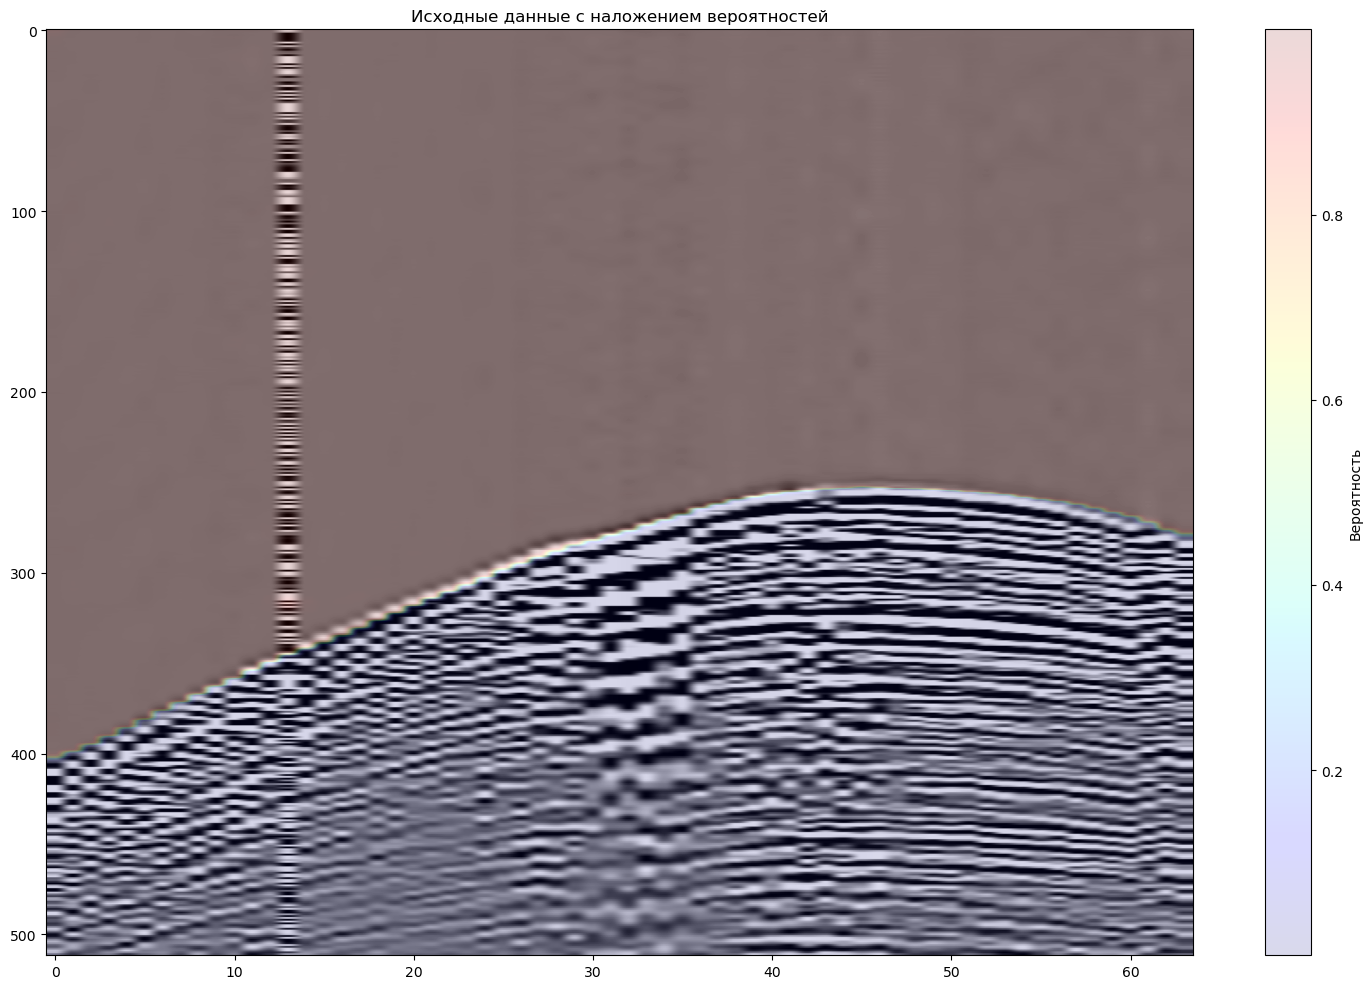

In [68]:


# Extract the probability and original data
i = 2
prob_data = prob1[i][0].detach().numpy().astype(np.float32)
original_data = shot[i]

# Создаем рисунок и оси
fig, ax = plt.subplots(figsize=(15, 10))

# Сначала отображаем исходные данные в оттенках серого
im1 = ax.imshow(original_data, cmap='gray', aspect='auto', origin='upper')

# Затем накладываем данные вероятностей с повышенной прозрачностью
im2 = ax.imshow(prob_data, cmap='jet', alpha=0.15, aspect='auto', origin='upper')  # Уменьшил alpha с 0.5 до 0.3

# Добавляем цветовую шкалу для наложения вероятностей
cbar = plt.colorbar(im2, ax=ax, label='Вероятность')

plt.title('Исходные данные с наложением вероятностей')
plt.tight_layout()
plt.show()

In [69]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def filter_small_clusters(red_probabilities, threshold=0.5):
    """Оставляет только самый большой кластер"""
    binary_mask = (red_probabilities > threshold).astype(np.uint8)
    if np.sum(binary_mask) == 0:
        return red_probabilities
    
    labeled_array, num_features = ndimage.label(binary_mask)
    if num_features <= 1:
        return red_probabilities
    
    sizes = np.bincount(labeled_array.flatten())
    largest_cluster = np.argmax(sizes[1:]) + 1
    largest_mask = (labeled_array == largest_cluster)
    
    filtered_probabilities = np.copy(red_probabilities)
    filtered_probabilities[binary_mask & (~largest_mask)] = 0.0
    
    return filtered_probabilities

def find_class_boundaries(probabilities, threshold=0.5):
    """Находит границу для каждой вертикали"""
    height, width = probabilities.shape
    boundaries = []
    
    for col in range(width):
        column_data = probabilities[:, col]
        binary_column = (column_data > threshold).astype(int)
        transitions = np.diff(binary_column)
        transition_indices = np.where(transitions != 0)[0]
        
        if len(transition_indices) == 0:
            boundaries.append(None)
        else:
            # Берем индекс последнего перехода
            boundaries.append(transition_indices[-1] + 1)
    
    return boundaries

def simple_merge_boundaries(prob1, shot, points, split_nt, threshold=0.5):
    """
    Простое объединение границ
    
    Параметры:
    - prob1: тензор вероятностей для подизображений
    - shot: список подизображений
    - points: стартовые позиции подизображений
    - split_nt: ширина подизображения
    - threshold: порог для бинаризации
    
    Возвращает:
    - объединенную границу для всего изображения
    """
    # Определяем полную ширину изображения
    total_width = points[-1] + split_nt
    
    # Создаем массив для сбора всех значений границ
    # Для каждой вертикали будем хранить список значений
    all_boundaries = [[] for _ in range(total_width)]
    
    # Обрабатываем каждое подизображение
    for i, start_point in enumerate(points):
        # Получаем вероятности для этого подизображения
        prob_data = prob1[i][0].detach().numpy().astype(np.float32)
        
        # Фильтруем малые кластеры
        filtered_prob = filter_small_clusters(prob_data, threshold)
        
        # Находим границу
        boundaries = find_class_boundaries(filtered_prob, threshold)
        
        # Добавляем значения границ в общий список
        for j, boundary in enumerate(boundaries):
            if boundary is not None:
                pos = start_point + j
                if pos < total_width:
                    all_boundaries[pos].append(boundary)
    
    # Выбираем итоговую границу как медиану значений в каждой вертикали
    merged_boundary = []
    for values in all_boundaries:
        if values:
            # Если есть значения, берем медиану
            merged_boundary.append(int(np.median(values)))
        else:
            # Если значений нет, ставим None
            merged_boundary.append(None)
    
    # Заполняем пропуски интерполяцией между соседними значениями
    for i in range(len(merged_boundary)):
        if merged_boundary[i] is None:
            # Находим ближайшие не-None значения слева и справа
            left_val, right_val = None, None
            left_idx, right_idx = i, i
            
            # Ищем слева
            while left_idx > 0:
                left_idx -= 1
                if merged_boundary[left_idx] is not None:
                    left_val = merged_boundary[left_idx]
                    break
            
            # Ищем справа
            while right_idx < len(merged_boundary) - 1:
                right_idx += 1
                if merged_boundary[right_idx] is not None:
                    right_val = merged_boundary[right_idx]
                    break
            
            # Заполняем значение интерполяцией
            if left_val is not None and right_val is not None:
                # Линейная интерполяция
                merged_boundary[i] = left_val + (right_val - left_val) * (i - left_idx) // (right_idx - left_idx)
            elif left_val is not None:
                merged_boundary[i] = left_val
            elif right_val is not None:
                merged_boundary[i] = right_val
            else:
                # Если нигде нет значений, ставим 0
                merged_boundary[i] = 0
    
    return merged_boundary

def visualize_simple_merged_boundary(shot, points, split_nt, merged_boundary):
    """Визуализирует объединенную границу на полном изображении"""
    # Реконструируем полное изображение
    total_width = points[-1] + split_nt
    height = shot[0].shape[0]
    full_image = np.zeros((height, total_width))
    
    for i, start_point in enumerate(points):
        end_point = min(start_point + split_nt, total_width)
        full_image[:, start_point:end_point] = shot[i][:, :end_point-start_point]
    
    # Создаем визуализацию
    plt.figure(figsize=(15, 10))
    plt.imshow(full_image, cmap='gray', aspect='auto', origin='upper')
    
    # Добавляем линию границы
    plt.plot(np.arange(total_width), merged_boundary, 'r-', linewidth=2, label='Граница')
    
    # Показываем границы подизображений
    for point in points:
        plt.axvline(x=point, color='b', linestyle='--', alpha=0.5)
    
    plt.legend()
    plt.title('Полное изображение с объединенной границей')
    plt.tight_layout()
    plt.show()

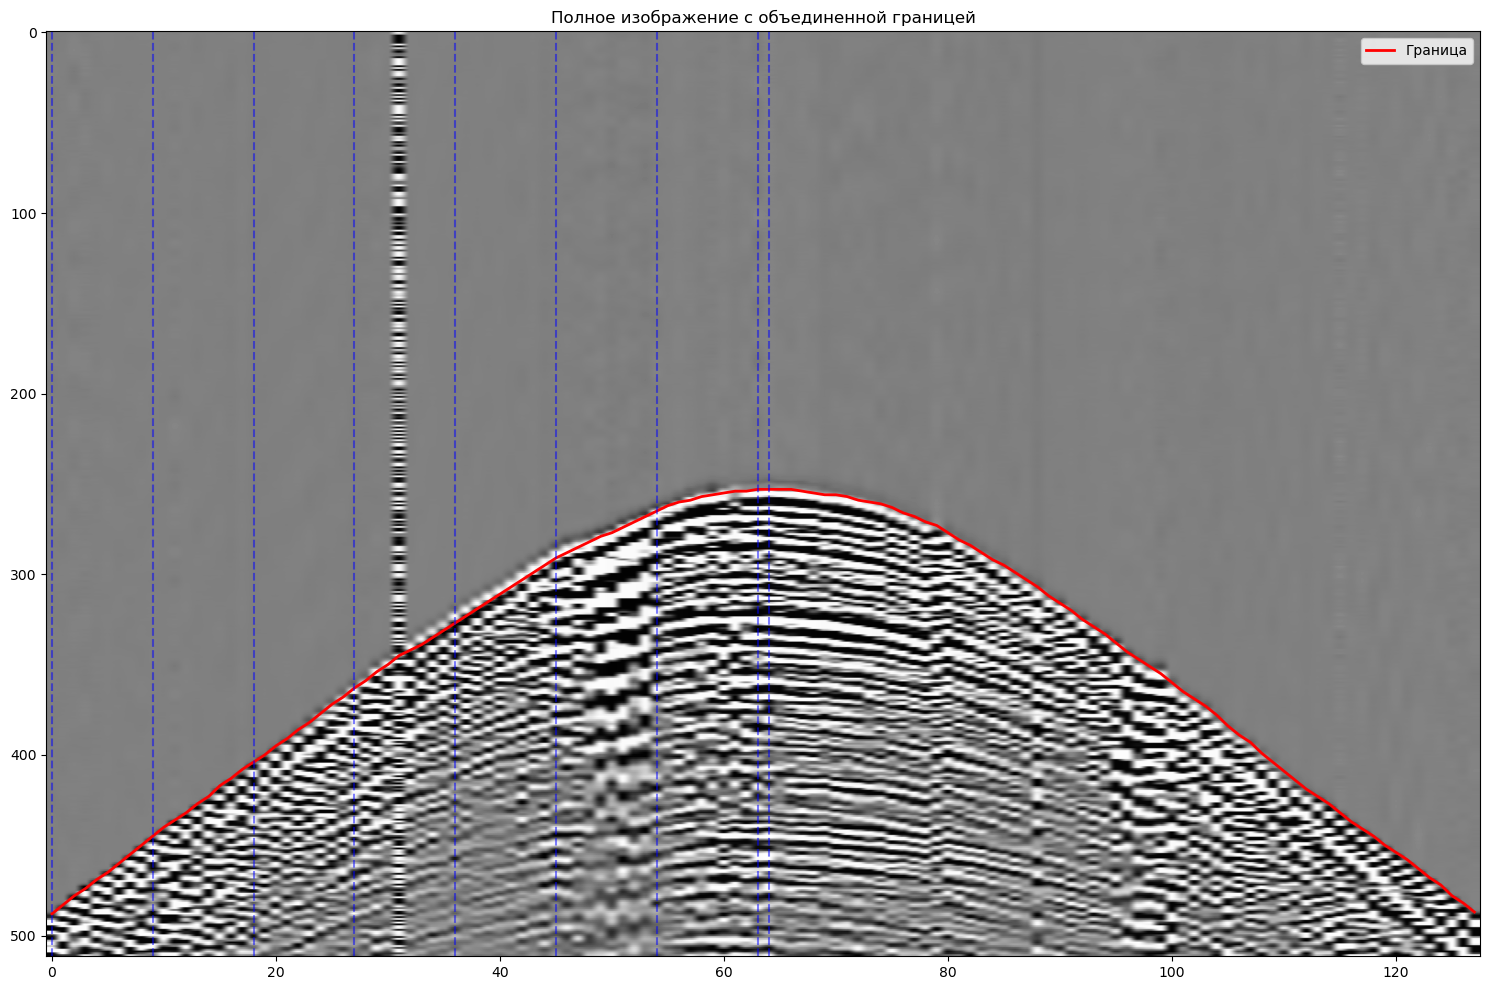

In [70]:
# После обработки изображений и получения predictions
merged_boundary = simple_merge_boundaries(
    prob1=prob1,
    shot=shot,
    points=points,
    split_nt=split_nt,
    threshold=0.5
)

# Визуализация результата
visualize_simple_merged_boundary(
    shot=shot,
    points=points,
    split_nt=split_nt,
    merged_boundary=merged_boundary
)